In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from tqdm import trange
from tqdm import tqdm
import time

In [2]:
from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('solarizedl')

In [2]:
np.__version__

'1.16.3'

In [3]:
#LineProfiler

from __future__ import print_function # Always do this >:( 
from __future__ import division
%load_ext line_profiler

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [5]:
def galdtype_darksage(Nannuli=30):
    floattype = np.float32
    Galdesc_full = [
                    ('Type'                         , np.int32),
                    ('GalaxyIndex'                  , np.int64),
                    ('HaloIndex'                    , np.int32),
                    ('SimulationHaloIndex'          , np.int32),
                    ('TreeIndex'                    , np.int32),
                    ('SnapNum'                      , np.int32),
                    ('CentralGalaxyIndex'           , np.int64),
                    ('CentralMvir'                  , floattype),
                    ('mergeType'                    , np.int32),
                    ('mergeIntoID'                  , np.int32),
                    ('mergeIntoSnapNum'             , np.int32),
                    ('dT'                           , floattype),
                    ('Pos'                          , (floattype, 3)),
                    ('Vel'                          , (floattype, 3)),
                    ('Spin'                         , (floattype, 3)),
                    ('Len'                          , np.int32),
                    ('LenMax'                       , np.int32),
                    ('Mvir'                         , floattype),
                    ('Rvir'                         , floattype),
                    ('Vvir'                         , floattype),
                    ('Vmax'                         , floattype),
                    ('VelDisp'                      , floattype),
                    ('DiscRadii'                    , (floattype, Nannuli+1)), 
                    ('ColdGas'                      , floattype),
                    ('StellarMass'                  , floattype),
                    ('MergerBulgeMass'              , floattype),
                    ('InstabilityBulgeMass'          , floattype),
                    ('HotGas'                       , floattype),
                    ('EjectedMass'                  , floattype),
                    ('BlackHoleMass'                , floattype),
                    ('IntraClusterStars'            , floattype),
                    ('DiscGas'                      , (floattype, Nannuli)),
                    ('DiscStars'                    , (floattype, Nannuli)),
                    ('SpinStars'                    , (floattype, 3)),
                    ('SpinGas'                      , (floattype, 3)),
                    ('SpinClassicalBulge'           , (floattype, 3)),
                    ('StarsInSitu'                  , floattype),
                    ('StarsInstability'             , floattype),
                    ('StarsMergeBurst'              , floattype),
                    ('DiscHI'                       , (floattype, Nannuli)),
                    ('DiscH2'                       , (floattype, Nannuli)),
                    ('DiscSFR'                      , (floattype, Nannuli)), 
                    ('MetalsColdGas'                , floattype),
                    ('MetalsStellarMass'            , floattype),
                    ('ClassicalMetalsBulgeMass'     , floattype),
                    ('SecularMetalsBulgeMass'       , floattype),
                    ('MetalsHotGas'                 , floattype),
                    ('MetalsEjectedMass'            , floattype),
                    ('MetalsIntraClusterStars'      , floattype),
                    ('DiscGasMetals'                , (floattype, Nannuli)),
                    ('DiscStarsMetals'              , (floattype, Nannuli)),
                    ('SfrFromH2'                    , floattype),
                    ('SfrInstab'                    , floattype),
                    ('SfrMergeBurst'                , floattype),
                    ('SfrDiskZ'                     , floattype),
                    ('SfrBulgeZ'                    , floattype),
                    ('DiskScaleRadius'              , floattype),
                    ('CoolScaleRadius'              , floattype), 
                    ('StellarDiscScaleRadius'       , floattype),
                    ('Cooling'                      , floattype),
                    ('Heating'                      , floattype),
                    ('LastMajorMerger'              , floattype),
                    ('LastMinorMerger'              , floattype),
                    ('OutflowRate'                  , floattype),
                    ('infallMvir'                   , floattype),
                    ('infallVvir'                   , floattype),
                    ('infallVmax'                   , floattype)
                    ]
    names = [Galdesc_full[i][0] for i in range(len(Galdesc_full))]
    formats = [Galdesc_full[i][1] for i in range(len(Galdesc_full))]
    Galdesc = np.dtype({'names':names, 'formats':formats}, align=True)
    return Galdesc

# Plot

In [6]:
#print(range(30,60))

In [6]:
# Make plots for z=0 galaxies that are typically used to constrain Dark Sage.

from pylab import *
import os
import routines as r
import random

# Warnings are annoying
import warnings
warnings.filterwarnings("ignore")


###### USER NEEDS TO SET THESE THINGS ######
indir = '/fred/oz042/rdzudzar/simulation_catalogs/darksage/millennium_latest/output/' # directory where the Dark Sage data are
sim = 1 # which simulation Dark Sage has been run on -- if it's new, you will need to set its defaults below.
#   0 = Mini Millennium, 1 = Full Millennium, 2 = SMDPL

fpre = 'model_z0.000' # what is the prefix name of the z=0 files
files = range(30) # list of file numbers you want to read

Nannuli = 30 # number of annuli used for discs in Dark Sage
FirstBin = 1.0 # copy from parameter file -- sets the annuli's sizes
ExponentBin = 1.4
###### ============================== ######



##### SIMULATION DEFAULTS #####
if sim==0:
    h = 0.73
    Lbox = 62.5/h * (len(files)/8.)**(1./3)
elif sim==1:
    h = 0.73
    Lbox = 500.0/h * (len(files)/512.)**(1./3)
elif sim==2:
    h = 0.6777
    Lbox = 400.0/h * (len(files)/1000.)**(1./3)
# add here 'elif sim==3:' etc for a new simulation
else:
    print('Please specify a valid simulation.  You may need to add its defaults to this code.')
    quit()
######  ================= #####


In [7]:
##### READ DARK SAGE DATA #####
DiscBinEdge = np.append(0, np.array([FirstBin*ExponentBin**i for i in range(Nannuli)])) / h
G = r.darksage_snap(indir+fpre, files, Nannuli=Nannuli)
######  ================= #####


In [8]:
##### SET PLOTTING DEFAULTS #####
fsize = 26
matplotlib.rcParams.update({'font.size': fsize, 'xtick.major.size': 10, 'ytick.major.size': 10, 'xtick.major.width': 1, 'ytick.major.width': 1, 'ytick.minor.size': 5, 'xtick.minor.size': 5, 'xtick.direction': 'in', 'ytick.direction': 'in', 'axes.linewidth': 1, 'text.usetex': True, 'font.family': 'serif', 'font.serif': 'Times New Roman', 'legend.numpoints': 1, 'legend.columnspacing': 1, 'legend.fontsize': fsize-4, 'xtick.top': True, 'ytick.right': True})

NpartMed = 100 # minimum number of particles for finding relevant medians for minima on plots

outdir = '/fred/oz042/rdzudzar/python/' # where the plots will be saved
if not os.path.exists(outdir): os.makedirs(outdir)
######  =================== #####

In [10]:
#%store G

## Want to store output as Pandas dataframe; Have to convert multidimensional arrays into Pandas series first:

In [11]:
import pandas as pd

In [10]:
# This is a way to converte multi dimensional data into pd.Series and then load these into the pandas dataframe
Pos = []
for p in G['Pos']:
    Pos.append(p)
Pos_df = pd.Series(Pos, dtype=np.dtype("object"))

Vel = []
for v in G['Vel']:
    Vel.append(v)
Vel_df = pd.Series(Vel, dtype=np.dtype("object"))

Spin = []
for s in G['Spin']:
    Spin.append(s)
Spin_df = pd.Series(Spin, dtype=np.dtype("object"))

Disc_r = []
for d in G['DiscRadii']:
    Disc_r.append(d)
Disc_df = pd.Series(Disc_r, dtype=np.dtype("object"))

Disc_gas = []
for g in G['DiscGas']:
    Disc_gas.append(g)
Disc_gas_df = pd.Series(Disc_gas, dtype=np.dtype("object"))

Disc_stars = []
for g in G['DiscStars']:
    Disc_stars.append(g)
Disc_stars_df = pd.Series(Disc_stars, dtype=np.dtype("object"))

SpinStars = []
for g in G['SpinStars']:
    SpinStars.append(g)
SpinStars_df = pd.Series(SpinStars, dtype=np.dtype("object"))

SpinGas = []
for g in G['SpinGas']:
    SpinGas.append(g)
SpinGas_df = pd.Series(SpinGas , dtype=np.dtype("object"))

SpinClassicalBulge = []
for g in G['SpinClassicalBulge']:
    SpinClassicalBulge.append(g)
SpinClassicalBulge_df = pd.Series(SpinClassicalBulge, dtype=np.dtype("object"))

DiscHI = []
for g in G['DiscHI']:
    DiscHI.append(g)
DiscHI_df = pd.Series(DiscHI, dtype=np.dtype("object"))

DiscH2 = []
for g in G['DiscH2']:
    DiscH2.append(g)
DiscH2_df = pd.Series(DiscH2, dtype=np.dtype("object"))

DiscSFR = []
for g in G['DiscSFR']:
    DiscSFR.append(g)
DiscSFR_df = pd.Series(DiscSFR, dtype=np.dtype("object"))

DiscGasMetals = []
for g in G['DiscGasMetals']:
    DiscGasMetals.append(g)
DiscGasMetals_df = pd.Series(DiscGasMetals, dtype=np.dtype("object"))

DiscStarsMetals = []
for g in G['DiscStarsMetals']:
    DiscStarsMetals.append(g)
DiscStarsMetals_df = pd.Series(DiscStarsMetals, dtype=np.dtype("object"))


# Storing DarkSage output as Pandas dataframe: DS

In [10]:
DS = pd.DataFrame({'Type'   : G['Type'                      ],
'GalaxyIndex'               : G['GalaxyIndex'               ],
'HaloIndex'                 : G['HaloIndex'                 ],
'SimulationHaloIndex'       : G['SimulationHaloIndex'       ],
'TreeIndex'                 : G['TreeIndex'                 ],
'SnapNum'                   : G['SnapNum'                   ],
'CentralGalaxyIndex'        : G['CentralGalaxyIndex'        ],
'CentralMvir'               : G['CentralMvir'               ],
'mergeType'                 : G['mergeType'                 ],
'mergeIntoID'               : G['mergeIntoID'               ],
'mergeIntoSnapNum'          : G['mergeIntoSnapNum'          ],
'dT'                        : G['dT'                        ],
'Pos'                       : Pos_df,
'Vel'                       : Vel_df                       ,
'Spin'                      : Spin_df                      ,
'Len'                       : G['Len'                       ],
'LenMax'                    : G['LenMax'                    ],
'Mvir'                      : G['Mvir'                      ],
'Rvir'                      : G['Rvir'                      ],
'Vvir'                      : G['Vvir'                      ],
'Vmax'                      : G['Vmax'                      ],
'VelDisp'                   : G['VelDisp'                   ],
'DiscRadii'                 : Disc_df,
'ColdGas'                   : G['ColdGas'                   ],
'StellarMass'               : G['StellarMass'               ],
'MergerBulgeMass'           : G['MergerBulgeMass'           ],
'InstabilityBulgeMass'      : G['InstabilityBulgeMass'      ],
'HotGas'                    : G['HotGas'                    ],
'EjectedMass'               : G['EjectedMass'               ],
'BlackHoleMass'             : G['BlackHoleMass'             ],
'IntraClusterStars'         : G['IntraClusterStars'         ],
'DiscGas'                   : Disc_gas_df,
'DiscStars'                 : Disc_stars_df,
'SpinStars'                 : SpinStars_df,
'SpinGas'                   : SpinGas_df,
'SpinClassicalBulge'        : SpinClassicalBulge_df,
'StarsInSitu'               : G['StarsInSitu'               ],
'StarsInstability'          : G['StarsInstability'          ],
'StarsMergeBurst'           : G['StarsMergeBurst'           ],
'DiscHI'                    : DiscHI_df,
'DiscH2'                    : DiscH2_df,
'DiscSFR'                   : DiscSFR_df,
'MetalsColdGas'             : G['MetalsColdGas'             ],
'MetalsStellarMass'         : G['MetalsStellarMass'         ],
'ClassicalMetalsBulgeMass'  : G['ClassicalMetalsBulgeMass'  ],
'SecularMetalsBulgeMass'    : G['SecularMetalsBulgeMass'    ],
'MetalsHotGas'              : G['MetalsHotGas'              ],
'MetalsEjectedMass'         : G['MetalsEjectedMass'         ],
'MetalsIntraClusterStars'   : G['MetalsIntraClusterStars'   ],
'DiscGasMetals'             : DiscGasMetals_df,
'DiscStarsMetals'           : DiscStarsMetals_df,
'SfrFromH2'                 : G['SfrFromH2'                 ],
'SfrInstab'                 : G['SfrInstab'                 ],
'SfrMergeBurst'             : G['SfrMergeBurst'             ],
'SfrDiskZ'                  : G['SfrDiskZ'                  ],
'SfrBulgeZ'                 : G['SfrBulgeZ'                 ],
'DiskScaleRadius'           : G['DiskScaleRadius'           ],
'CoolScaleRadius'           : G['CoolScaleRadius'           ],
'StellarDiscScaleRadius'    : G['StellarDiscScaleRadius'    ],
'Cooling'                   : G['Cooling'                   ],
'Heating'                   : G['Heating'                   ],
'LastMajorMerger'           : G['LastMajorMerger'           ],
'LastMinorMerger'           : G['LastMinorMerger'           ],
'OutflowRate'               : G['OutflowRate'               ],
'infallMvir'                : G['infallMvir'                ],
'infallVvir'                : G['infallVvir'                ],
'infallVmax'                : G['infallVmax'                ]})


In [11]:
DS.columns

Index(['BlackHoleMass', 'CentralGalaxyIndex', 'CentralMvir',
       'ClassicalMetalsBulgeMass', 'ColdGas', 'CoolScaleRadius', 'Cooling',
       'DiscGas', 'DiscGasMetals', 'DiscH2', 'DiscHI', 'DiscRadii', 'DiscSFR',
       'DiscStars', 'DiscStarsMetals', 'DiskScaleRadius', 'EjectedMass',
       'GalaxyIndex', 'HaloIndex', 'Heating', 'HotGas', 'InstabilityBulgeMass',
       'IntraClusterStars', 'LastMajorMerger', 'LastMinorMerger', 'Len',
       'LenMax', 'MergerBulgeMass', 'MetalsColdGas', 'MetalsEjectedMass',
       'MetalsHotGas', 'MetalsIntraClusterStars', 'MetalsStellarMass', 'Mvir',
       'OutflowRate', 'Pos', 'Rvir', 'SecularMetalsBulgeMass', 'SfrBulgeZ',
       'SfrDiskZ', 'SfrFromH2', 'SfrInstab', 'SfrMergeBurst',
       'SimulationHaloIndex', 'SnapNum', 'Spin', 'SpinClassicalBulge',
       'SpinGas', 'SpinStars', 'StarsInSitu', 'StarsInstability',
       'StarsMergeBurst', 'StellarDiscScaleRadius', 'StellarMass', 'TreeIndex',
       'Type', 'Vel', 'VelDisp', 'Vmax', 'Vvir', '

# My stuff

### Cut based on the stellar mass
### The HI mass: np.sum(G['DiscHI'],axis=1)

In [9]:
#Mass resolution 8.6x10^8 Msun/h  
#Make a cut at stellar masses of logMstar=8.8 -- based on the 100 particle median mass -- shown above
#0.088*h is 0.06424 which then becomes cut of 8.8 when divided with h
Stellar_mass_cut = G['StellarMass'] [ G['StellarMass']>0.06424 ]/h
HI_mass_cut = np.sum(G['DiscHI'],axis=1) [ G['StellarMass']>0.06424 ]/h
Mvir_mass_cut = G['Mvir'] [ G['StellarMass']>0.06424 ]/h

In [10]:
print(len(Stellar_mass_cut))

314234


In [11]:
#CENTRALS
Mstellar_central_galaxies_cut = G['StellarMass'] [ (G['CentralGalaxyIndex']==G['GalaxyIndex']) & (G['StellarMass']>0.06424) & (np.sum(G['DiscHI'],axis=1)!=0)]/h
Mcoldgas_central_galaxies_cut = np.sum(G['DiscHI'],axis=1) [ (G['CentralGalaxyIndex']==G['GalaxyIndex']) & (G['StellarMass']>0.06424) & (np.sum(G['DiscHI'],axis=1)!=0)]/h
Mvir_central_galaxies_cut = G['Mvir'] [ (G['CentralGalaxyIndex']==G['GalaxyIndex']) & (G['StellarMass']>0.06424) & (np.sum(G['DiscHI'],axis=1)!=0)]/h


In [12]:
#SATELLITES
Mstellar_satellite_galaxies_cut = G['StellarMass'] [ (G['CentralGalaxyIndex']!=G['GalaxyIndex']) & (G['StellarMass']>0.06424) & (np.sum(G['DiscHI'],axis=1)!=0)]/h
Mcoldgas_satellite_galaxies_cut = np.sum(G['DiscHI'],axis=1) [ (G['CentralGalaxyIndex']!=G['GalaxyIndex']) & (G['StellarMass']>0.06424) & (np.sum(G['DiscHI'],axis=1)!=0)]/h
Mvir_satellite_galaxies_cut = G['Mvir'] [ (G['CentralGalaxyIndex']!=G['GalaxyIndex']) & (G['StellarMass']>0.06424) & (np.sum(G['DiscHI'],axis=1)!=0)]/h


In [15]:
#TO STORE VARIABLES WHICH CAN BE USED IN ANOTHER NOTEBOOK
#central
%store Mstellar_central_galaxies_cut 
%store Mcoldgas_central_galaxies_cut 
%store Mvir_central_galaxies_cut
#satellite
%store Mstellar_satellite_galaxies_cut 
%store Mcoldgas_satellite_galaxies_cut 
%store Mvir_satellite_galaxies_cut

Stored 'Mstellar_central_galaxies_cut' (ndarray)
Stored 'Mcoldgas_central_galaxies_cut' (ndarray)
Stored 'Mvir_central_galaxies_cut' (ndarray)
Stored 'Mstellar_satellite_galaxies_cut' (ndarray)
Stored 'Mcoldgas_satellite_galaxies_cut' (ndarray)
Stored 'Mvir_satellite_galaxies_cut' (ndarray)


# Plot MHI vs M* relation

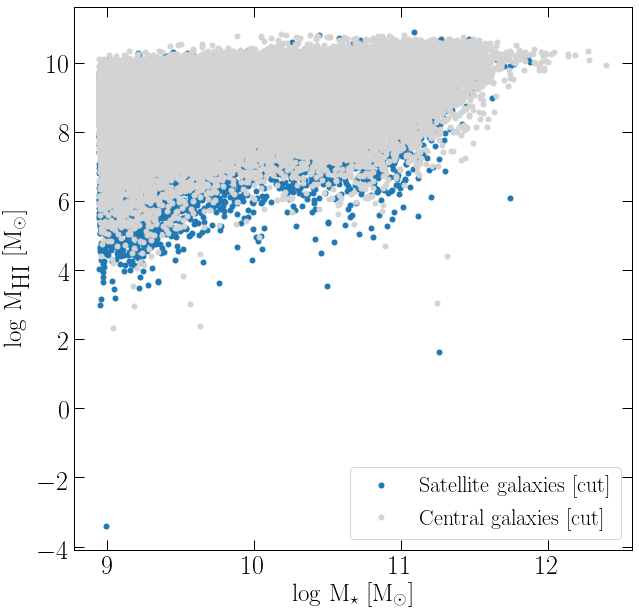

In [11]:
fig = plt.figure(figsize=(10,10))                                                               
ax = fig.add_subplot(1,1,1)

plt.plot( np.log10( (Mstellar_satellite_galaxies_cut*10**10)) ,np.log10( (Mcoldgas_satellite_galaxies_cut*10**10)), 'o', color='#1f78b4', markersize=5, label=r'Satellite galaxies [cut]')
#plt.plot(cut_stell*1e10/h, 'o', color='r')
plt.plot( np.log10( (Mstellar_central_galaxies_cut*10**10)) ,np.log10( (Mcoldgas_central_galaxies_cut*10**10)), 'o', color='lightgrey', markersize=5, label=r'Central galaxies [cut]')


ax.set_xlabel(r'log M$_{\star}$ [M$_{\odot}$]', fontsize=25)
ax.set_ylabel(r'log M$_{\textrm{HI}}$ [M$_{\odot}$]',fontsize=25)

plt.legend()
plt.show()

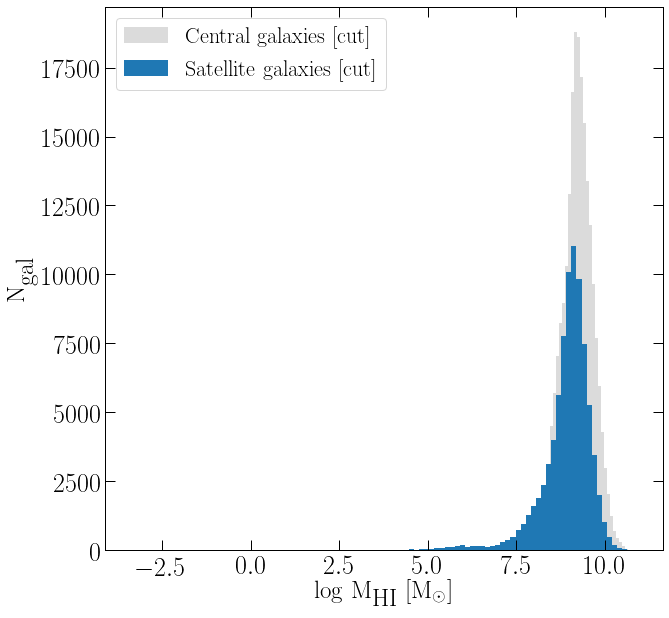

In [12]:
fig = plt.figure(figsize=(10,10))                                                               
ax = fig.add_subplot(1,1,1)

#plt.plot(cut_stell*1e10/h, 'o', color='r')
plt.hist( np.log10(Mcoldgas_central_galaxies_cut*1e10), bins=100, color='lightgrey', alpha=0.8, label=r'Central galaxies [cut]')
plt.hist(np.log10(Mcoldgas_satellite_galaxies_cut*1e10), bins=100, color='#1f78b4', alpha=1, label=r'Satellite galaxies [cut]')


ax.set_ylabel(r'N$_{\textrm{gal}}$', fontsize=25)
ax.set_xlabel(r'log M$_{\textrm{HI}}$ [M$_{\odot}$]',fontsize=25)

plt.legend()
#plt.xlim(-0.1, 3)
plt.show()

In [33]:
LenMaxCut = 80

Mlen_central = G['LenMax'] [ (G['CentralGalaxyIndex']==G['GalaxyIndex']) & (G['StellarMass']>0.06424)& (G['LenMax']>=LenMaxCut)]/h
Mlen_all_central = G['LenMax'] [ (G['CentralGalaxyIndex']==G['GalaxyIndex']) & (G['StellarMass']>0.06424)]/h
print(len(Mlen_central))
print(len(Mlen_all_central))

Mlen_sat = G['LenMax'] [ (G['CentralGalaxyIndex']!=G['GalaxyIndex']) & (G['StellarMass']>0.06424) & (G['LenMax']>=LenMaxCut)]/h
Mlen_all_sat = G['LenMax'] [ (G['CentralGalaxyIndex']!=G['GalaxyIndex']) & (G['StellarMass']>0.06424) ]/h
print(len(Mlen_sat))
print(len(Mlen_all_sat))

# These numbers are for the first 30 files in BigBox
#50 Particles: 224298   224682   89236   89552
#60 Particles: 223043   224682   88119   89552  ~1700 less centrals; ~1500 less satellites
#70 Particles: 220066   224682   85638   89552  ~5000 less centrals; ~4000 less satellites
#80 Particles: 214977   224682   82003   89552  ~10 000 less centrals; ~4000 less satellites
#90 Particles: 207607   224682   77608   89552
#100 Particles: 198476  224682   73181   89552

214977
224682
82003
89552


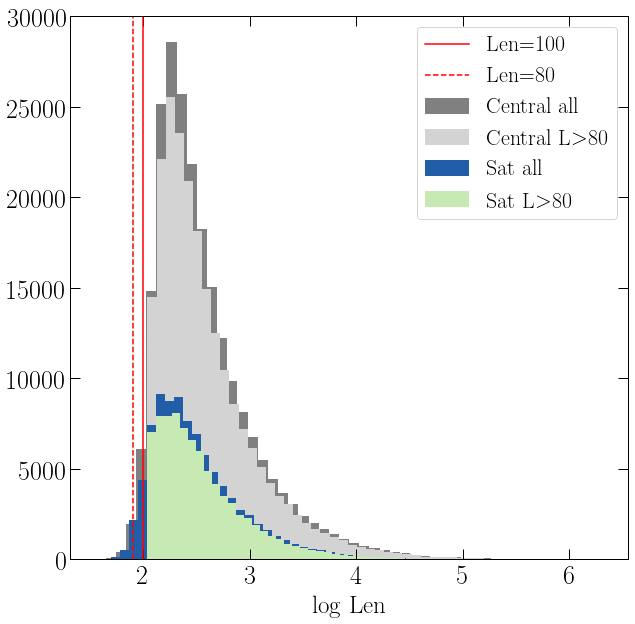

In [27]:

fig = plt.figure(figsize=(10,10))                                                               
ax = fig.add_subplot(1,1,1)

plt.hist( np.log10(Mlen_all_central), bins=50, color='grey',  label=r'Central all')
plt.hist( np.log10(Mlen_central), bins=50, color='lightgrey',  label=r'Central L$>${0}'.format(LenMaxCut))
plt.hist( np.log10(Mlen_all_sat), bins=50, color='#225ea8',  label=r'Sat all')
plt.hist( np.log10(Mlen_sat), bins=50, color='#c7e9b4',  label=r'Sat L$>${0}'.format(LenMaxCut))


plt.axvline(2, 0, label='Len=100', color='red')
plt.axvline(1.903089, 0, label='Len=80', color='red', linestyle='--')

ax.set_xlabel(r'log Len', fontsize=25)
#ax.set_ylabel(r'log M$_{\textrm{HI}}$ [M$_{\odot}$]',fontsize=25)

plt.legend()
plt.show()

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


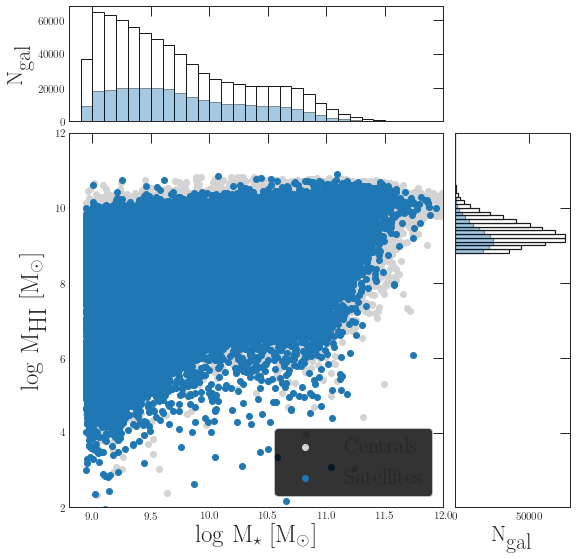

In [264]:
from matplotlib.ticker import NullFormatter

# the random data
x = np.log10( (Mstellar_satellite_galaxies_cut*10**10)) 
y = np.log10( (Mcoldgas_satellite_galaxies_cut*10**10))

w = np.log10( (Mstellar_central_galaxies_cut*10**10))
z = np.log10( (Mcoldgas_central_galaxies_cut*10**10))

nullfmt = NullFormatter()         # no labels

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(1, figsize=(8, 8))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

# the scatter plot:
axScatter.scatter(w, z, color='lightgrey', label='Centrals')
axScatter.scatter(x, y, color='#1f78b4', label='Satellites')

axScatter.set_xlabel(r'log M$_{\star}$ [M$_{\odot}$]', fontsize=25)
axScatter.set_ylabel(r'log M$_{\textrm{HI}}$ [M$_{\odot}$]',fontsize=25)

# now determine nice limits by hand:
binwidth = 0.1
xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])
lim = (int(xymax/binwidth) + 1) * binwidth

axScatter.set_xlim((8.8, lim))
axScatter.set_ylim((2, lim))

bins = np.arange(8.8, lim + binwidth, binwidth)
axHistx.hist(w, bins=bins, color='white', edgecolor='k', linewidth=1)
axHisty.hist(z, bins=bins, orientation='horizontal', color='white', edgecolor='k', linewidth=1.2)

axHistx.hist(x, bins=bins, color='#1f78b4',alpha=0.4, edgecolor='black', linewidth=1)
axHisty.hist(y, bins=bins, orientation='horizontal', color='#1f78b4', alpha=0.4, edgecolor='black', linewidth=1.2)

axHistx.set_ylabel(r'N$_{\textrm{gal}}$', fontsize=22)
axHisty.set_xlabel(r'N$_{\textrm{gal}}$', fontsize=22)

axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())

axScatter.legend()


plt.show()

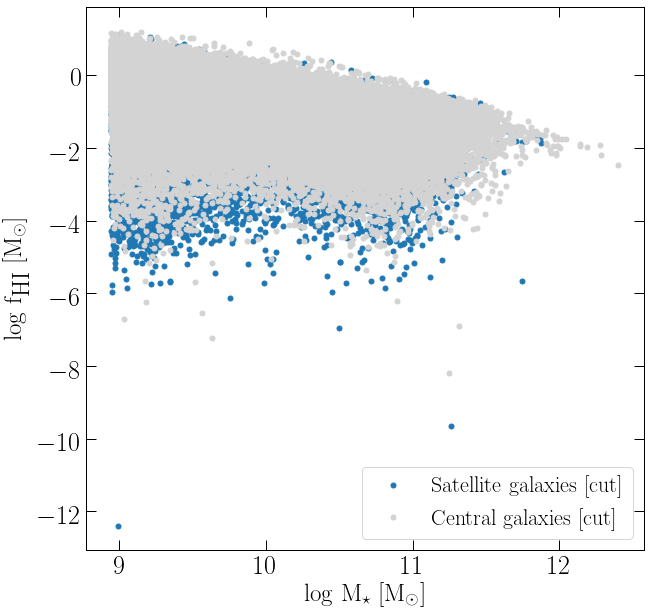

In [14]:
fig = plt.figure(figsize=(10,10))                                                               
ax = fig.add_subplot(1,1,1)

plt.plot( np.log10( (Mstellar_satellite_galaxies_cut*1e10)) ,np.log10( (Mcoldgas_satellite_galaxies_cut*1e10)/(Mstellar_satellite_galaxies_cut*1e10)), 'o', color='#1f78b4', markersize=5, label=r'Satellite galaxies [cut]')
#plt.plot(cut_stell*1e10/h, 'o', color='r')
plt.plot( np.log10( (Mstellar_central_galaxies_cut*1e10)) ,np.log10( (Mcoldgas_central_galaxies_cut*1e10)/(Mstellar_central_galaxies_cut*1e10)), 'o', color='lightgrey', markersize=5, label=r'Central galaxies [cut]')

ax.set_xlabel(r'log M$_{\star}$ [M$_{\odot}$]', fontsize=25)
ax.set_ylabel(r'log f$_{\textrm{HI}}$ [M$_{\odot}$]',fontsize=25)
 
plt.legend()
plt.show()

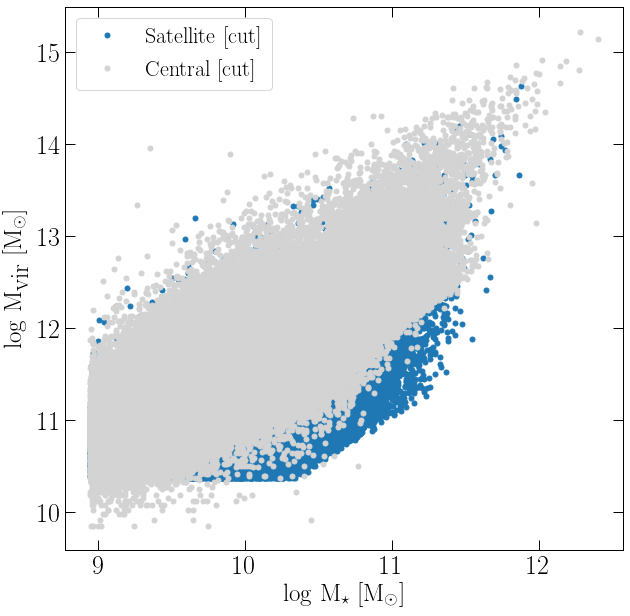

In [15]:
fig = plt.figure(figsize=(10,10))                                                               
ax = fig.add_subplot(1,1,1)

plt.plot( np.log10( (Mstellar_satellite_galaxies_cut*1e10)) ,np.log10( (Mvir_satellite_galaxies_cut*1e10)), 'o', color='#1f78b4', markersize=5, label=r'Satellite [cut]')
#plt.plot(cut_stell*1e10/h, 'o', color='r')
plt.plot( np.log10( (Mstellar_central_galaxies_cut*1e10)) ,np.log10( (Mvir_central_galaxies_cut*1e10)), 'o', color='lightgrey', markersize=5, label=r'Central [cut]')


ax.set_xlabel(r'log M$_{\star}$ [M$_{\odot}$]', fontsize=25)
ax.set_ylabel(r'log M$_{\textrm{vir}}$ [M$_{\odot}$]',fontsize=25)

plt.legend()
plt.show()

## Bulge-to-total ratio (All)
##### I want to see only late-type galaxies

In [265]:
BTT = (G['InstabilityBulgeMass'] + G['MergerBulgeMass']) / ( G['StellarMass'] ) # Find bulge to total ratio

# Including a cut in stellar mass
BTT_Disc = BTT[ ( G['StellarMass']>0.06424 ) & (BTT <= 0.5) ] # Disc dominated
BTT_Bulge = BTT[ ( G['StellarMass']>0.06424 ) & (BTT > 0.5) ] # Bulge dominated

Disc_dominated_SM = G['StellarMass'][ (G['StellarMass']>0.06424) & (BTT <= 0.5) ]
Bulge_dominated_SM = G['StellarMass'][ (G['StellarMass']>0.06424) & (BTT > 0.5) ]

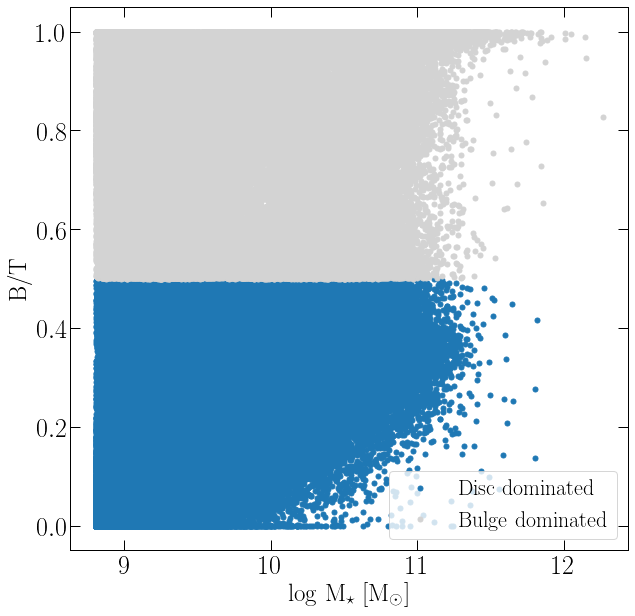

In [17]:
fig = plt.figure(figsize=(10,10))                                                               
ax = fig.add_subplot(1,1,1)

plt.plot( np.log10( (Disc_dominated_SM*1e10)) ,BTT_Disc, 'o', color='#1f78b4', markersize=5, label=r'Disc dominated')
#plt.plot(cut_stell*1e10/h, 'o', color='r')
plt.plot( np.log10( (Bulge_dominated_SM*1e10)) ,BTT_Bulge, 'o', color='lightgrey', markersize=5, label=r'Bulge dominated')


ax.set_xlabel(r'log M$_{\star}$ [M$_{\odot}$]', fontsize=25)
ax.set_ylabel(r'B/T',fontsize=25)

plt.legend()
plt.show()

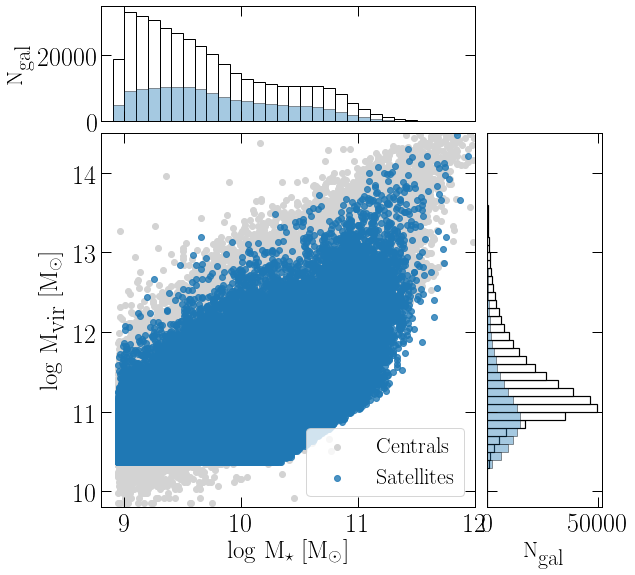

In [32]:
from matplotlib.ticker import NullFormatter

# the random data
x = np.log10( (Mstellar_satellite_galaxies_cut*10**10)) 
y = np.log10( (Mvir_satellite_galaxies_cut*1e10))

w = np.log10( (Mstellar_central_galaxies_cut*10**10))
z = np.log10( (Mvir_central_galaxies_cut*1e10))

nullfmt = NullFormatter()         # no labels

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(1, figsize=(8, 8))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

# the scatter plot:
axScatter.scatter(w, z, color='lightgrey', label='Centrals')
axScatter.scatter(x, y, color='#1f78b4', label='Satellites', alpha=0.8)

axScatter.set_xlabel(r'log M$_{\star}$ [M$_{\odot}$]', fontsize=25)
axScatter.set_ylabel(r'log M$_{\textrm{vir}}$ [M$_{\odot}$]',fontsize=25)

# now determine nice limits by hand:
binwidth = 0.1
xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])
lim = (int(xymax/binwidth) + 1) * binwidth

axScatter.set_xlim((8.8, 12))
axScatter.set_ylim((9.8, 14.5))

bins = np.arange(8.8, lim + binwidth, binwidth)
axHistx.hist(w, bins=bins, color='white', edgecolor='k', linewidth=1)
axHisty.hist(z, bins=bins, orientation='horizontal', color='white', edgecolor='k', linewidth=1.2)

axHistx.hist(x, bins=bins, color='#1f78b4',alpha=0.4, edgecolor='black', linewidth=1)
axHisty.hist(y, bins=bins, orientation='horizontal', color='#1f78b4', alpha=0.4, edgecolor='black', linewidth=1)

axHistx.set_ylabel(r'N$_{\textrm{gal}}$', fontsize=22)
axHisty.set_xlabel(r'N$_{\textrm{gal}}$', fontsize=22)

axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())

axScatter.legend(loc=4)


plt.show()

# Find for each central galaxy its satellites

In [20]:
#Central_g_stellar_mass = G['StellarMass'] [ (G['CentralGalaxyIndex']==G['GalaxyIndex']) & (G['StellarMass']>0.06424) & (np.sum(G['DiscHI'],axis=1)!=0)]/h
#Central_g_hi_mass = np.sum(G['DiscHI'],axis=1) [ (G['CentralGalaxyIndex']==G['GalaxyIndex']) & (G['StellarMass']>0.06424) & (np.sum(G['DiscHI'],axis=1)!=0)]/h
#Central_g_vir_mass = G['Mvir'] [ (G['CentralGalaxyIndex']==G['GalaxyIndex']) & (G['StellarMass']>0.06424) & (np.sum(G['DiscHI'],axis=1)!=0)]/h
#
#
#print(G['CentralGalaxyIndex'] [ G['CentralGalaxyIndex']==G['GalaxyIndex']] )
#print('Length', len(G['CentralGalaxyIndex'] [ G['CentralGalaxyIndex']==G['GalaxyIndex']] ))
#
#print(G['GalaxyIndex'] [ G['CentralGalaxyIndex']!=G['GalaxyIndex']] )
#print('Length', len(G['GalaxyIndex'] [ G['CentralGalaxyIndex']!=G['GalaxyIndex']]))
#
#print(len(G['CentralGalaxyIndex']))
#print(len(G['GalaxyIndex']))
#print(len(np.unique( G['CentralGalaxyIndex'] )))
#print(len(np.unique( G['GalaxyIndex'])))

## Find galaxies

In [28]:
Sat_inds = np.where( G['CentralGalaxyIndex']!=G['GalaxyIndex'])[0]
print('Sat_inds', Sat_inds[:28])
print(len(Sat_inds))
Central_inds = np.where(G['CentralGalaxyIndex']==G['GalaxyIndex'])[0]
print('Central_inds', Central_inds[:15])
print(len(Central_inds))
central_IDs = np.unique( G['CentralGalaxyIndex']  )
print('unique central ID', central_IDs[:10])

Sat_inds [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]
4750
Central_inds [ 0 29 30 31 32 33 34 35 36 37 38 39 40 41 42]
31739
unique central ID [  0 121 158 229 233 246 249 250 270 275]


## Extract indices and masses of central galaxies

In [266]:
store_cen_indices = []
store_cen_indices = np.where(G["Type"] == 0)[0]

## Extract indices and masses of ALL galaxies in a halo

In [267]:
central_IDs, unique_counts = np.unique(G["CentralGalaxyIndex"], return_counts=True) #find unique ids
group_offset = np.cumsum(unique_counts) #compute offset between ids

count = 0
store_all_indices = []

argsort_central_gal_idx = np.argsort(G["CentralGalaxyIndex"]) #argsort: array[1,0,-1]; sorted[-1,0,1], argsort[2,1,0]

for offset in group_offset:
    inds = np.arange(count, offset) #arrange counter and offsets
    my_list = argsort_central_gal_idx[inds] #make my list where argsort have their indices
    
    store_all_indices.append(my_list)
    
    count += len(my_list)

#print(empty[0:100])

#check if the sorting is good; it it isn't it sill print output    
for group in store_all_indices:
    if not np.all(G["CentralGalaxyIndex"][group] == G["CentralGalaxyIndex"][group][0]):
        print(G["CentralGalaxyIndex"][group])
        print(group)

In [21]:
print(store_cen_indices[0:5])
print(store_all_indices[0:5])

[  0 288 290 291 292]
[array([  0, 195, 194, 193, 192, 191, 190, 196, 189, 187, 186, 185, 184,
       183, 182, 188, 181, 197, 199, 213, 212, 211, 210, 209, 208, 198,
       207, 205, 204, 203, 202, 201, 200, 206, 214, 180, 178, 159, 158,
       157, 156, 155, 154, 160, 153, 151, 150, 149, 148, 147, 146, 152,
       179, 161, 163, 177, 176, 175, 174, 173, 172, 162, 171, 169, 168,
       167, 166, 165, 164, 170, 215, 216, 217, 269, 268, 267, 266, 265,
       264, 270, 263, 261, 260, 259, 258, 257, 256, 262, 255, 271, 273,
       287, 286, 285, 284, 283, 282, 272, 281, 279, 278, 277, 276, 275,
       274, 280, 254, 253, 252, 231, 230, 229, 228, 227, 226, 232, 225,
       223, 222, 221, 220, 219, 218, 224, 233, 234, 235, 251, 250, 249,
       248, 247, 246, 245, 244, 243, 241, 240, 239, 238, 237, 236, 145,
       144, 242, 142,  49,  48,  47,  46,  45,  44,  50,  43,  41,  40,
        39,  38,  37,  36,  42,  35,  51,  53,  68,  67,  66,  65,  64,
        62,  52,  61,  59,  58,  57,  56,

# Create dictionary for group sizes 
### Based on the number of galaxies in a group

In [268]:
groups = {} #initiate groups dictionary

#i = range(0, len(store_all_indices)) #gives range of halos

for item in trange(len(store_all_indices)):
#for item in trange(100):
    indices = store_all_indices[item]
    halo_length = len(indices) #gives length of each halo (central+satellite)
    try:
        groups[halo_length].append(indices)
    except KeyError:
        groups[halo_length] = []
        groups[halo_length].append(indices)
#print(groups)    


100%|██████████| 2987345/2987345 [00:01<00:00, 2148540.56it/s]


# Single galaxies

In [269]:
# SINGLE CENTRALS
Mass_cutoff = 0.06424
Group_of_one = 1

single_gal_ind = []

#initiate condition for group
for group in groups[Group_of_one]:
    if (G["StellarMass"][group] < Mass_cutoff).any(): #creates array of booleans; if theese are true hit continue
        continue
    
    #Store indices of single galaxies 
    single_gal_idx = group
    single_gal_ind.append(single_gal_idx)

In [270]:
Mstellar_single_gal = G["StellarMass"][single_gal_ind]*1e10/h
Mcoldgas_single_gal = np.sum(G['DiscHI'],axis=1)[single_gal_ind]*1e10/h
Mvir_single_gal = G["Mvir"][single_gal_ind]*1e10/h
BTT_single = (G['InstabilityBulgeMass'][single_gal_ind]*1e10/h + G['MergerBulgeMass'][single_gal_ind]*1e10/h) / ( G['StellarMass'][single_gal_ind]*1e10/h )



In [25]:
print(len(G["StellarMass"][ (G["StellarMass"] > Mass_cutoff) & (G['Len']>=100) ]))
print(len(G["StellarMass"][ (G["StellarMass"] > Mass_cutoff)]))

389558
541061


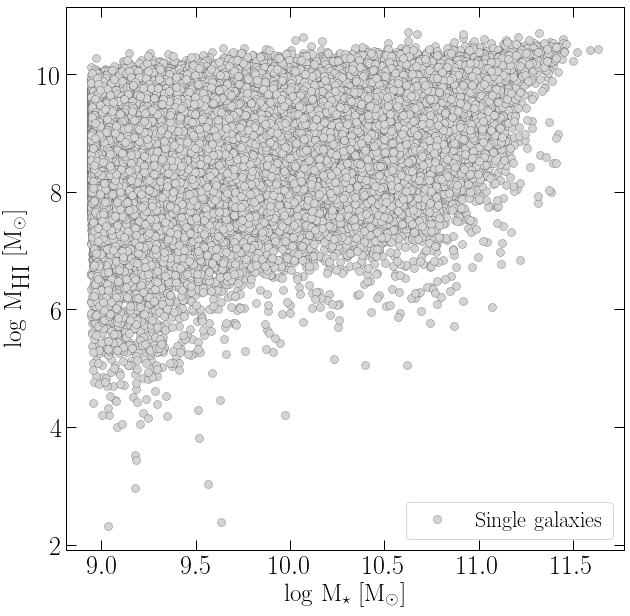

In [26]:

fig = plt.figure(figsize=(10,10))                                                               
ax = fig.add_subplot(1,1,1)


plt.plot(np.log10(Mstellar_single_gal), np.log10(Mcoldgas_single_gal), 'o', 
         color='lightgrey', markeredgecolor='k', markersize=8, markeredgewidth=0.2, label='Single galaxies')


ax.set_xlabel(r'log M$_{\star}$ [M$_{\odot}$]', fontsize=25)
ax.set_ylabel(r'log M$_{\textrm{HI}}$ [M$_{\odot}$]',fontsize=25)
plt.legend(loc=4)
plt.show()

# All galaxies in groups that are N=given N
#### if **any galaxy in the group** has Mass less than `Mass_cutoff`, we don't plot the entire group

In [271]:
Mass_cutoff = 0.06424

In [28]:
print(G["StellarMass"][groups[15][1]] > Mass_cutoff)
print(G["StellarMass"][groups[15][1]])

[ True  True  True  True  True False  True  True  True  True  True  True
  True  True  True]
[ 0.13289797  0.10358704  1.1511267   0.28647518  0.10224913  0.02536963
  0.78384507  2.18843     1.4079691   0.390892    0.5568539   0.3564639
  5.181992    5.979242   10.180819  ]


### Separated centrals and satellites

KeyboardInterrupt: 

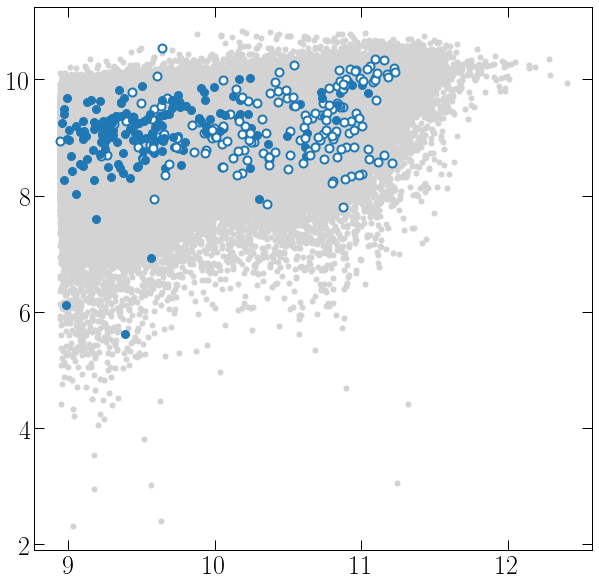

In [24]:
#print(G["StellarMass"][groups[4][0]] < Mass_cutoff)
#print(G["StellarMass"][groups[4][0]])

Group_size = 2 # select number of galaxies per group

fig = plt.figure(figsize=(10,10))                                                               
ax = fig.add_subplot(1,1,1)
plt.plot( np.log10( (Mstellar_central_galaxies_cut*10**10)) ,np.log10( (Mcoldgas_central_galaxies_cut*10**10)), 'o', color='lightgrey', markersize=5, label=r'Central galaxies [cut]')

#initiate condition for plot
for group in groups[Group_size]:
    if (G["StellarMass"][group] < Mass_cutoff).any(): #creates array of booleans; if theese are true hit continue
        continue
            
        # Do plotting.
    #plot all galaxies here; for loops below plots satellite and centrals separatelly
    #plt.plot(np.log10(G['StellarMass'][group]*1e10/h), np.log10(G['ColdGas'][group]*1e10/h), 'o', color='blue', markersize=12)
    
    for i in group: #find central galaxies and plot them as red
        if i in store_cen_indices: 
            #print(i)
            plt.plot(np.log10(G['StellarMass'][i]*1e10/h), np.log10(np.sum(G['DiscHI'],axis=1)[i]*1e10/h), 
                     'o', color='white', markeredgecolor='#1f78b4', markersize=8, markeredgewidth=2)
        else:
            if (G["StellarMass"][i] > Mass_cutoff).any(): # else find where galaxy is satellite; take into account mass cut
                plt.plot(np.log10(G['StellarMass'][i]*1e10/h), np.log10(np.sum(G['DiscHI'],axis=1)[i]*1e10/h), 
                         'o', color='#1f78b4', markersize=8)
        
ax.set_xlabel(r'log M$_{\star}$ [M$_{\odot}$]', fontsize=25)
ax.set_ylabel(r'log M$_{\textrm{HI}}$ [M$_{\odot}$]',fontsize=25)
plt.plot([], [], 'o', color='#1f78b4', markersize=8, label='Satellite')
plt.plot([], [], 'o', color='white', markeredgecolor='#1f78b4', markersize=8, markeredgewidth=2, label='Central')

plt.legend(loc=4)
plt.show()

# All central and satellite galaxies in groups of length 2+ and single galaxies

100%|██████████| 8/8 [00:04<00:00,  1.61it/s]


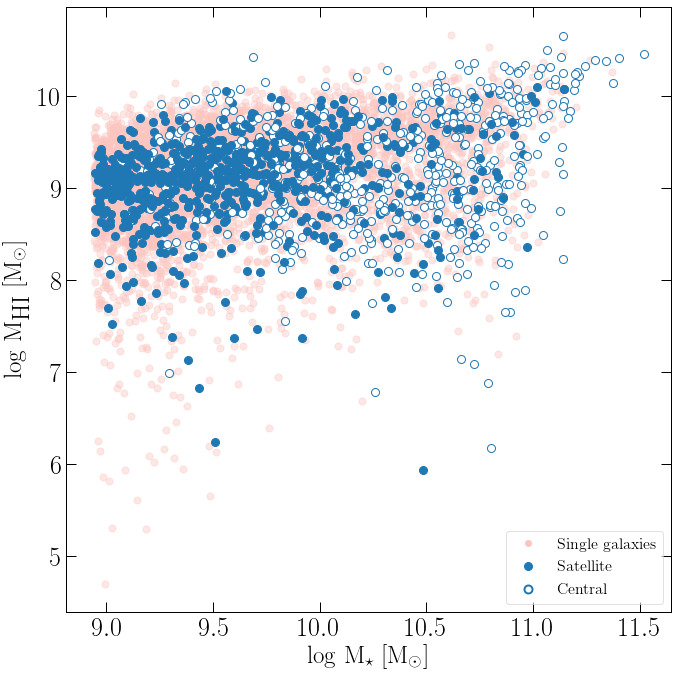

In [41]:
#initiate figure and how large it will be
fig = plt.figure(figsize=(10,10))                                                               
ax = fig.add_subplot(1,1,1)

ax.scatter(np.log10(Mstellar_single_gal), np.log10(Mcoldgas_single_gal), marker='o', s=50, color='#fcc5c0', zorder=-3, alpha=0.4)

#put plot in row and columns:3by3 are 00, 01, 02, 10, 11, 12, 20, 21, 22 
row_count = 0
for size in trange(1, 9, 1): #I'm planning to have 1-9 sized groups

    Group_size = size+1 # select number of galaxies per group --- adding +1 because it is counting from 0.
    

    #plot centrals to be on each plot
  
        #initiate condition for plot
    for group in groups[Group_size]:
        if (G["StellarMass"][group] < Mass_cutoff).any(): #creates array of booleans; if theese are true hit continue
            continue
        
        for i in group: #find central galaxies and plot them as red
            if i in store_cen_indices:
            #print(i)
                ax.plot(np.log10(G['StellarMass'][i]*1e10/h), np.log10(np.sum(G['DiscHI'],axis=1)[i]*1e10/h), 
                     'o', color='white', markeredgecolor='#1f78b4', markersize=8, markeredgewidth=1)
            else:
                #if (G["StellarMass"][i] > Mass_cutoff).any(): # else find where galaxy is satellite; take into account mass cut
                ax.plot(np.log10(G['StellarMass'][i]*1e10/h), np.log10(np.sum(G['DiscHI'],axis=1)[i]*1e10/h), 
                             'o', color='#1f78b4', markersize=8)

    #add label for each sub-plot to know the group size and what is central/satellite
ax.plot([], [], 'o', color='#fcc5c0', label='Single galaxies')
ax.plot([], [], 'o', color='#1f78b4', markersize=8, label='Satellite')
ax.plot([], [], 'o', color='white', markeredgecolor='#1f78b4', markersize=8, markeredgewidth=2, label='Central')


ax.set_xlabel(r'log M$_{\star}$ [M$_{\odot}$]', fontsize=25)
ax.set_ylabel(r'log M$_{\textrm{HI}}$ [M$_{\odot}$]',fontsize=25)

leg = ax.legend(loc=4,frameon=True,fancybox=True, framealpha=0.6, fontsize=16)

#add x and y axis labels only on the plot edges since there will be no space between panels

#tight layout and remove spacing between subplots
plt.tight_layout()
#plt.legend(loc=4)
plt.savefig('MHI_vs_Mstar_Groups.png')
plt.show()

### Now mark central and satellites in the N times N plot
###### Takes 00:00:4 to run

100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


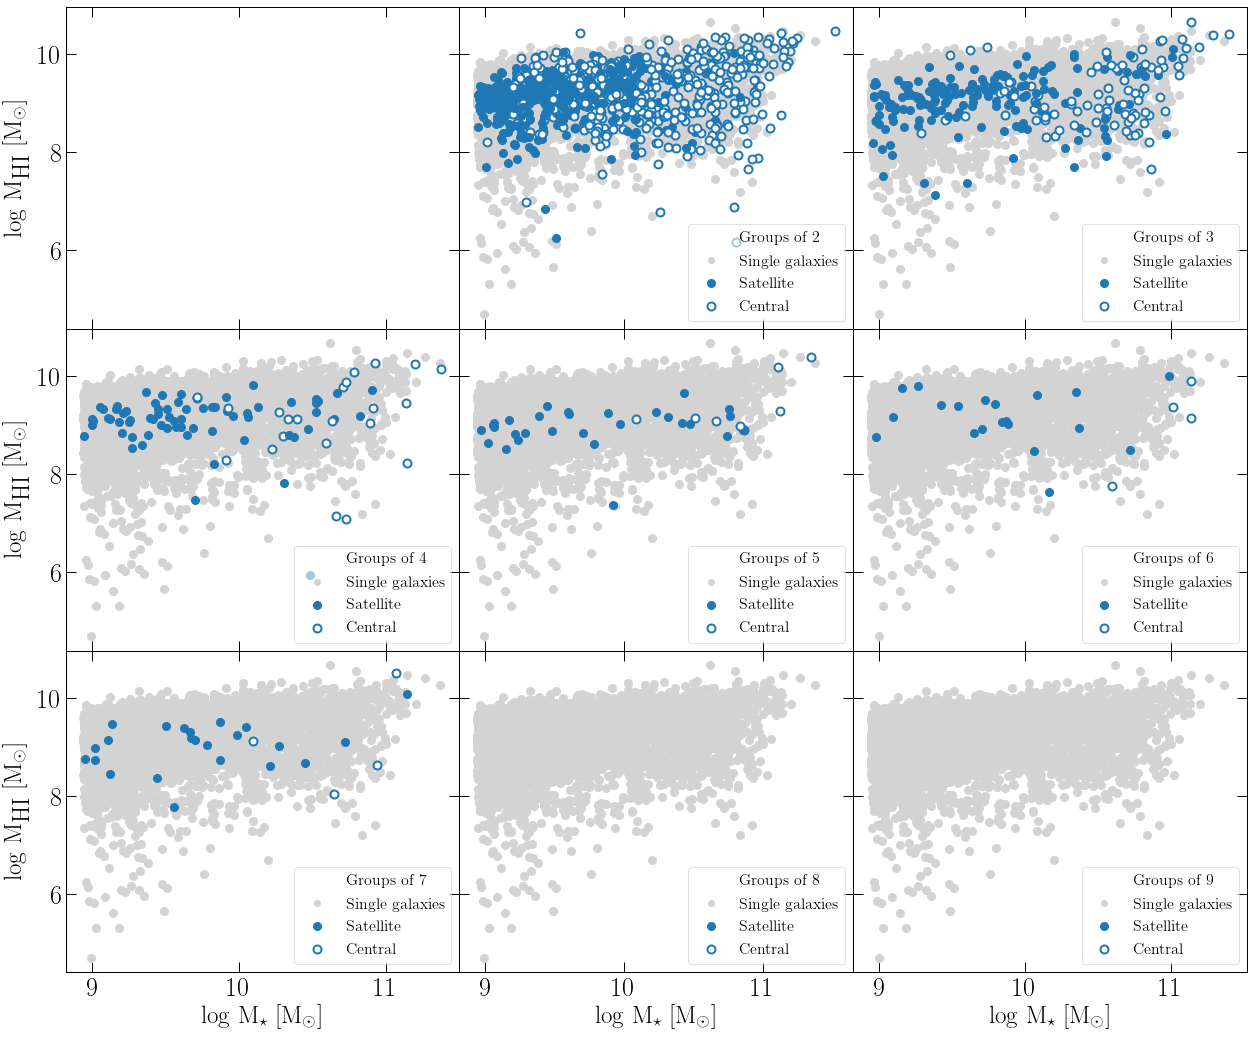

In [42]:
#initiate figure and how large it will be
fig, ax = plt.subplots(nrows=3, ncols=3, sharex='col', sharey='row', figsize=(18, 15))

#put plot in row and columns:3by3 are 00, 01, 02, 10, 11, 12, 20, 21, 22 
row_count = 0
for size in trange(1, 9, 1): #I'm planning to have 1-9 sized groups
        
    if size % 3 == 0:
        row_count += 1
    this_ax = ax[row_count, size%3]
    
    Group_size = size+1 # select number of galaxies per group --- adding +1 because it is counting from 0.
    

    #plot centrals to be on each plot
    this_ax.plot(np.log10(Mstellar_single_gal), np.log10(Mcoldgas_single_gal), 'o', color='lightgrey',markersize=8)
  
        #initiate condition for plot
    for group in groups[Group_size]:
        if (G["StellarMass"][group] < Mass_cutoff).any(): #creates array of booleans; if theese are true hit continue
            continue
        
        for i in group: #find central galaxies and plot them as red
            if i in store_cen_indices:
            #print(i)
                this_ax.plot(np.log10(G['StellarMass'][i]*1e10/h), np.log10(np.sum(G['DiscHI'],axis=1)[i]*1e10/h), 
                     'o', color='white', markeredgecolor='#1f78b4', markersize=8, markeredgewidth=2)
            else:
                #if (G["StellarMass"][i] > Mass_cutoff).any(): # else find where galaxy is satellite; take into account mass cut
                this_ax.plot(np.log10(G['StellarMass'][i]*1e10/h), np.log10(np.sum(G['DiscHI'],axis=1)[i]*1e10/h), 
                             'o', color='#1f78b4', markersize=8)

    #add label for each sub-plot to know the group size and what is central/satellite
    this_ax.plot([], [], 'o', color='white', label='Groups of %.f' %Group_size)
    this_ax.plot([], [], 'o', color='lightgrey', label='Single galaxies')
    this_ax.plot([], [], 'o', color='#1f78b4', markersize=8, label='Satellite')
    this_ax.plot([], [], 'o', color='white', markeredgecolor='#1f78b4', markersize=8, markeredgewidth=2, label='Central')

    leg = this_ax.legend(loc=4,frameon=True,fancybox=True, framealpha=0.6, fontsize=16)

#add x and y axis labels only on the plot edges since there will be no space between panels
for row in range(3):
    this_ax = ax[row,0]
    this_ax.set_ylabel(r'log M$_{\textrm{HI}}$ [M$_{\odot}$]',fontsize=25)
for col in range(3):
    this_ax = ax[2,col]
    this_ax.set_xlabel(r'log M$_{\star}$ [M$_{\odot}$]', fontsize=25)
#tight layout and remove spacing between subplots
plt.tight_layout()
#plt.legend(loc=4)
plt.subplots_adjust(wspace = 0.0, hspace = 0.0)
plt.savefig('MHI_vs_Mstar_Groups.png')
plt.show()

## Make upper plot muchfaster

# Create cen & sat from groups dictionary

In [272]:
def create_cen_sat_from_groups_dict(groups, store_cen_indices, my_mass_cutoff=Mass_cutoff):
    """
    Created dictionary which is used to extract indices of central and satellite galaxies, taking into account
    the mass cutoff provided. Also creates "Groups" which store information on a group basis and their sat/cen galaxies.
    
    Parameters
    ==========
    
    groups: dictionary. Keyed by the size of the group, ``groups[group_size]``
            Contains list of arrays of a given group_size length. 
    
    Mass_cutoff: Constant.
                 Equal to 0.06424: defined as median stellar mass for halos composed of 100 particles.
    
    store_cen_indices: List of integers
                       Contains indices which correspond to central galaxies
        
    Returns
    =======
    new_groups_dict: Nested dictionary. Keyed by the `groups`.
                     Contains Centrals and Satellites which are in groups where galaxies are above the my_mass_cutoff
                     
    Usage
    =====
    #This is updated dictionary which one can parse to the plotting function:
    updated_dict = create_cen_sat_from_groups_dict(groups, store_cen_indices) 
    
    ---------
    #Select groups of 3 and only central galaxies:
    central_inds = updated_dict[3]["Centrals"]
    G["StellarMass"][central_inds] #gives array of central galaxy stellar masses 
    
    """
    new_groups_dict = {}
    
    for group_size in groups.keys(): #go through the keys in groups dictionary
        central_gals = []
        sat_gals = []
        halo_gals = []
        halo_groups = []
        
        new_groups_dict[group_size] = {} #new dictionary based on group size
        new_groups_dict[group_size]["Groups"] = {} #new dictionary for storring whole groups
        counter = 0
        for group in groups[group_size]:
            
            central_gals_group = [] #store central in "Groups"
            sat_gals_group = [] #store satellites in "Groups"
            
            if (G["StellarMass"][group] < my_mass_cutoff).any(): #creates array of booleans; if theese are true hit continue
                continue
            if (G['LenMax'][group] < 100).any():
                continue
            
            halo_groups.append(group)
            
            # Use np.where to find indices of satellites and central galaxies
            for galaxy in group:
                halo_gals.append(galaxy) #add to halo_gals to know galaxies in the halo
                local_idx = np.where(galaxy == store_cen_indices)[0] # Check if the idx is in the store_cen_indices
                
                if len(local_idx) == 0: # If the idx is not present in store_cen_indisces then it is satellite
                    sat_gals.append(galaxy)
                    sat_gals_group.append(galaxy)
                elif len(local_idx) == 1: # If the idx is present then it is central galaxy
                    central_gals.append(galaxy)
                    central_gals_group.append(galaxy)
                else: # Check for funky stuff and raise an error
                    print("Somehow got a duplicate value in store_cen_indices.  Galaxy is {0}, group is {1} and local_idx value is {2}"
                          .format(galaxy, group, local_idx))
                    raise ValueError
            group_key = "Group_{0}".format(counter) #create group_key based on the groups
            new_groups_dict[group_size]["Groups"][group_key] = {} #new dictionary with all groups
            new_groups_dict[group_size]["Groups"][group_key]["Centrals"] = central_gals_group
            new_groups_dict[group_size]["Groups"][group_key]["Satellites"] = sat_gals_group
            counter += 1
            
                              
        # Append to dictionary found centrals and satellites
        new_groups_dict[group_size]["Centrals"] = central_gals
        new_groups_dict[group_size]["Satellites"] = sat_gals
        new_groups_dict[group_size]["All_galaxies"] = halo_gals
        new_groups_dict[group_size]['All_groups'] = halo_groups
        
        
    return new_groups_dict
                    

In [273]:
#This is updated dictionary which one can parse to the plotting function:
updated_dict = create_cen_sat_from_groups_dict(groups, store_cen_indices) 

### Example of the usage of updated_dict -- taking "Groups"

In [29]:
#Use dictionary and for each galaxy in "Groups" of 3 show central/satellite index
Grp_length = 69
for group_key in updated_dict[Grp_length]["Groups"].keys():
    central_idx = updated_dict[Grp_length]["Groups"][group_key]["Centrals"] #give indices
    central_mass = np.sum(G['DiscHI'],axis=1)[central_idx] #give masses of these galaxies
    
    satellite_inds = updated_dict[Grp_length]["Groups"][group_key]["Satellites"]
    sat_mass = np.sum(G['DiscHI'],axis=1)[satellite_inds]
    
    if (sat_mass > central_mass).any(): #check conditions
        print("Sat more massive than central")
    #print(sat_mass > central_mass)
    
    print("Central mass is {0} and sat masses are {1}".format(central_mass, sat_mass))
    #print(updated_dict[3]["Groups"][group_key]["Centrals"])

    
updated_dict[3]["Groups"]["Group_10"] #shows indices for 10th Group in Groups of length 3

{'Centrals': [5977], 'Satellites': [5978, 5979]}

### Check group sizes

In [277]:
for i in trange(1,20):
    print(i, len(updated_dict[i]["Groups"].keys()))
#    
#print(updated_dict[20]['Groups'].keys())

100%|██████████| 19/19 [00:00<00:00, 9761.36it/s]

1 538615
2 29945
3 5007
4 1269
5 430
6 145
7 89
8 32
9 9
10 4
11 1
12 1
13 1
14 0
15 0
16 0
17 0
18 0
19 0


In [274]:
# Initiate figure and how large it will be
def mhi_vs_ms_3x3(groups_dict):
    
    """
    Make 3x3 plot (HI mass vs Stellar mass) with galaxy groups based on the number of galaxies in a group and separate in each group central
    and satellite galaxy.
    
    Parameters
    ==========
    groups_dict: Dictionary. Keyed by the group size. Use: ``groups_dict[group_size]["Centrals"]``
                 Extracts groups with size N and the satellite & central galaxies
                 Created dictionary from (def create_cen_sat_from_groups_dict)
  
    Returns
    =======
    3x3 Figure with M_HI versus M_*
    
    Usage
    =====
    To use type: ``mhi_vs_ms_3x3(updated_dict) ``
                 Where updated_dict is the dictionary that is parsed to plotting function
                 ``updated_dict = create_cen_sat_from_groups_dict(groups, store_cen_indices)``
    
    """
    
    
    fig, ax = plt.subplots(nrows=4, ncols=5, sharex='col', sharey='row', figsize=(18, 15))
    
    #ax[0][0].plot(np.log10(Mstellar_single_gal), np.log10(Mcoldgas_single_gal), 'o', color='lightgrey',markersize=8, label='Single galaxies')
    
    # Put plot in row and columns:3by3 are 00, 01, 02, 10, 11, 12, 20, 21, 22 
    row_count = 0
    for size in trange(1, 20, 1): #I'm planning to have 1-9 sized groups. Made to form trange(1, 9, 1) as 3x3 pannels 
            
        if size % 5 == 0:
            row_count += 1
        this_ax = ax[row_count, size%5] #Axis. Created for plotting 3x3 plots
        
        group_size = size+1 # Select number of galaxies per group --- adding +1 because it is counting from 0.
    
        central_gals = groups_dict[group_size]["Centrals"]  #List of integers. Contains indices of central galaxies.  List is obtained through the dictionary. 
        sat_gals = groups_dict[group_size]["Satellites"] #List of integers. Contains indices of satellite galaxies. List is obtained through the dictionary.
    
        # Plot single galaxies           
        #this_ax.plot(np.log10(Mstellar_single_gal), np.log10(Mcoldgas_single_gal), 'o', color='lightgrey',markersize=8)
        
            
        # Do plotting of groups of N-length; it will be placed on each subplot + +.
        # Centrals
        this_ax.plot(np.log10(G['StellarMass'][central_gals]*1e10/h), 
                         np.log10(np.sum(G['DiscHI'],axis=1)[central_gals]*1e10/h), 
                         'o', color='white', markeredgecolor='#1f78b4', markersize=8, markeredgewidth=2)
        # Satellites
        this_ax.plot(np.log10(G['StellarMass'][sat_gals]*1e10/h), 
                         np.log10(np.sum(G['DiscHI'],axis=1)[sat_gals]*1e10/h), 
                         'o', color='#1f78b4', markersize=8)
    
        # Add label for each sub-plot to know the group size and what is central/satellite
        this_ax.plot([], [], 'o', color='white', label='Groups of %.f' %group_size)
        this_ax.plot([], [], 'o', color='lightgrey', label='Single galaxies')
        this_ax.plot([], [], 'o', color='#1f78b4', markersize=8, label='Satellite')
        this_ax.plot([], [], 'o', color='white', markeredgecolor='#1f78b4', markersize=8, markeredgewidth=2, label='Central')
        #Add legend    
        leg = this_ax.legend(loc=4,frameon=True,fancybox=True, framealpha=0.6, fontsize=16)
        
    # Add x and y axis labels only on the plot edges since there will be no space between panels
    for row in range(4):
        this_ax = ax[row,0]
        this_ax.set_ylabel(r'log M$_{\textrm{HI}}$ [M$_{\odot}$]',fontsize=25)
    for col in range(5):
        this_ax = ax[3,col]
        this_ax.set_xlabel(r'log M$_{\star}$ [M$_{\odot}$]', fontsize=25)
        this_ax.xaxis.set_ticks(np.arange(9,11.9, 1))
    # Tight layout and remove spacing between subplots
    plt.tight_layout()
    # My first plot is only single galaxies so I add legend separately
    ax[0][0].legend(loc=4,frameon=True,fancybox=True, framealpha=0.6, fontsize=16)

    plt.subplots_adjust(wspace = 0.0, hspace = 0.0)
    plt.show()
    #return fig


100%|██████████| 19/19 [00:11<00:00,  1.66it/s]
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


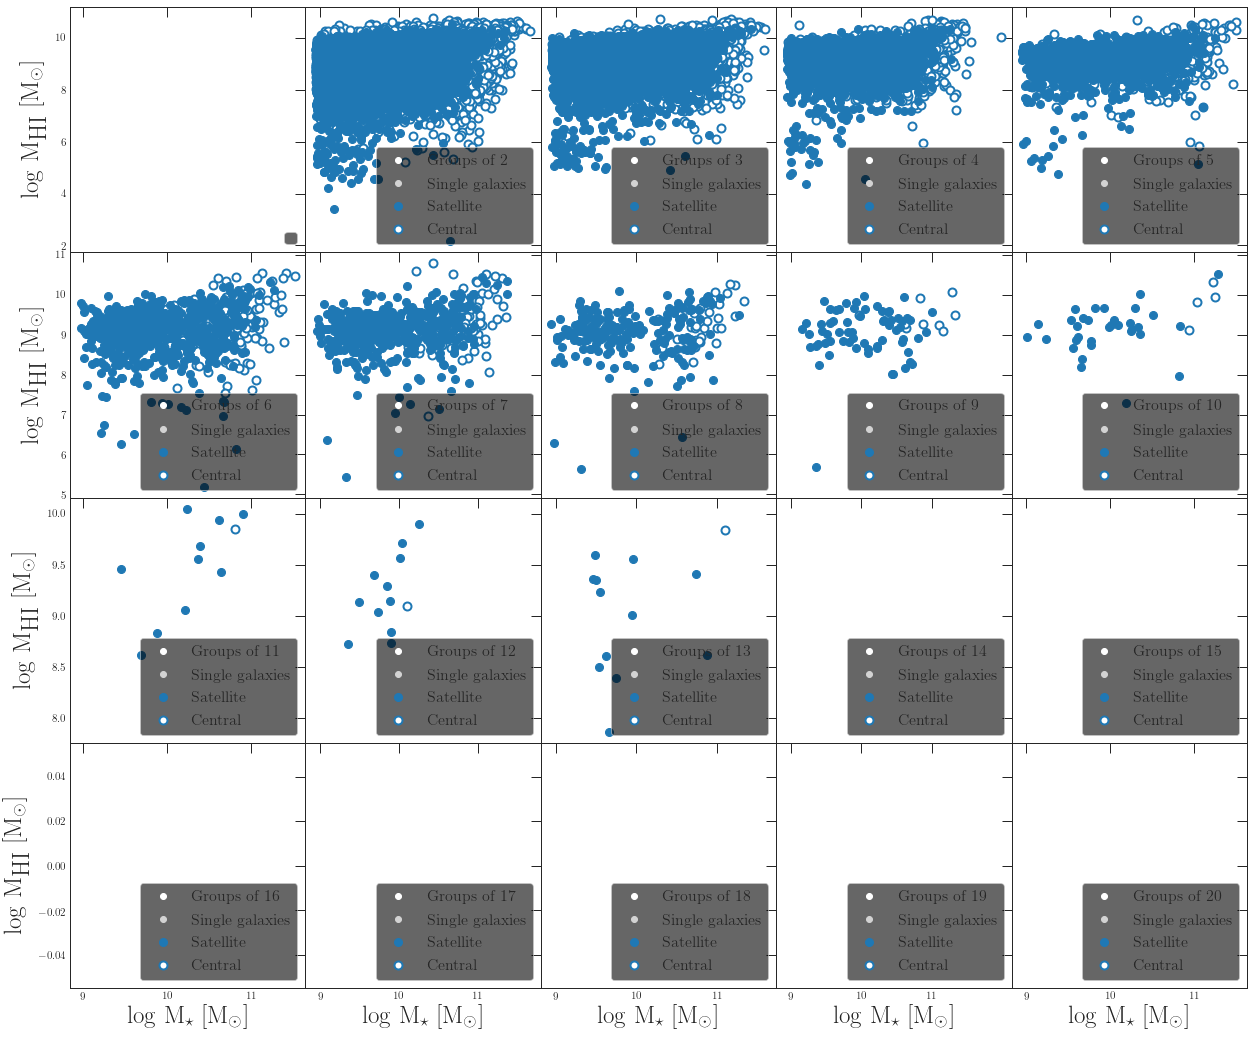

In [275]:
#Use line_profiler to test how fast is each line of the code

#put this line in front of funtion which you are calling:
#%lprun -f mhi_vs_ms_3x3 

mhi_vs_ms_3x3(updated_dict)

# Make a two sided histogram

In [33]:
def two_sided_histogram_group_and_single(x_cen, y_cen, x_sat, y_sat, x_single, y_single):
    """
    Make a scatter plot with 3 datasets and then place histogram on both x and y axis for them. 
    Here I use logMhi vesus logMstar -- other data will need readjustment of the min/max.
    
    Parameters
    ==========
    x_cen, y_cen: x and y values of the first dataset. Floats. Can be list/array. 
                  In this case, I am using logMHI and logMstar of central galaxies.
    
    x_sat, y_sat: x and y values of the second dataset. Floats. Can be list/array. 
                  In this case, I am using logMHI and logMstar of satellite galaxies.
                  
    x_single, y_single: x and y values of the third dataset. Floats. Can be list/array. 
                        In this case, I am using logMHI and logMstar of single (central) galaxies.
                        
        
    Returns
    =======
    A scatter plot with histogram on x and y axis. 
    
    Usage
    =====
    To use type: ``two_sided_histogram_group_and_single(x_cen, y_cen, x_sat, y_sat, x_single, y_single)``
               I extracted single, satellite and central gal from dictionary using ``updated_dict`` and 
               group_size=1 for single galaxies; group_size=2 for pairs -- can be any group_size number
               
                single = updated_dict[1]['Centrals']
                central_2 = updated_dict[2]["Centrals"]
                satellite_2 = updated_dict[2]["Satellites"]
                
                x_cen = np.log10(G["StellarMass"][central_2]*1e10/h ) #gives array of central galaxy stellar masses 
                y_cen = np.log10(G["ColdGas"][central_2]*1e10/h+1) 
                
                etc. just update central_2 with other keys to specific indices.
                
    """

    nullfmt = NullFormatter()         # no labels
    
    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02
    
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]
    
    # start with a rectangular Figure
    plt.figure(1, figsize=(8, 8))
    
    axScatter = plt.axes(rect_scatter)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)
    
    # no labels
    axHistx.xaxis.set_major_formatter(nullfmt)
    axHisty.yaxis.set_major_formatter(nullfmt)
    
    # the scatter plot:
    axScatter.scatter(x_single, y_single, color='#fcc5c0', label='Single galaxies', alpha=0.2)
    axScatter.scatter(x_cen, y_cen, color='white', edgecolor='#1f78b4', linewidth=1, label='Centrals')
    axScatter.scatter(x_sat, y_sat, color='#1f78b4', label='Satellites', alpha=0.8)
    
    axScatter.set_xlabel(r'log M$_{\star}$ [M$_{\odot}$]', fontsize=25)
    axScatter.set_ylabel(r'log M$_{\textrm{HI}}$ [M$_{\odot}$]',fontsize=25)

    # now determine nice limits by hand:
    binwidth = 0.1
    xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(x))])
    lim = (int(xymax/binwidth) + 1) * binwidth
    
    axScatter.set_xlim((8.5, 11.7))
    axScatter.set_ylim((5.8, 11.7))
    
    bins = np.arange(5.8, lim + binwidth, binwidth)
    #density=True -- the result is the value of the probability density function at the bin,
    #                normalized such that the integral over the range is 1 (buggy with uneqyal bin widths)
    axHistx.hist(x_sat, bins=bins, density=True, color='#1f78b4', alpha=0.6, edgecolor='k', linewidth=1)
    axHisty.hist(y_sat, bins=bins, density=True, orientation='horizontal', alpha=0.6, color='#1f78b4', edgecolor='k', linewidth=1.2)
    
    axHistx.hist(x_cen, bins=bins, density=True, color='white',alpha=0.4, edgecolor='#1f78b4', linewidth=1)
    axHisty.hist(y_cen, bins=bins, density=True, orientation='horizontal', color='white', alpha=0.4, edgecolor='#1f78b4', linewidth=2)
    
    axHistx.hist(x_single, bins=bins, density=True, color='#fcc5c0',alpha=0.4, edgecolor='black', linewidth=1)
    axHisty.hist(y_single, bins=bins, density=True, orientation='horizontal', color='#fcc5c0', alpha=0.4, edgecolor='black', linewidth=1)
 

    axHistx.set_ylabel(r'N$_{\textrm{gal}}$', fontsize=22)
    axHisty.set_xlabel(r'N$_{\textrm{gal}}$', fontsize=22)
    
    axHistx.set_xlim(axScatter.get_xlim())
    axHisty.set_ylim(axScatter.get_ylim())

    axScatter.legend(loc=3)


    return plt.show()
    

In [34]:
def two_sided_histogram_groups(x_cen, y_cen, x_sat, y_sat, color='#1f78b4'):
    """

    Make a scatter plot with 2 datasets and then place histogram on both x and y axis for them. 
    Here I use logMhi vesus logMstar -- other data will need readjustment of the min/max.
    
    Parameters
    ==========
    x_cen, y_cen: x and y values of the first dataset. Floats. Can be list/array. 
                  In this case, I am using logMHI and logMstar of central galaxies.
    
    x_sat, y_sat: x and y values of the second dataset. Floats. Can be list/array. 
                  In this case, I am using logMHI and logMstar of satellite galaxies.                        
        
    color : Boolean. Chose color in case you want differen one. If not specified, will be the default one for satellites.
            Use different color in case there is only one dataset, for exaple:
            two_sided_histogram_groups(x, y, [], [], 'grey')
    
    
    Returns
    =======
    A scatter plot with histogram on x and y axis for both datasets. 
    
    Usage
    =====
    To use type: ``two_sided_histogram_groups(x_cen, y_cen, x_sat, y_sat)``
               I extracted satellite and central gal from dictionary using ``updated_dict`` and 
               group_size=2 for pairs -- can be any group_size number
               
                central_2 = updated_dict[2]["Centrals"]
                satellite_2 = updated_dict[2]["Satellites"]
                
                x_cen = np.log10(G["StellarMass"][central_2]*1e10/h ) #gives array of central galaxy stellar masses 
                y_cen = np.log10(G["ColdGas"][central_2]*1e10/h+1) 
                
                etc. just update central_2 with other keys to specific indices.
                
    """

    
    nullfmt = NullFormatter()         # no labels
    
    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02
    
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]
    
    # start with a rectangular Figure
    plt.figure(1, figsize=(8, 8))
    
    axScatter = plt.axes(rect_scatter)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)
    
    # no labels
    axHistx.xaxis.set_major_formatter(nullfmt)
    axHisty.yaxis.set_major_formatter(nullfmt)
    
    # the scatter plot:
    axScatter.scatter(x_cen, y_cen, color='white', edgecolor='#1f78b4', linewidth=1, label='Centrals')
    axScatter.scatter(x_sat, y_sat, color=color, label='Satellites', alpha=0.8)
    
    axScatter.set_xlabel(r'log M$_{\star}$ [M$_{\odot}$]', fontsize=25)
    axScatter.set_ylabel(r'log M$_{\textrm{HI}}$ [M$_{\odot}$]',fontsize=25)

    # now determine nice limits by hand:
    binwidth = 0.1
    xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(x))])
    lim = (int(xymax/binwidth) + 1) * binwidth
    
    axScatter.set_xlim((8.5, 11.7))
    axScatter.set_ylim((5.8, 11.7))
    
    bins = np.arange(5.8, lim + binwidth, binwidth)
    axHistx.hist(x_sat, bins=bins, color=color, alpha=0.6, edgecolor='k', linewidth=1)
    axHisty.hist(y_sat, bins=bins, orientation='horizontal', alpha=0.6, color=color, edgecolor='k', linewidth=1.2)
    
    axHistx.hist(x_cen, bins=bins, color='white',alpha=0.4, edgecolor='#1f78b4', linewidth=1)
    axHisty.hist(y_cen, bins=bins, orientation='horizontal', color='white', alpha=0.4, edgecolor='#1f78b4', linewidth=2) 

    axHistx.set_ylabel(r'N$_{\textrm{gal}}$', fontsize=22)
    axHisty.set_xlabel(r'N$_{\textrm{gal}}$', fontsize=22)
    
    axHistx.set_xlim(axScatter.get_xlim())
    axHisty.set_ylim(axScatter.get_ylim())

    axScatter.legend(loc=3)


    return plt.show()



In [35]:
single = updated_dict[1]['Centrals']
central_2 = updated_dict[2]["Centrals"]
satellite_2 = updated_dict[2]["Satellites"]

x_cen = np.log10(G["StellarMass"][central_2]*1e10/h ) #gives array of central galaxy stellar masses 
y_cen = np.log10(np.sum(G['DiscHI'],axis=1)[central_2]*1e10/h+1) #BECAUSE log0 goes to -inf so I add 1! has to be checked/removed!
x_sat = np.log10(G["StellarMass"][satellite_2]*1e10/h) #gives array of satellite galaxy stellar masses 
y_sat = np.log10(np.sum(G['DiscHI'],axis=1)[satellite_2]*1e10/h+1)

x_single = np.log10(G["StellarMass"][single]*1e10/h) #gives array of satellite galaxy stellar masses 
y_single = np.log10(np.sum(G['DiscHI'],axis=1)[single]*1e10/h+1)


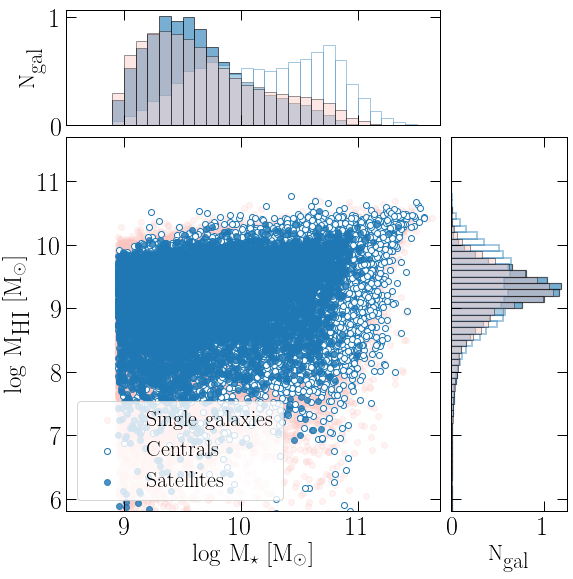

In [36]:
two_sided_histogram_group_and_single(x_cen, y_cen, x_sat, y_sat, x_single, y_single)

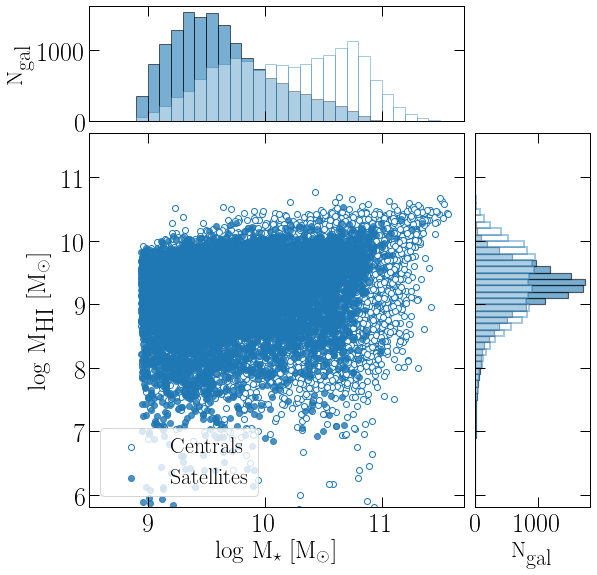

In [37]:
two_sided_histogram_groups(x_cen, y_cen, x_sat, y_sat)

In [38]:
def hist_Mhi_vs_Mstar_with_singles(groups_dict):
    
    """
    N times the scatter plot with thee datasets and their histograms on x and y axis. One dataset is always single galaxies
    the other two datasets are groups of lenght N++
    Here I use logMhi vesus logMstar -- other data will need readjustment of the min/max.
    
    
    Parameters
    ==========
    groups_dict: Dictionary. Keyed by the group size. Use: ``groups_dict[group_size]["Centrals"]``
                 Extracts groups with size N and the satellite & central galaxies
                 Created dictionary from (def create_cen_sat_from_groups_dict)
  
    Returns
    =======
    N times the scatter plot with two datasets and their histograms on x and y axis.
    
    
    Usage
    =====
    To use type: ``hist_Mhi_vs_Mstar_with_singles(updated_dict) ``
                 Where updated_dict is the dictionary that is parsed to plotting function
                 ``updated_dict = create_cen_sat_from_groups_dict(groups, store_cen_indices)``
    
    """
        
    row_count = 0
    for size in trange(1, 9, 1): #I'm planning to have 1-9 sized groups
            
        if size % 3 == 0:
            row_count += 1
        this_ax = ax[row_count, size%3]
        
        group_size = size+1 # Select number of galaxies per group --- adding +1 because it is counting from 0.
    
        central_gals = groups_dict[group_size]["Centrals"]
        sat_gals = groups_dict[group_size]["Satellites"]
        single_gals = groups_dict[1]['Centrals']
     
        # Do plotting of groups of N-length; it will be placed on each figure
        # Centrals and Satellites; x & y axis histogram
        # Using function two_sided_histogram to plot the histogram output so here I call the function and give (x, y), (x, y)
        two_sided_histogram_group_and_single(np.log10(G['StellarMass'][central_gals]*1e10/h),
                            np.log10(np.sum(G['DiscHI'],axis=1)[central_gals]*1e10/h+1), 
                            np.log10(G['StellarMass'][sat_gals]*1e10/h),
                            np.log10(np.sum(G['DiscHI'],axis=1)[sat_gals]*1e10/h+1),
                            np.log10(G['StellarMass'][single_gals]*1e10/h),
                            np.log10(np.sum(G['DiscHI'],axis=1)[single_gals]*1e10/h+1) ) 


  0%|          | 0/8 [00:00<?, ?it/s]

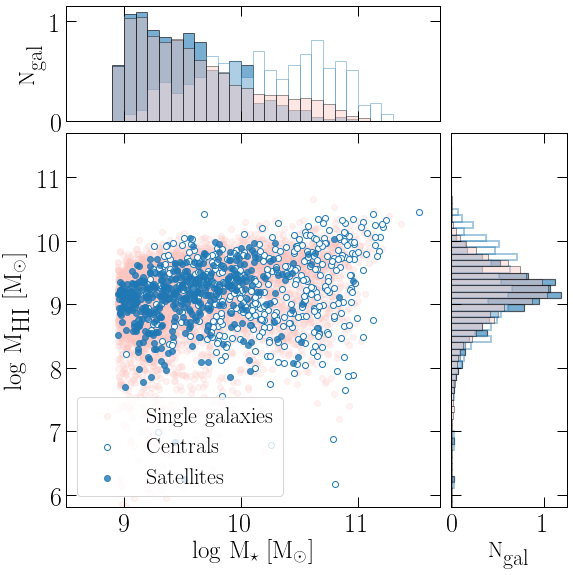

 12%|█▎        | 1/8 [00:00<00:04,  1.42it/s]

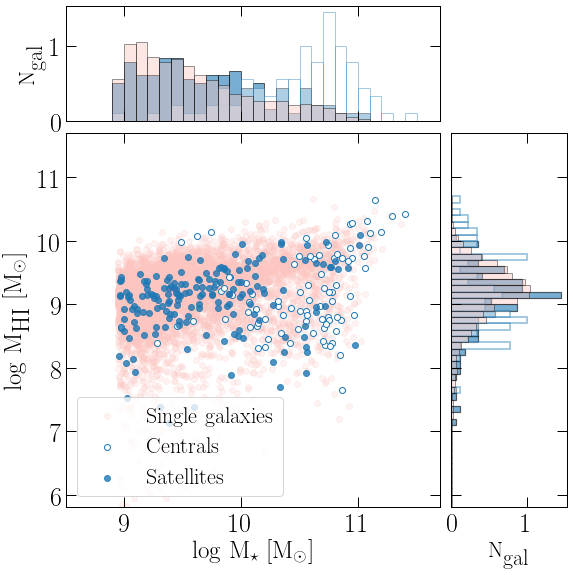

 25%|██▌       | 2/8 [00:01<00:04,  1.32it/s]

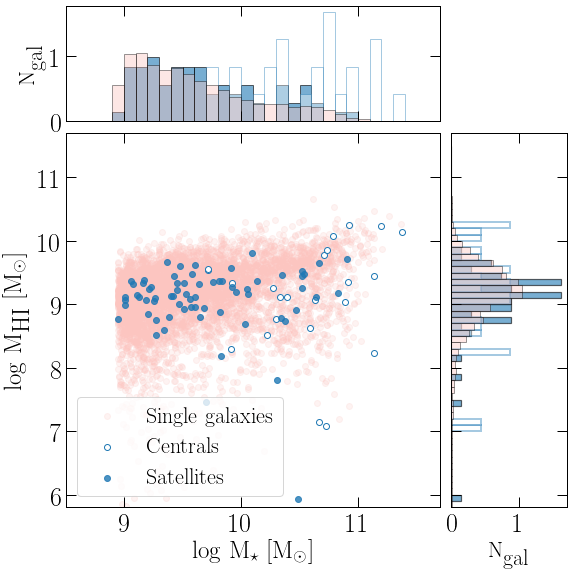

 38%|███▊      | 3/8 [00:02<00:03,  1.36it/s]

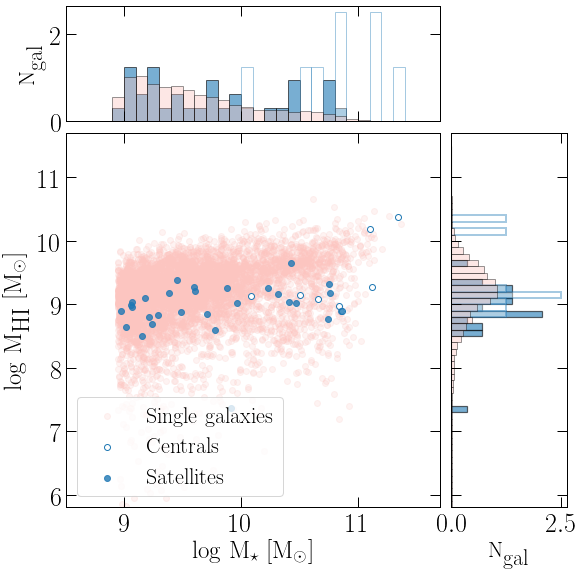

 50%|█████     | 4/8 [00:02<00:02,  1.37it/s]

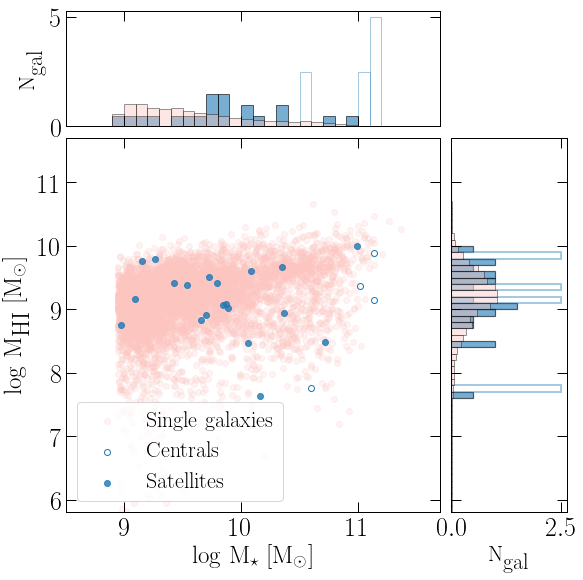

 62%|██████▎   | 5/8 [00:03<00:02,  1.34it/s]

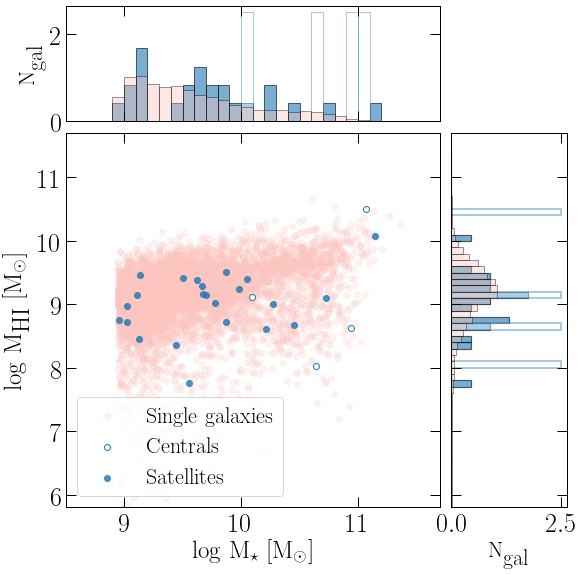

 75%|███████▌  | 6/8 [00:04<00:01,  1.36it/s]

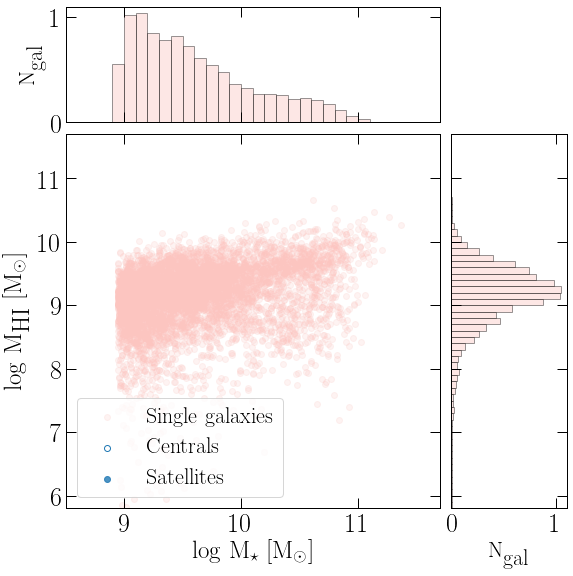

 88%|████████▊ | 7/8 [00:05<00:00,  1.37it/s]

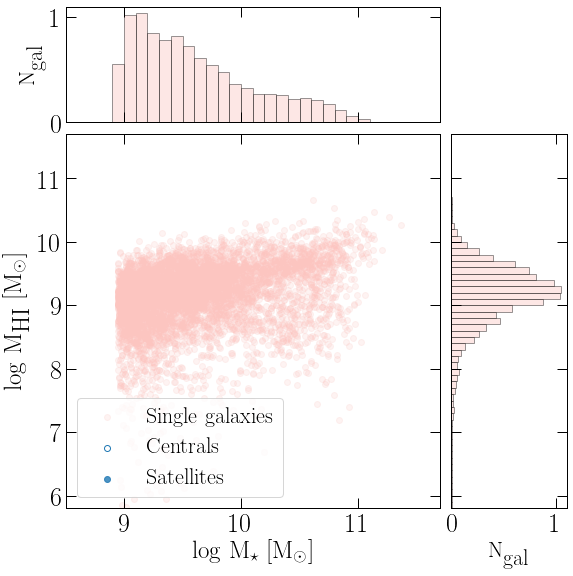

100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


In [54]:
hist_Mhi_vs_Mstar_with_singles(updated_dict)

In [35]:
def hist_Mhi_vs_Mstar(groups_dict):
    
    """
    N times the scatter plot with two datasets and their histograms on x and y axis.
    Two datasets are groups of lenght N++
    Here I use logMhi vesus logMstar -- other data will need readjustment of the min/max.
    
    
    Parameters
    ==========
    groups_dict: Dictionary. Keyed by the group size. Use: ``groups_dict[group_size]["Centrals"]``
                 Extracts groups with size N and the satellite & central galaxies
                 Created dictionary from (def create_cen_sat_from_groups_dict)
  
    Returns
    =======
    N times the scatter plot with two datasets and their histograms on x and y axis.
    
    
    Usage
    =====
    To use type: ``hist_Mhi_vs_Mstar(updated_dict) ``
                 Where updated_dict is the dictionary that is parsed to plotting function
                 ``updated_dict = create_cen_sat_from_groups_dict(groups, store_cen_indices)``
    
    """
       

                
                
    row_count = 0
    for size in trange(1, 9, 1): #I'm planning to have 1-9 sized groups
            
        if size % 3 == 0:
            row_count += 1
        this_ax = ax[row_count, size%3]
        
        group_size = size+1 # Select number of galaxies per group --- adding +1 because it is counting from 0.
    
        central_gals = groups_dict[group_size]["Centrals"]
        sat_gals = groups_dict[group_size]["Satellites"]
        single_gals = groups_dict[1]['Centrals']
     
        # Do plotting of groups of N-length; it will be placed on each figure
        # Centrals and Satellites; x & y axis histogram
        # Using function two_sided_histogram to plot the histogram output so here I call the function and give (x, y), (x, y)
        two_sided_histogram_groups(np.log10(G['StellarMass'][central_gals]*1e10/h),
                            np.log10(np.sum(G['DiscHI'],axis=1)[central_gals]*1e10/h+1), 
                            np.log10(G['StellarMass'][sat_gals]*1e10/h),
                            np.log10(np.sum(G['DiscHI'],axis=1)[sat_gals]*1e10/h+1) ) 


  0%|          | 0/8 [00:00<?, ?it/s]

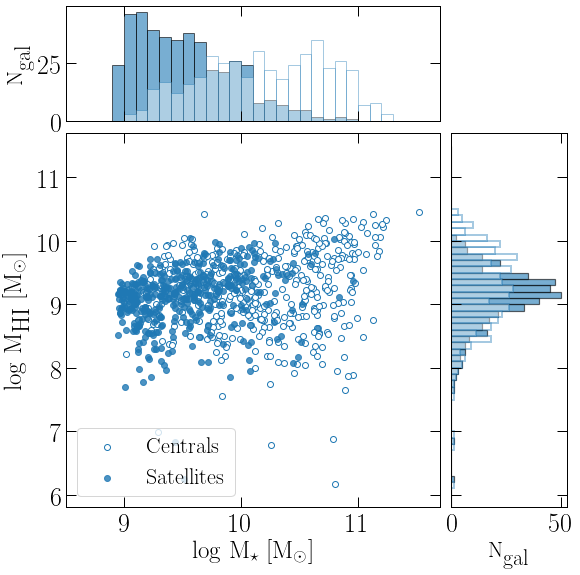

 12%|█▎        | 1/8 [00:00<00:03,  1.96it/s]

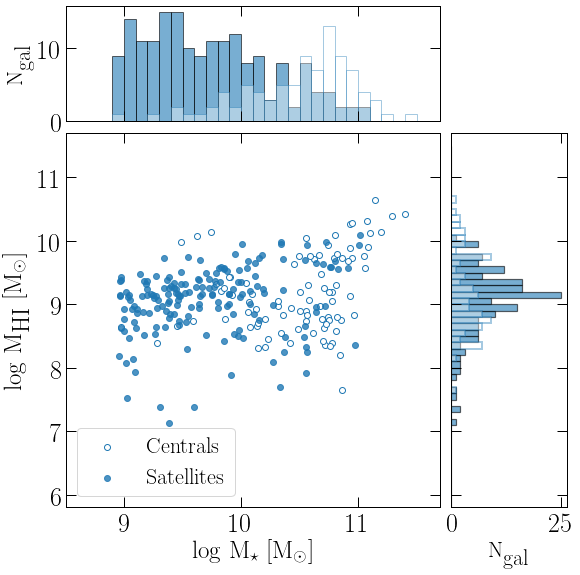

 25%|██▌       | 2/8 [00:01<00:03,  1.99it/s]

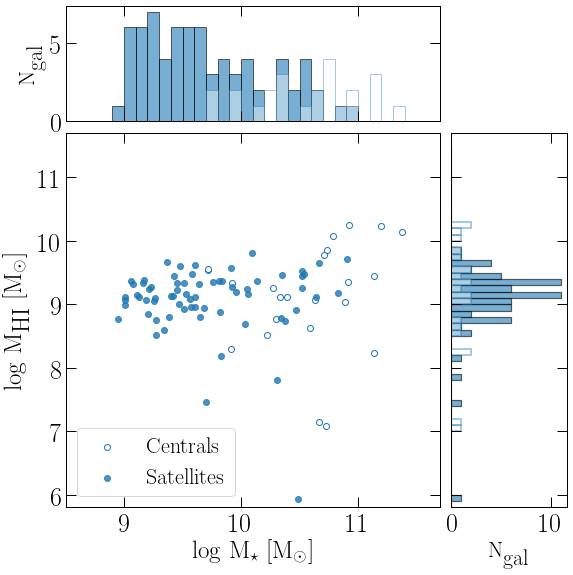

 38%|███▊      | 3/8 [00:01<00:02,  1.87it/s]

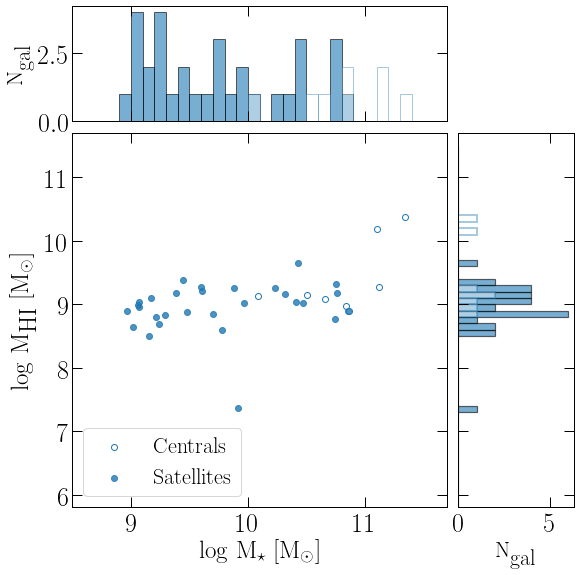

 50%|█████     | 4/8 [00:02<00:02,  1.90it/s]

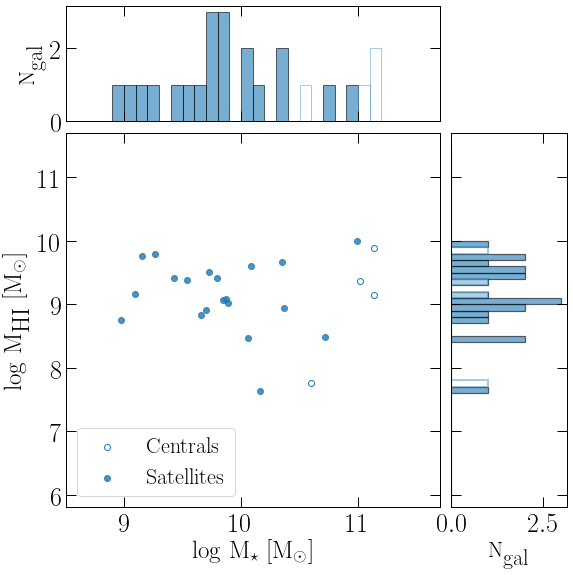

 62%|██████▎   | 5/8 [00:02<00:01,  1.93it/s]

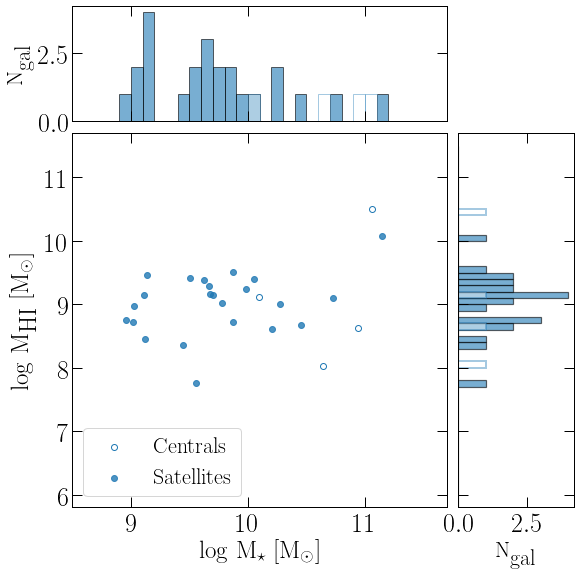

 75%|███████▌  | 6/8 [00:03<00:01,  1.94it/s]

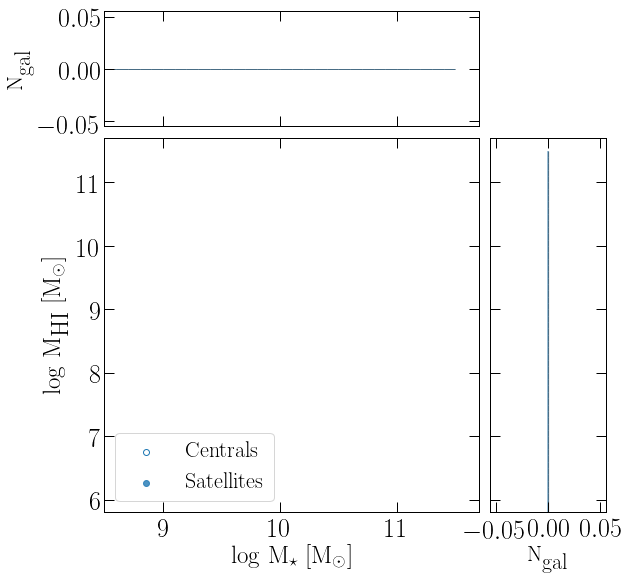

 88%|████████▊ | 7/8 [00:03<00:00,  1.88it/s]

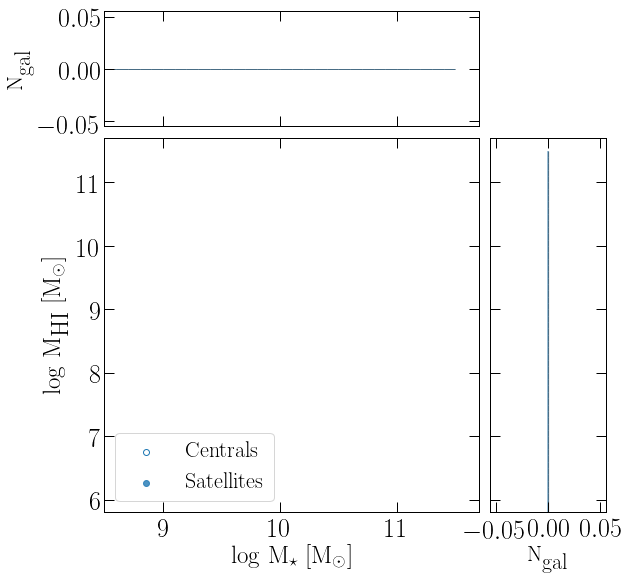

100%|██████████| 8/8 [00:04<00:00,  1.89it/s]


In [56]:
hist_Mhi_vs_Mstar(updated_dict)

# Properties of the group as the whole entity

In [35]:
def two_sided_histogram(x_data, y_data, color='lightgrey', legend=legend, s=90):
    """
    Make a scatter plot with 1 dataset and then place histogram on both x and y axis for them. .
    Here I use logMhi vesus logMstar as the sum values for groups of N length.
    
    Parameters
    ==========
    x_data, y_data: x and y values of the first dataset. Floats. Can be list/array. 
                  In this case, I am using logMHI and logMstar of the sum a group.
    
    color='lightgrey': Default color.
                      This will change when I call a function that has defined its own colors.
    
    legend=legend: Default legend.
                   This will change when I call a function that has defined its own legends.
    
    s=90: Markersize. Default 90.
                This will change when I call a function with its defined markersizes.
   
    Returns
    =======
    A scatter plot with histogram on x and y axis for both datasets. 
    
    Usage
    =====
    To use type: ``two_sided_histogram(x_data, y_data)``
               I extracted satellite and central gal from dictionary using ``updated_dict`` and 
               group_size=2 for pairs -- can be any group_size number
               
                central_2 = updated_dict[2]["Centrals"]
                satellite_2 = updated_dict[2]["Satellites"]
                
                and then sum the x and y properties:
                
                x_sum = np.log10(G["StellarMass"][central_2]*1e10/h +(G["StellarMass"][satellite_2]*1e10/h) ) #gives array of the sum of the stellar masses 
                y_sum = np.log10(G["ColdGas"][central_2]*1e10/h + (G["ColdGas"][satellite_2]*1e10/h+1)) #gives array of the sum of the gas masses
    
                etc. just update central_2 with other keys to specific indices.
                
    """

    
    nullfmt = NullFormatter()         # no labels
    
    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02
    
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]
    
    # start with a rectangular Figure
    plt.figure(1, figsize=(12, 12))
    
    axScatter = plt.axes(rect_scatter)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)
    
    # no labels
    axHistx.xaxis.set_major_formatter(nullfmt)
    axHisty.yaxis.set_major_formatter(nullfmt)
    
    # the scatter plot:
    markersizes=90
    axScatter.scatter(x_data, y_data, color=color, edgecolor='k', s=s, linewidth=0.4, label=legend)
    
    axScatter.set_xlabel(r'log M$_{\star}$ [M$_{\odot}$]', fontsize=25)
    axScatter.set_ylabel(r'log M$_{\textrm{HI}}$ [M$_{\odot}$]',fontsize=25)

    # now determine nice limits by hand:
    binwidth = 0.1
    xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(x))])
    lim = (int(xymax/binwidth) + 1) * binwidth
    
    axScatter.set_xlim((9, 11.8))
    axScatter.set_ylim((7.5, 11.5))
    
    bins = np.arange(7.5, lim + binwidth, binwidth)
    
    axHistx.hist(x_data, bins=bins, color=color,alpha=0.8, edgecolor='k', linewidth=1)
    axHisty.hist(y_data, bins=bins, orientation='horizontal', color=color, alpha=0.8, edgecolor='k', linewidth=1) 

    axHistx.set_ylabel(r'N$_{\textrm{groups}}$', fontsize=22)
    axHisty.set_xlabel(r'N$_{\textrm{groups}}$', fontsize=22)
    
    axHistx.set_xlim(axScatter.get_xlim())
    axHisty.set_ylim(axScatter.get_ylim())
    
    
    legend = axScatter.legend(loc=3, fontsize=18)


    return #plt.show()


### All groups separatelly based on the length
#### Group mass represented as sum of the galaxies which are in the group
#### Takes long on big box

In [38]:
#group_size = 2
#halo_2 = updated_dict[group_size]["All_groups"]
#
#x_values = []
#y_values = []
#
#for each_group in halo_2:
#   #print(each_group)
#    x_sum = np.log10( np.sum((G["StellarMass"][each_group]*1e10/h)) ) #gives array of the sum of the stellar masses 
#    y_sum = np.log10( np.sum((np.sum(G['DiscHI'],axis=1)[each_group]*1e10/h+1)) ) #gives array of the sum of the gas masses
#    x_values.append(x_sum)
#    y_values.append(y_sum)
#    
#    
#two_sided_histogram(x_values, y_values, legend='Group of %.f'%group_size)

    

### All groups together

In [40]:
def hist_group_sum_Mhi_vs_Mstar(groups_dict, colors=['lightgrey','#feebe2','#fcc5c0','#fa9fb5','#f768a1','#dd3497','#ae017e','#7a0177'],
                               legends=['2', '3', '4', '5', '6', '7', '8', '9'], markersizes=[90,150,210,270,330,400,470,540,610]):
    
    """
    N times the scatter plot with dataset and their histograms on x and y axis.
    Datasets are groups of lenght N++
    Here I use logMhi vesus logMstar -- the sum values for the entire group
    
    
    Parameters
    ==========
    groups_dict: Dictionary. Keyed by the group size. Use: ``groups_dict[group_size]["Centrals"]``
                 Extracts groups with size N and the satellite & central galaxies
                 Created dictionary from (def create_cen_sat_from_groups_dict)
  
    colors=['r', 'b' ... ]: List of colors. To be replaced with default ones in two_sided_histogram.
                Here is used list of lenght 8 because I'm plotting N sized groups where N 2-9
    
    legends=['2', '3', '4', '5', '6', '7', '8', '9']: List of legends. To be places as a length of each group.
            Here is used list of lenght 8 because I'm plotting N sized groups where N 2-9
    
    markersizes=[90,150,210,270,330,400,470,540,610]: Array of integers. 
                Replaces the markersize for each iteration.
    
    Returns
    =======
    N times the scatter plot with dataset as a sum of the masses and their histograms on x and y axis.
    
    
    Usage
    =====
    To use type: ``hist_group_sum_Mhi_vs_Mstar(updated_dict) ``
                 Where updated_dict is the dictionary that is parsed to plotting function
                 ``updated_dict = create_cen_sat_from_groups_dict(groups, store_cen_indices)``
    
    """
       

    for size in trange(1, 9, 1): #I'm planning to have 1-9 sized groups

        group_size = size+1 # Select number of galaxies per group --- adding +1 because it is counting from 0.

        halo_groups = updated_dict[group_size]["All_groups"]
        
        x_values = []
        y_values = []

        for each_group in halo_groups:
        #print(each_group)
            x_sum = np.log10( np.sum((G["StellarMass"][each_group]*1e10/h)) ) #gives array of the sum of the stellar masses 
            y_sum = np.log10( np.sum((np.sum(G['DiscHI'],axis=1)[each_group]*1e10/h+1)) ) #gives array of the sum of the gas masses
            x_values.append(x_sum)
            y_values.append(y_sum)
        
        # Do plotting of groups of N-length; it will be placed on each figure
        # Centrals and Satellites; x & y axis histogram
        # Using function two_sided_histogram to plot the histogram output so here I call the function and give (x, y), (x, y)
        two_sided_histogram(x_values, y_values, colors[size-1], legends[size-1], markersizes[size-1]) # Call the function with specified colors to have different colors for each group.
                            
         


100%|██████████| 8/8 [00:01<00:00,  6.38it/s]


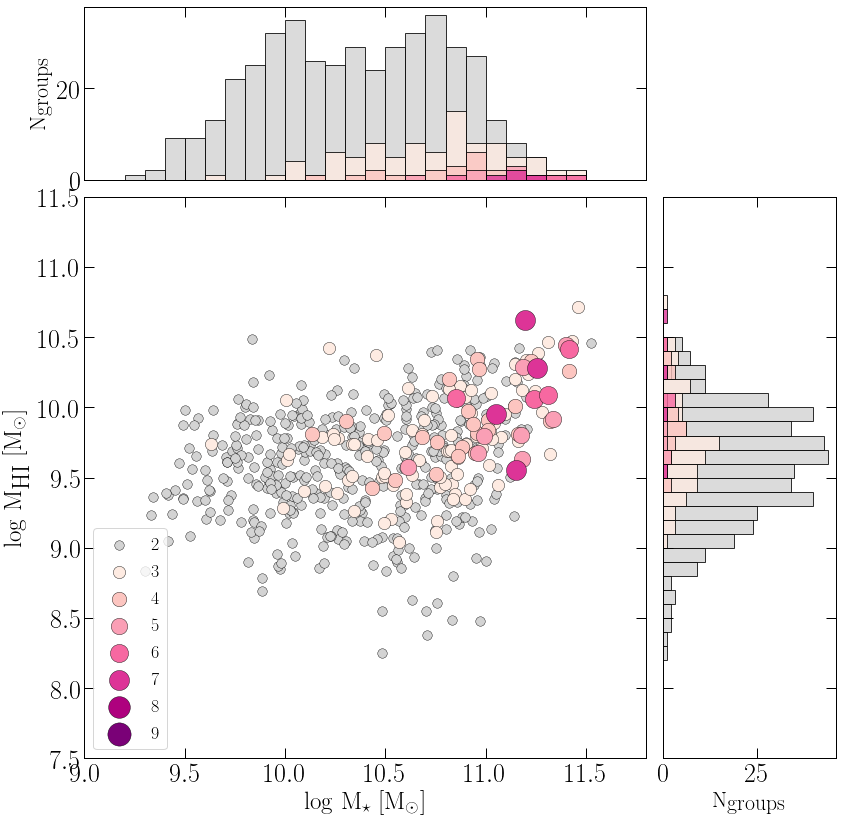

In [60]:
hist_group_sum_Mhi_vs_Mstar(updated_dict)

In [61]:
def histogram_wrapper(dataset_length):
    """
    """
    
    if dataset_length == 1:
        hist_group_sum_Mhi_vs_Mstar(updated_dict)
    elif dataset_length ==2:
        hist_Mhi_vs_Mstar(updated_dict)
    elif dataset_length == 3:
        hist_Mhi_vs_Mstar_with_singles(updated_dict)
    else:# Check for funky stuff and raise an error
        print("Wrong dataset length. Dataset length should be: 1, 2 or 3.")
        raise ValueError

# Use dictionary based on "Groups" which also has info abour cen/sat
## Find where central galaxy is the most gas rich galaxy in each group

In [41]:
#Use dictionary and for each galaxy in "Groups" of 3 show central/satellite index

richer_central_ind = []
poorer_central_ind = []

richer_sat_ind = []
poorer_sat_ind = []

Grp_length = 5

for group_key in tqdm(updated_dict[Grp_length]["Groups"].keys()):
    central_idx = updated_dict[Grp_length]["Groups"][group_key]["Centrals"] #give indices
    central_mass = np.sum(G['DiscHI'],axis=1)[central_idx] #give masses of these galaxies
    
    satellite_inds = updated_dict[Grp_length]["Groups"][group_key]["Satellites"]
    sat_mass = np.sum(G['DiscHI'],axis=1)[satellite_inds]
    
    if (central_mass > sat_mass).all(): #check conditions
        print("Central is the most HI massive")
        richer_central_ind.append(central_idx)
        richer_sat_ind.append(satellite_inds)
    else:
        print("Satellite is more HI massive thatn central")
        poorer_central_ind.append(central_idx)
        poorer_sat_ind.append(satellite_inds)
    #print(sat_mass > central_mass)
    
    print("Central mass is {0} and sat masses are {1}".format(central_mass, sat_mass))
    print("")


  0%|          | 1/221 [00:00<00:53,  4.08it/s]

Satellite is more HI massive thatn central
Central mass is [0.02525776] and sat masses are [0.17878714 0.16653726 0.10838641 0.03341049]



  1%|          | 2/221 [00:00<00:53,  4.11it/s]

Satellite is more HI massive thatn central
Central mass is [0.03052512] and sat masses are [0.04083839 0.08915862 0.19291507 0.09674514]



  1%|▏         | 3/221 [00:00<00:52,  4.12it/s]

Satellite is more HI massive thatn central
Central mass is [0.09009381] and sat masses are [0.08833817 0.14157051 0.02869059 0.35536572]



  2%|▏         | 4/221 [00:00<00:52,  4.13it/s]

Satellite is more HI massive thatn central
Central mass is [0.06967121] and sat masses are [0.         0.08883527 0.30865377 0.09829376]



  2%|▏         | 5/221 [00:01<00:52,  4.13it/s]

Satellite is more HI massive thatn central
Central mass is [0.10447558] and sat masses are [0.10578112 0.09808733 0.2617439  0.09028433]



  3%|▎         | 6/221 [00:01<00:52,  4.13it/s]

Satellite is more HI massive thatn central
Central mass is [0.00077251] and sat masses are [0.48102918 0.         0.18024984 0.09332772]



  3%|▎         | 7/221 [00:01<00:51,  4.13it/s]

Satellite is more HI massive thatn central
Central mass is [0.05457867] and sat masses are [0.13787876 0.02395521 0.13179173 0.00617263]



  4%|▎         | 8/221 [00:01<00:51,  4.14it/s]

Satellite is more HI massive thatn central
Central mass is [0.01802048] and sat masses are [0.11816201 0.         0.24572852 0.1459961 ]



  4%|▍         | 9/221 [00:02<00:51,  4.14it/s]

Central is the most HI massive
Central mass is [0.31997618] and sat masses are [0.01253055 0.07244299 0.05799173 0.12501211]



  5%|▍         | 10/221 [00:02<00:50,  4.14it/s]

Satellite is more HI massive thatn central
Central mass is [0.08133414] and sat masses are [0.39142007 0.04485349 0.22801282 0.20374721]



  5%|▍         | 11/221 [00:02<00:50,  4.14it/s]

Central is the most HI massive
Central mass is [0.27666175] and sat masses are [0.13757673 0.03255049 0.14397895 0.19219917]



  5%|▌         | 12/221 [00:02<00:50,  4.14it/s]

Satellite is more HI massive thatn central
Central mass is [0.09533025] and sat masses are [0.01296719 0.3701811  0.28168023 0.01591463]



  6%|▌         | 13/221 [00:03<00:50,  4.14it/s]

Satellite is more HI massive thatn central
Central mass is [0.05691377] and sat masses are [0.32321888 0.1718573  0.16652198 0.10830485]



  6%|▋         | 14/221 [00:03<00:49,  4.14it/s]

Satellite is more HI massive thatn central
Central mass is [0.01176727] and sat masses are [0.03536265 0.0346646  0.10701909 0.01006524]



  7%|▋         | 15/221 [00:03<00:49,  4.14it/s]

Central is the most HI massive
Central mass is [1.6712978] and sat masses are [0.06262602 0.94100165 0.15497059 0.13106176]



  7%|▋         | 16/221 [00:03<00:49,  4.14it/s]

Satellite is more HI massive thatn central
Central mass is [0.0476294] and sat masses are [0.00397332 0.15927412 0.15753375 0.03837953]



  8%|▊         | 17/221 [00:04<00:49,  4.14it/s]

Satellite is more HI massive thatn central
Central mass is [0.03377172] and sat masses are [0.54630077 0.39453804 0.12438756 0.03153289]



  8%|▊         | 18/221 [00:04<00:48,  4.14it/s]

Satellite is more HI massive thatn central
Central mass is [0.28751895] and sat masses are [0.00067189 0.03165691 0.5368295  0.        ]



  9%|▊         | 19/221 [00:04<00:48,  4.14it/s]

Satellite is more HI massive thatn central
Central mass is [0.26996592] and sat masses are [0.4917267  0.00454259 0.22161281 0.63637596]



  9%|▉         | 20/221 [00:04<00:48,  4.14it/s]

Satellite is more HI massive thatn central
Central mass is [0.01769748] and sat masses are [0.22770402 0.04664763 0.05942625 0.12731259]



 10%|▉         | 21/221 [00:05<00:48,  4.14it/s]

Satellite is more HI massive thatn central
Central mass is [0.08083637] and sat masses are [1.1838452  0.2945251  0.2939971  0.12523168]



 10%|▉         | 22/221 [00:05<00:48,  4.14it/s]

Central is the most HI massive
Central mass is [0.49773788] and sat masses are [0.07979968 0.14986534 0.07423175 0.0644744 ]



 10%|█         | 23/221 [00:05<00:47,  4.15it/s]

Satellite is more HI massive thatn central
Central mass is [0.14447272] and sat masses are [0.11928869 0.11007548 0.2348831  0.15117034]



 11%|█         | 24/221 [00:05<00:47,  4.15it/s]

Central is the most HI massive
Central mass is [0.15848784] and sat masses are [0.11527936 0.06770575 0.04158999 0.04297843]



 11%|█▏        | 25/221 [00:06<00:47,  4.15it/s]

Satellite is more HI massive thatn central
Central mass is [0.05693585] and sat masses are [0.02268643 0.         0.09711118 0.04078393]



 12%|█▏        | 26/221 [00:06<00:47,  4.15it/s]

Satellite is more HI massive thatn central
Central mass is [0.02249959] and sat masses are [0.09687182 0.16352125 0.20218138 0.11560037]



 12%|█▏        | 27/221 [00:06<00:46,  4.15it/s]

Satellite is more HI massive thatn central
Central mass is [0.24496487] and sat masses are [0.08653034 0.11816407 0.37661335 0.07039859]



 13%|█▎        | 28/221 [00:06<00:46,  4.15it/s]

Satellite is more HI massive thatn central
Central mass is [0.08865449] and sat masses are [0.11518912 0.17908818 0.09676921 0.02836199]



 13%|█▎        | 29/221 [00:06<00:46,  4.15it/s]

Satellite is more HI massive thatn central
Central mass is [0.00333354] and sat masses are [0.17624211 0.         0.11196771 0.12821393]



 14%|█▎        | 30/221 [00:07<00:46,  4.15it/s]

Satellite is more HI massive thatn central
Central mass is [0.05994931] and sat masses are [0.6860721  0.         0.22240642 0.03364736]



 14%|█▍        | 31/221 [00:07<00:45,  4.15it/s]

Central is the most HI massive
Central mass is [0.44125023] and sat masses are [3.1319734e-02 7.8856319e-02 4.0846568e-01 5.1160750e-05]



 14%|█▍        | 32/221 [00:07<00:45,  4.15it/s]

Satellite is more HI massive thatn central
Central mass is [0.01625071] and sat masses are [0.         0.5502531  0.29989508 0.1383083 ]



 15%|█▍        | 33/221 [00:07<00:45,  4.15it/s]

Central is the most HI massive
Central mass is [1.8815515] and sat masses are [0.01011319 0.21894565 0.20739445 0.38975444]



 15%|█▌        | 34/221 [00:08<00:45,  4.15it/s]

Central is the most HI massive
Central mass is [0.511691] and sat masses are [0.04131136 0.08846694 0.21034908 0.27575   ]



 16%|█▌        | 35/221 [00:08<00:44,  4.15it/s]

Satellite is more HI massive thatn central
Central mass is [0.04364499] and sat masses are [0.43829414 0.12610671 0.12806721 0.09217368]



 16%|█▋        | 36/221 [00:08<00:44,  4.15it/s]

Satellite is more HI massive thatn central
Central mass is [0.21337047] and sat masses are [0.24526197 0.01808289 0.10696922 0.03801278]



 17%|█▋        | 37/221 [00:08<00:44,  4.15it/s]

Satellite is more HI massive thatn central
Central mass is [0.01987863] and sat masses are [0.08550071 0.10800907 0.04149425 0.72761124]



 17%|█▋        | 38/221 [00:09<00:44,  4.15it/s]

Satellite is more HI massive thatn central
Central mass is [0.12153271] and sat masses are [0.20940678 0.14037919 0.17333321 0.15628377]



 18%|█▊        | 39/221 [00:09<00:43,  4.15it/s]

Satellite is more HI massive thatn central
Central mass is [0.06078285] and sat masses are [0.1200311  0.11541471 0.16736522 0.06969226]



 18%|█▊        | 40/221 [00:09<00:43,  4.15it/s]

Satellite is more HI massive thatn central
Central mass is [0.09378913] and sat masses are [0.34080386 0.15408947 0.03683728 0.13496903]



 19%|█▊        | 41/221 [00:09<00:43,  4.15it/s]

Satellite is more HI massive thatn central
Central mass is [0.] and sat masses are [0.20932932 0.15805918 0.5678493  0.12059408]



 19%|█▉        | 42/221 [00:10<00:43,  4.15it/s]

Satellite is more HI massive thatn central
Central mass is [0.28288865] and sat masses are [0.01114924 0.38810492 0.01616061 0.05493874]



 19%|█▉        | 43/221 [00:10<00:42,  4.15it/s]

Central is the most HI massive
Central mass is [0.23245373] and sat masses are [0.         0.07253541 0.1289179  0.10710479]



 20%|█▉        | 44/221 [00:10<00:42,  4.15it/s]

Satellite is more HI massive thatn central
Central mass is [0.0325265] and sat masses are [0.         0.16079247 0.02186263 0.2594812 ]



 20%|██        | 45/221 [00:10<00:42,  4.15it/s]

Satellite is more HI massive thatn central
Central mass is [0.34675097] and sat masses are [0.47739333 0.38949737 0.0540459  0.        ]



 21%|██        | 46/221 [00:11<00:42,  4.15it/s]

Satellite is more HI massive thatn central
Central mass is [0.04898089] and sat masses are [0.07588825 0.00948912 0.28299007 0.45781124]



 21%|██▏       | 47/221 [00:11<00:41,  4.15it/s]

Satellite is more HI massive thatn central
Central mass is [0.15231895] and sat masses are [0.07708893 0.03591346 0.40578607 0.        ]



 22%|██▏       | 48/221 [00:11<00:41,  4.14it/s]

Satellite is more HI massive thatn central
Central mass is [0.07460503] and sat masses are [0.02215701 0.19342083 0.08170013 0.12538344]



 22%|██▏       | 49/221 [00:11<00:41,  4.14it/s]

Satellite is more HI massive thatn central
Central mass is [0.3475153] and sat masses are [0.45019662 0.00214427 0.09849741 0.24357405]



 23%|██▎       | 50/221 [00:12<00:41,  4.14it/s]

Central is the most HI massive
Central mass is [2.3631434] and sat masses are [0.03009459 0.00517962 0.23573788 0.10453655]



 23%|██▎       | 51/221 [00:12<00:41,  4.14it/s]

Satellite is more HI massive thatn central
Central mass is [0.01546785] and sat masses are [0.4205337  0.08368844 0.05509218 0.        ]



 24%|██▎       | 52/221 [00:12<00:40,  4.14it/s]

Satellite is more HI massive thatn central
Central mass is [0.02237697] and sat masses are [0.24274336 0.11409886 0.375026   0.6227297 ]



 24%|██▍       | 53/221 [00:12<00:40,  4.14it/s]

Satellite is more HI massive thatn central
Central mass is [0.15435901] and sat masses are [0.14258057 0.12647207 0.18831065 0.08038685]



 24%|██▍       | 54/221 [00:13<00:40,  4.14it/s]

Satellite is more HI massive thatn central
Central mass is [0.] and sat masses are [0.02235735 0.24241619 0.08839245 0.05159992]



 25%|██▍       | 55/221 [00:13<00:40,  4.14it/s]

Satellite is more HI massive thatn central
Central mass is [0.05937855] and sat masses are [0.63957393 0.16269986 0.09088041 0.03152803]



 25%|██▌       | 56/221 [00:13<00:39,  4.14it/s]

Satellite is more HI massive thatn central
Central mass is [0.07061531] and sat masses are [0.16770408 0.09644639 0.07837945 0.5419129 ]



 26%|██▌       | 57/221 [00:13<00:39,  4.14it/s]

Satellite is more HI massive thatn central
Central mass is [0.02934888] and sat masses are [0.00572436 0.4826662  0.01917415 0.01014637]



 26%|██▌       | 58/221 [00:14<00:39,  4.14it/s]

Central is the most HI massive
Central mass is [0.45361063] and sat masses are [0.31204265 0.2120037  0.05779444 0.04896774]



 27%|██▋       | 59/221 [00:14<00:39,  4.14it/s]

Satellite is more HI massive thatn central
Central mass is [0.004044] and sat masses are [0.07408688 0.09588774 0.00339358 0.10977114]



 27%|██▋       | 60/221 [00:14<00:38,  4.14it/s]

Satellite is more HI massive thatn central
Central mass is [0.07786915] and sat masses are [0.08391294 0.         0.         0.3769161 ]



 28%|██▊       | 61/221 [00:14<00:38,  4.14it/s]

Central is the most HI massive
Central mass is [1.0923547] and sat masses are [0.16162544 0.03365732 0.         0.00255814]



 28%|██▊       | 62/221 [00:14<00:38,  4.14it/s]

Central is the most HI massive
Central mass is [0.21187857] and sat masses are [0.120894   0.06704682 0.09461846 0.02521455]



 29%|██▊       | 63/221 [00:15<00:38,  4.14it/s]

Central is the most HI massive
Central mass is [1.3695369] and sat masses are [0.00482324 0.05549329 0.25283805 0.7420851 ]



 29%|██▉       | 64/221 [00:15<00:37,  4.14it/s]

Satellite is more HI massive thatn central
Central mass is [0.06005391] and sat masses are [0.7447789  0.09005586 0.06487887 0.07687813]



 29%|██▉       | 65/221 [00:15<00:37,  4.14it/s]

Satellite is more HI massive thatn central
Central mass is [0.06600706] and sat masses are [0.08134024 1.1014097  0.         0.07998803]



 30%|██▉       | 66/221 [00:15<00:37,  4.14it/s]

Satellite is more HI massive thatn central
Central mass is [0.16486613] and sat masses are [0.19554763 0.4279075  0.02613408 0.00302878]



 30%|███       | 67/221 [00:16<00:37,  4.14it/s]

Central is the most HI massive
Central mass is [0.54884696] and sat masses are [0.1039644 0.1878778 0.1112776 0.0258919]



 31%|███       | 68/221 [00:16<00:37,  4.13it/s]

Satellite is more HI massive thatn central
Central mass is [0.03820499] and sat masses are [0.27559382 0.11460382 0.11077797 0.08862038]



 31%|███       | 69/221 [00:16<00:36,  4.13it/s]

Satellite is more HI massive thatn central
Central mass is [0.11541112] and sat masses are [1.4724138e-01 1.7429414e-01 5.3293899e-02 2.0313220e-05]



 32%|███▏      | 70/221 [00:16<00:36,  4.13it/s]

Central is the most HI massive
Central mass is [0.16819613] and sat masses are [0.09516942 0.12137933 0.11999397 0.11448333]



 32%|███▏      | 71/221 [00:17<00:36,  4.13it/s]

Central is the most HI massive
Central mass is [1.1133417] and sat masses are [0.33971548 0.53488773 0.1966972  0.28728187]



 33%|███▎      | 72/221 [00:17<00:36,  4.13it/s]

Satellite is more HI massive thatn central
Central mass is [0.11625388] and sat masses are [0.7017814  0.13675825 0.04935553 0.10521915]



 33%|███▎      | 73/221 [00:17<00:35,  4.13it/s]

Central is the most HI massive
Central mass is [0.14843762] and sat masses are [0.11618721 0.00645886 0.1330695  0.09443983]



 33%|███▎      | 74/221 [00:17<00:35,  4.13it/s]

Satellite is more HI massive thatn central
Central mass is [0.18810102] and sat masses are [0.03851168 0.06176613 0.04549228 0.29553226]



 34%|███▍      | 75/221 [00:18<00:35,  4.13it/s]

Central is the most HI massive
Central mass is [0.24880129] and sat masses are [0.         0.11279485 0.02925344 0.        ]



 34%|███▍      | 76/221 [00:18<00:35,  4.13it/s]

Satellite is more HI massive thatn central
Central mass is [0.04279143] and sat masses are [0.00755297 0.03242907 0.         0.39532977]



 35%|███▍      | 77/221 [00:18<00:34,  4.13it/s]

Central is the most HI massive
Central mass is [3.7515662] and sat masses are [0.14306709 0.19507888 0.309878   0.22331625]



 35%|███▌      | 78/221 [00:18<00:34,  4.13it/s]

Satellite is more HI massive thatn central
Central mass is [0.0461162] and sat masses are [0.05909311 0.08311978 0.         0.11681046]



 36%|███▌      | 79/221 [00:19<00:34,  4.13it/s]

Central is the most HI massive
Central mass is [0.584848] and sat masses are [0.142352   0.21113133 0.01571829 0.        ]



 36%|███▌      | 80/221 [00:19<00:34,  4.13it/s]

Satellite is more HI massive thatn central
Central mass is [0.1500171] and sat masses are [0.21279283 0.24695735 0.086514   0.17173903]



 37%|███▋      | 81/221 [00:19<00:33,  4.13it/s]

Satellite is more HI massive thatn central
Central mass is [0.40240827] and sat masses are [0.716679   0.16830243 0.20254344 0.02226512]



 37%|███▋      | 82/221 [00:19<00:33,  4.13it/s]

Satellite is more HI massive thatn central
Central mass is [0.05234684] and sat masses are [0.0454946  0.07610349 0.0133305  0.07154363]



 38%|███▊      | 83/221 [00:20<00:33,  4.13it/s]

Satellite is more HI massive thatn central
Central mass is [0.11786251] and sat masses are [8.2452178e-02 4.0405467e-02 1.0420859e+00 1.7496599e-05]



 38%|███▊      | 84/221 [00:20<00:33,  4.13it/s]

Satellite is more HI massive thatn central
Central mass is [0.11385038] and sat masses are [0.29625332 0.31322595 0.28378886 0.11942832]



 38%|███▊      | 85/221 [00:20<00:32,  4.13it/s]

Central is the most HI massive
Central mass is [0.23038395] and sat masses are [0.         0.         0.13882957 0.02539939]



 39%|███▉      | 86/221 [00:20<00:32,  4.13it/s]

Central is the most HI massive
Central mass is [0.12707174] and sat masses are [0.04739688 0.05883799 0.09213579 0.01068622]



 39%|███▉      | 87/221 [00:21<00:32,  4.13it/s]

Satellite is more HI massive thatn central
Central mass is [0.05482671] and sat masses are [0.04060195 0.         0.23850738 0.10679265]



 40%|███▉      | 88/221 [00:21<00:32,  4.13it/s]

Satellite is more HI massive thatn central
Central mass is [0.13465059] and sat masses are [1.4143501e-05 1.0354541e-01 6.9124870e-02 1.4007051e-01]



 40%|████      | 89/221 [00:21<00:31,  4.13it/s]

Satellite is more HI massive thatn central
Central mass is [0.10622561] and sat masses are [0.06631079 0.11286538 0.0533715  0.11269472]



 41%|████      | 90/221 [00:21<00:31,  4.13it/s]

Satellite is more HI massive thatn central
Central mass is [0.10662238] and sat masses are [0.21597607 0.1602014  0.         0.1124879 ]



 41%|████      | 91/221 [00:22<00:31,  4.12it/s]

Satellite is more HI massive thatn central
Central mass is [0.14560911] and sat masses are [0.39783207 0.20131913 0.30226463 0.13909626]



 42%|████▏     | 92/221 [00:22<00:31,  4.11it/s]

Satellite is more HI massive thatn central
Central mass is [0.04290732] and sat masses are [0.03364993 0.8769644  0.12143594 0.0331386 ]



 42%|████▏     | 93/221 [00:22<00:31,  4.08it/s]

Central is the most HI massive
Central mass is [0.5949507] and sat masses are [0.10326842 0.         0.1474466  0.52689093]



 43%|████▎     | 94/221 [00:23<00:31,  4.06it/s]

Satellite is more HI massive thatn central
Central mass is [0.05807244] and sat masses are [0.00120172 0.28272542 0.02448309 0.0539743 ]



 43%|████▎     | 95/221 [00:23<00:31,  4.04it/s]

Satellite is more HI massive thatn central
Central mass is [0.03267853] and sat masses are [0.93443024 0.19365537 0.03540487 0.17196722]



 43%|████▎     | 96/221 [00:23<00:30,  4.05it/s]

Satellite is more HI massive thatn central
Central mass is [0.0189469] and sat masses are [0.08936647 0.06597771 0.12183413 0.00888702]



 44%|████▍     | 97/221 [00:23<00:30,  4.05it/s]

Central is the most HI massive
Central mass is [0.46193114] and sat masses are [0.15322258 0.05647408 0.10066468 0.17984164]



 44%|████▍     | 98/221 [00:24<00:30,  4.05it/s]

Satellite is more HI massive thatn central
Central mass is [0.04711891] and sat masses are [0.03391364 0.0326115  0.09542067 0.10512161]



 45%|████▍     | 99/221 [00:24<00:30,  4.05it/s]

Satellite is more HI massive thatn central
Central mass is [0.12317318] and sat masses are [0.04022393 0.04297572 0.03705543 0.13062996]



 45%|████▌     | 100/221 [00:24<00:29,  4.05it/s]

Satellite is more HI massive thatn central
Central mass is [0.12401161] and sat masses are [0.05507575 0.01837326 0.14768818 0.        ]



 46%|████▌     | 101/221 [00:24<00:29,  4.05it/s]

Central is the most HI massive
Central mass is [2.714172] and sat masses are [0.02063026 0.23890865 0.05298524 0.2629494 ]



 46%|████▌     | 102/221 [00:25<00:29,  4.05it/s]

Satellite is more HI massive thatn central
Central mass is [0.08088401] and sat masses are [0.181987   0.04504477 0.23895773 0.17345537]



 47%|████▋     | 103/221 [00:25<00:29,  4.05it/s]

Satellite is more HI massive thatn central
Central mass is [0.10379527] and sat masses are [0.00268431 0.41035664 0.19544418 0.16296513]



 47%|████▋     | 104/221 [00:25<00:28,  4.05it/s]

Central is the most HI massive
Central mass is [0.13842034] and sat masses are [0.04837475 0.         0.0762755  0.07055643]



 48%|████▊     | 105/221 [00:25<00:28,  4.05it/s]

Satellite is more HI massive thatn central
Central mass is [0.05478747] and sat masses are [0.28658378 0.31763637 0.22847573 0.05594781]



 48%|████▊     | 106/221 [00:26<00:28,  4.05it/s]

Satellite is more HI massive thatn central
Central mass is [0.0388469] and sat masses are [0.44195065 0.4913332  0.14607422 0.15197793]



 48%|████▊     | 107/221 [00:26<00:28,  4.05it/s]

Satellite is more HI massive thatn central
Central mass is [0.22850208] and sat masses are [0.29944554 0.01604243 0.0783668  0.04137142]



 49%|████▉     | 108/221 [00:26<00:27,  4.05it/s]

Satellite is more HI massive thatn central
Central mass is [0.1119503] and sat masses are [0.08814002 0.03401626 0.         0.1403926 ]



 49%|████▉     | 109/221 [00:26<00:27,  4.05it/s]

Central is the most HI massive
Central mass is [0.17402847] and sat masses are [0.09768045 0.11158282 0.05430156 0.1474838 ]



 50%|████▉     | 110/221 [00:27<00:27,  4.06it/s]

Satellite is more HI massive thatn central
Central mass is [0.05311039] and sat masses are [0.11575792 0.43984675 0.25249642 0.1868119 ]



 50%|█████     | 111/221 [00:27<00:27,  4.06it/s]

Satellite is more HI massive thatn central
Central mass is [0.] and sat masses are [0.05783052 0.04208509 0.12696359 0.14697322]



 51%|█████     | 112/221 [00:27<00:26,  4.06it/s]

Satellite is more HI massive thatn central
Central mass is [0.11359397] and sat masses are [0.11666924 0.05904339 0.3601821  0.11364897]



 51%|█████     | 113/221 [00:27<00:26,  4.06it/s]

Satellite is more HI massive thatn central
Central mass is [0.04279764] and sat masses are [0.22029126 0.0159337  0.106855   0.08263658]



 52%|█████▏    | 114/221 [00:28<00:26,  4.06it/s]

Central is the most HI massive
Central mass is [0.3243816] and sat masses are [0.06966336 0.10346521 0.08209927 0.20067473]



 52%|█████▏    | 115/221 [00:28<00:26,  4.06it/s]

Satellite is more HI massive thatn central
Central mass is [0.09455653] and sat masses are [0.9929549  0.04543035 0.05565261 0.11294161]



 52%|█████▏    | 116/221 [00:28<00:25,  4.06it/s]

Satellite is more HI massive thatn central
Central mass is [0.0721963] and sat masses are [0.00907435 0.20641434 0.23298433 0.15930113]



 53%|█████▎    | 117/221 [00:28<00:25,  4.06it/s]

Central is the most HI massive
Central mass is [1.3941454] and sat masses are [0.26417756 0.00613456 0.73117673 0.34989718]



 53%|█████▎    | 118/221 [00:29<00:25,  4.06it/s]

Satellite is more HI massive thatn central
Central mass is [0.10202602] and sat masses are [0.38938734 0.49616054 0.02176604 0.17159113]



 54%|█████▍    | 119/221 [00:29<00:25,  4.06it/s]

Satellite is more HI massive thatn central
Central mass is [0.01818625] and sat masses are [0.02487902 0.22964242 0.10617585 0.42592674]



 54%|█████▍    | 120/221 [00:29<00:24,  4.06it/s]

Satellite is more HI massive thatn central
Central mass is [0.07520227] and sat masses are [0.10022832 0.02534393 0.088169   0.34779835]



 55%|█████▍    | 121/221 [00:29<00:24,  4.06it/s]

Satellite is more HI massive thatn central
Central mass is [0.02677302] and sat masses are [0.13722552 0.00347332 0.09794479 0.302562  ]



 55%|█████▌    | 122/221 [00:30<00:24,  4.06it/s]

Satellite is more HI massive thatn central
Central mass is [0.04376117] and sat masses are [0.139252   0.15682478 0.04759177 0.15121828]



 56%|█████▌    | 123/221 [00:30<00:24,  4.06it/s]

Satellite is more HI massive thatn central
Central mass is [0.61725557] and sat masses are [0.76277316 0.0635336  0.09672687 0.11954241]



 56%|█████▌    | 124/221 [00:30<00:23,  4.07it/s]

Satellite is more HI massive thatn central
Central mass is [0.05196675] and sat masses are [0.0340393  0.17340773 0.176839   0.14156465]



 57%|█████▋    | 125/221 [00:30<00:23,  4.07it/s]

Satellite is more HI massive thatn central
Central mass is [0.01782251] and sat masses are [0.03069391 0.24041091 0.         0.09529307]



 57%|█████▋    | 126/221 [00:30<00:23,  4.07it/s]

Satellite is more HI massive thatn central
Central mass is [0.20417804] and sat masses are [0.07544735 0.00324144 0.1054018  0.47419864]



 57%|█████▋    | 127/221 [00:31<00:23,  4.07it/s]

Satellite is more HI massive thatn central
Central mass is [0.00722005] and sat masses are [0.15787777 0.08264053 0.16892949 0.30874416]



 58%|█████▊    | 128/221 [00:31<00:22,  4.07it/s]

Satellite is more HI massive thatn central
Central mass is [0.00162044] and sat masses are [0.         0.09496    0.23713711 0.0125005 ]



 58%|█████▊    | 129/221 [00:31<00:22,  4.07it/s]

Satellite is more HI massive thatn central
Central mass is [0.03668058] and sat masses are [0.12325846 0.         0.08708405 0.09485957]



 59%|█████▉    | 130/221 [00:31<00:22,  4.07it/s]

Central is the most HI massive
Central mass is [1.9061059] and sat masses are [0.10334247 0.2017661  0.6661369  0.05458242]



 59%|█████▉    | 131/221 [00:32<00:22,  4.07it/s]

Satellite is more HI massive thatn central
Central mass is [0.20260932] and sat masses are [0.01995183 0.4066608  0.3316301  0.1388801 ]



 60%|█████▉    | 132/221 [00:32<00:21,  4.07it/s]

Satellite is more HI massive thatn central
Central mass is [0.04019052] and sat masses are [0.10976636 0.2672481  0.08145007 0.07096136]



 60%|██████    | 133/221 [00:32<00:21,  4.07it/s]

Satellite is more HI massive thatn central
Central mass is [0.03193627] and sat masses are [0.3594578  0.01569213 0.28644732 0.08812215]



 61%|██████    | 134/221 [00:32<00:21,  4.07it/s]

Central is the most HI massive
Central mass is [0.471718] and sat masses are [0.26938856 0.32248387 0.1876422  0.20575407]



 61%|██████    | 135/221 [00:33<00:21,  4.07it/s]

Satellite is more HI massive thatn central
Central mass is [0.02997975] and sat masses are [0.00773004 0.14586678 0.23390722 0.04722338]



 62%|██████▏   | 136/221 [00:33<00:20,  4.07it/s]

Satellite is more HI massive thatn central
Central mass is [0.3274927] and sat masses are [0.6071623  0.22987515 0.10161787 0.09845967]



 62%|██████▏   | 137/221 [00:33<00:20,  4.07it/s]

Central is the most HI massive
Central mass is [0.7905152] and sat masses are [0.07953438 0.49658996 0.26109597 0.05331895]



 62%|██████▏   | 138/221 [00:33<00:20,  4.07it/s]

Satellite is more HI massive thatn central
Central mass is [0.13353233] and sat masses are [0.49375147 0.07437219 0.12164836 0.04398547]



 63%|██████▎   | 139/221 [00:34<00:20,  4.07it/s]

Central is the most HI massive
Central mass is [0.9704188] and sat masses are [0.1213793  0.18374959 0.07376889 0.22815973]



 63%|██████▎   | 140/221 [00:34<00:19,  4.07it/s]

Central is the most HI massive
Central mass is [0.3853048] and sat masses are [0.04573447 0.14053625 0.06075623 0.04554429]



 64%|██████▍   | 141/221 [00:34<00:19,  4.07it/s]

Satellite is more HI massive thatn central
Central mass is [0.01011975] and sat masses are [0.4309988  0.         0.2668307  0.15595157]



 64%|██████▍   | 142/221 [00:34<00:19,  4.07it/s]

Satellite is more HI massive thatn central
Central mass is [0.16667978] and sat masses are [0.7304814  0.18535504 0.756619   0.16080792]



 65%|██████▍   | 143/221 [00:35<00:19,  4.07it/s]

Satellite is more HI massive thatn central
Central mass is [0.0006616] and sat masses are [0.338499   0.04656083 0.03989361 0.2955408 ]



 65%|██████▌   | 144/221 [00:35<00:18,  4.08it/s]

Satellite is more HI massive thatn central
Central mass is [0.0826709] and sat masses are [0.6487557  0.19603616 0.35695586 0.11187539]



 66%|██████▌   | 145/221 [00:35<00:18,  4.08it/s]

Satellite is more HI massive thatn central
Central mass is [0.05078909] and sat masses are [0.09633484 0.14293213 0.03158886 0.05027986]



 66%|██████▌   | 146/221 [00:35<00:18,  4.08it/s]

Satellite is more HI massive thatn central
Central mass is [0.00528058] and sat masses are [0.13483518 0.         0.         0.0366706 ]



 67%|██████▋   | 147/221 [00:36<00:18,  4.08it/s]

Satellite is more HI massive thatn central
Central mass is [0.02186395] and sat masses are [0.04365421 0.0386726  0.07832744 0.09184375]



 67%|██████▋   | 148/221 [00:36<00:17,  4.08it/s]

Satellite is more HI massive thatn central
Central mass is [0.03814743] and sat masses are [0.10215151 0.49274722 0.04008983 0.1022437 ]



 67%|██████▋   | 149/221 [00:36<00:17,  4.08it/s]

Satellite is more HI massive thatn central
Central mass is [0.01275641] and sat masses are [0.19018258 0.         0.17721635 0.        ]



 68%|██████▊   | 150/221 [00:36<00:17,  4.08it/s]

Satellite is more HI massive thatn central
Central mass is [0.05536834] and sat masses are [0.00324717 0.22287954 0.05629676 0.        ]



 68%|██████▊   | 151/221 [00:37<00:17,  4.08it/s]

Satellite is more HI massive thatn central
Central mass is [0.11375725] and sat masses are [0.11273359 0.14360918 0.34541124 0.0030245 ]



 69%|██████▉   | 152/221 [00:37<00:16,  4.08it/s]

Satellite is more HI massive thatn central
Central mass is [0.050156] and sat masses are [0.35781112 0.10219564 0.26915005 0.01394419]



 69%|██████▉   | 153/221 [00:37<00:16,  4.08it/s]

Satellite is more HI massive thatn central
Central mass is [0.08771597] and sat masses are [0.11020055 0.         0.12046406 0.00942947]



 70%|██████▉   | 154/221 [00:37<00:16,  4.08it/s]

Central is the most HI massive
Central mass is [0.65868366] and sat masses are [0.01301378 0.30549696 0.24049208 0.33166507]



 70%|███████   | 155/221 [00:38<00:16,  4.06it/s]

Satellite is more HI massive thatn central
Central mass is [0.0402129] and sat masses are [0.11768173 0.35220405 0.1996576  0.10270827]



 71%|███████   | 156/221 [00:38<00:16,  4.03it/s]

Central is the most HI massive
Central mass is [0.9852813] and sat masses are [0.04484855 0.13492431 0.482519   0.11763979]



 71%|███████   | 157/221 [00:39<00:15,  4.01it/s]

Central is the most HI massive
Central mass is [0.35209146] and sat masses are [0.30068025 0.07294894 0.01560053 0.        ]



 71%|███████▏  | 158/221 [00:39<00:15,  3.99it/s]

Satellite is more HI massive thatn central
Central mass is [0.08637568] and sat masses are [0.12690574 0.13432646 0.03077856 0.03278831]



 72%|███████▏  | 159/221 [00:40<00:15,  3.96it/s]

Satellite is more HI massive thatn central
Central mass is [0.45541582] and sat masses are [0.8067566  0.19975056 0.02181591 0.04443659]



 72%|███████▏  | 160/221 [00:40<00:15,  3.94it/s]

Central is the most HI massive
Central mass is [0.3368019] and sat masses are [0.         0.18327886 0.16191274 0.203399  ]



 73%|███████▎  | 161/221 [00:40<00:15,  3.93it/s]

Satellite is more HI massive thatn central
Central mass is [0.03653662] and sat masses are [0.02886198 0.17141575 0.0802831  0.1901155 ]



 73%|███████▎  | 162/221 [00:41<00:15,  3.93it/s]

Satellite is more HI massive thatn central
Central mass is [0.02854712] and sat masses are [0.2154656  0.29773292 0.05785638 0.13037868]



 74%|███████▍  | 163/221 [00:41<00:14,  3.92it/s]

Satellite is more HI massive thatn central
Central mass is [0.16829734] and sat masses are [0.06096699 0.         0.2420121  0.27879182]



 74%|███████▍  | 164/221 [00:41<00:14,  3.93it/s]

Satellite is more HI massive thatn central
Central mass is [0.04720419] and sat masses are [0.13391265 0.18645039 0.03424975 0.07807964]



 75%|███████▍  | 165/221 [00:42<00:14,  3.93it/s]

Satellite is more HI massive thatn central
Central mass is [0.05056989] and sat masses are [0.10494943 0.05536842 0.08060183 0.2768293 ]



 75%|███████▌  | 166/221 [00:42<00:14,  3.93it/s]

Satellite is more HI massive thatn central
Central mass is [0.07492556] and sat masses are [0.         0.09846831 0.05853359 0.10234606]



 76%|███████▌  | 167/221 [00:42<00:13,  3.93it/s]

Central is the most HI massive
Central mass is [1.1805265] and sat masses are [0.0205557  0.         0.03119367 0.33085012]



 76%|███████▌  | 168/221 [00:42<00:13,  3.93it/s]

Satellite is more HI massive thatn central
Central mass is [0.09050086] and sat masses are [0.         0.07504978 2.152679   0.07530894]



 76%|███████▋  | 169/221 [00:42<00:13,  3.93it/s]

Satellite is more HI massive thatn central
Central mass is [0.08010743] and sat masses are [0.10200978 0.11440883 0.27812967 0.15077597]



 77%|███████▋  | 170/221 [00:43<00:12,  3.93it/s]

Central is the most HI massive
Central mass is [0.21087445] and sat masses are [0.0656624  0.16720894 0.14570165 0.10121067]



 77%|███████▋  | 171/221 [00:43<00:12,  3.93it/s]

Central is the most HI massive
Central mass is [0.5095818] and sat masses are [0.33335093 0.03109524 0.20140797 0.12133676]



 78%|███████▊  | 172/221 [00:43<00:12,  3.94it/s]

Central is the most HI massive
Central mass is [2.2669504] and sat masses are [0.         0.14263754 0.5261305  0.09580617]



 78%|███████▊  | 173/221 [00:43<00:12,  3.94it/s]

Satellite is more HI massive thatn central
Central mass is [0.41015086] and sat masses are [0.7036996  0.04371655 0.         0.20019403]



 79%|███████▊  | 174/221 [00:44<00:11,  3.94it/s]

Satellite is more HI massive thatn central
Central mass is [0.04088419] and sat masses are [0.04527158 0.42480597 0.14879487 0.22470836]



 79%|███████▉  | 175/221 [00:44<00:11,  3.94it/s]

Central is the most HI massive
Central mass is [1.2177571] and sat masses are [0.11749528 0.01737547 0.664972   0.        ]



 80%|███████▉  | 176/221 [00:44<00:11,  3.94it/s]

Central is the most HI massive
Central mass is [0.2251412] and sat masses are [0.10981418 0.         0.06599151 0.01549656]



 80%|████████  | 177/221 [00:44<00:11,  3.94it/s]

Satellite is more HI massive thatn central
Central mass is [0.00254103] and sat masses are [0.20520724 0.04788047 0.09192029 0.0075344 ]



 81%|████████  | 178/221 [00:45<00:10,  3.94it/s]

Satellite is more HI massive thatn central
Central mass is [0.11572444] and sat masses are [0.09607452 0.13131379 0.2967153  0.1142289 ]



 81%|████████  | 179/221 [00:45<00:10,  3.94it/s]

Central is the most HI massive
Central mass is [0.1346357] and sat masses are [0.0079497  0.05817619 0.1295757  0.10680062]



 81%|████████▏ | 180/221 [00:45<00:10,  3.92it/s]

Satellite is more HI massive thatn central
Central mass is [0.18305993] and sat masses are [0.02573431 0.07139643 0.20540093 0.11241285]



 82%|████████▏ | 181/221 [00:46<00:10,  3.91it/s]

Satellite is more HI massive thatn central
Central mass is [0.05979315] and sat masses are [0.1114199  0.26740578 0.12278914 0.02447521]



 82%|████████▏ | 182/221 [00:46<00:09,  3.91it/s]

Satellite is more HI massive thatn central
Central mass is [0.04334116] and sat masses are [0.14593261 0.08435407 0.17912534 0.5619261 ]



 83%|████████▎ | 183/221 [00:46<00:09,  3.91it/s]

Satellite is more HI massive thatn central
Central mass is [0.19610505] and sat masses are [0.16752973 0.05350155 0.18314955 0.34128782]



 83%|████████▎ | 184/221 [00:47<00:09,  3.91it/s]

Satellite is more HI massive thatn central
Central mass is [0.19498186] and sat masses are [0.21144257 0.14084725 0.23146114 0.00380846]



 84%|████████▎ | 185/221 [00:47<00:09,  3.91it/s]

Central is the most HI massive
Central mass is [0.23400165] and sat masses are [0.00029717 0.07350395 0.15979213 0.01241795]



 84%|████████▍ | 186/221 [00:47<00:08,  3.91it/s]

Satellite is more HI massive thatn central
Central mass is [0.00439766] and sat masses are [0.         0.03628168 0.1233964  0.05442424]



 85%|████████▍ | 187/221 [00:47<00:08,  3.91it/s]

Satellite is more HI massive thatn central
Central mass is [0.3912458] and sat masses are [1.6687671  0.134751   0.118533   0.12808883]



 85%|████████▌ | 188/221 [00:48<00:08,  3.91it/s]

Central is the most HI massive
Central mass is [0.34952942] and sat masses are [0.         0.06508378 0.02040625 0.        ]



 86%|████████▌ | 189/221 [00:48<00:08,  3.91it/s]

Central is the most HI massive
Central mass is [0.50642806] and sat masses are [0.00951903 0.08840481 0.06269644 0.17592308]



 86%|████████▌ | 190/221 [00:48<00:07,  3.91it/s]

Central is the most HI massive
Central mass is [3.159144] and sat masses are [0.4116354  0.31235778 0.46159375 0.29859954]



 86%|████████▋ | 191/221 [00:48<00:07,  3.92it/s]

Central is the most HI massive
Central mass is [1.5664729] and sat masses are [0.03748222 0.1437932  0.08996759 0.06816792]



 87%|████████▋ | 192/221 [00:49<00:07,  3.92it/s]

Central is the most HI massive
Central mass is [0.7916738] and sat masses are [0.09523422 0.00597117 0.20342848 0.11753894]



 87%|████████▋ | 193/221 [00:49<00:07,  3.92it/s]

Central is the most HI massive
Central mass is [0.41262972] and sat masses are [0.22278759 0.17178582 0.11261079 0.23064041]



 88%|████████▊ | 194/221 [00:49<00:06,  3.92it/s]

Satellite is more HI massive thatn central
Central mass is [0.07192971] and sat masses are [0.13155153 0.44081074 0.08402169 0.7571752 ]



 88%|████████▊ | 195/221 [00:49<00:06,  3.92it/s]

Satellite is more HI massive thatn central
Central mass is [0.06375898] and sat masses are [0.5344533  0.03863576 0.12413064 0.31334955]



 89%|████████▊ | 196/221 [00:50<00:06,  3.92it/s]

Satellite is more HI massive thatn central
Central mass is [0.03113466] and sat masses are [0.06170643 0.17024252 0.07671191 0.2570597 ]



 89%|████████▉ | 197/221 [00:50<00:06,  3.92it/s]

Satellite is more HI massive thatn central
Central mass is [0.3436817] and sat masses are [0.7603841  0.13365348 0.08629395 0.15949647]



 90%|████████▉ | 198/221 [00:50<00:05,  3.92it/s]

Satellite is more HI massive thatn central
Central mass is [0.08832206] and sat masses are [0.06075854 0.11914461 0.14503397 0.02942163]



 90%|█████████ | 199/221 [00:50<00:05,  3.91it/s]

Central is the most HI massive
Central mass is [1.0460598] and sat masses are [0.09489357 0.03814697 0.02628857 0.05803526]



 90%|█████████ | 200/221 [00:51<00:05,  3.91it/s]

Central is the most HI massive
Central mass is [0.21925637] and sat masses are [0.17166203 0.08608962 0.21857603 0.08578791]



 91%|█████████ | 201/221 [00:51<00:05,  3.91it/s]

Satellite is more HI massive thatn central
Central mass is [0.07275148] and sat masses are [0.16668755 0.04312802 0.         0.02259734]



 91%|█████████▏| 202/221 [00:51<00:04,  3.91it/s]

Satellite is more HI massive thatn central
Central mass is [0.00854228] and sat masses are [0.03768827 0.0247614  0.42978582 0.2224857 ]



 92%|█████████▏| 203/221 [00:51<00:04,  3.91it/s]

Satellite is more HI massive thatn central
Central mass is [0.07706399] and sat masses are [7.0871974e-06 2.7618980e-01 8.0460742e-02 2.9411962e-02]



 92%|█████████▏| 204/221 [00:52<00:04,  3.91it/s]

Satellite is more HI massive thatn central
Central mass is [0.06094106] and sat masses are [0.09780806 0.17674255 0.15797615 0.09487522]



 93%|█████████▎| 205/221 [00:52<00:04,  3.92it/s]

Central is the most HI massive
Central mass is [1.5365052] and sat masses are [0.20310213 0.29727387 0.10275255 0.17853665]



 93%|█████████▎| 206/221 [00:52<00:03,  3.92it/s]

Central is the most HI massive
Central mass is [0.35467887] and sat masses are [0.20170647 0.1233863  0.01084225 0.00074376]



 94%|█████████▎| 207/221 [00:52<00:03,  3.92it/s]

Satellite is more HI massive thatn central
Central mass is [0.19276404] and sat masses are [0.36843777 0.12560698 0.48978657 0.09737189]



 94%|█████████▍| 208/221 [00:53<00:03,  3.92it/s]

Central is the most HI massive
Central mass is [0.14087705] and sat masses are [0.12376017 0.06415097 0.05863375 0.00945876]



 95%|█████████▍| 209/221 [00:53<00:03,  3.92it/s]

Satellite is more HI massive thatn central
Central mass is [0.08712975] and sat masses are [0.0181157  0.20197788 0.03638072 0.0244026 ]



 95%|█████████▌| 210/221 [00:53<00:02,  3.92it/s]

Satellite is more HI massive thatn central
Central mass is [0.15138274] and sat masses are [0.04782782 0.12682943 0.09817347 0.18125026]



 95%|█████████▌| 211/221 [00:53<00:02,  3.92it/s]

Central is the most HI massive
Central mass is [0.67720264] and sat masses are [0.03620732 0.06616978 0.03829908 0.00023678]



 96%|█████████▌| 212/221 [00:54<00:02,  3.92it/s]

Satellite is more HI massive thatn central
Central mass is [0.00479664] and sat masses are [0.07909341 0.01961179 0.2393239  0.24372445]



 96%|█████████▋| 213/221 [00:54<00:02,  3.90it/s]

Satellite is more HI massive thatn central
Central mass is [0.] and sat masses are [0.23000942 0.06203666 0.0250709  0.        ]



 97%|█████████▋| 214/221 [00:54<00:01,  3.90it/s]

Satellite is more HI massive thatn central
Central mass is [0.06703762] and sat masses are [0.611711   0.32135087 0.07315578 0.07868484]



 97%|█████████▋| 215/221 [00:55<00:01,  3.89it/s]

Satellite is more HI massive thatn central
Central mass is [0.17160241] and sat masses are [0.21172908 0.33969694 0.11167573 0.2641464 ]



 98%|█████████▊| 216/221 [00:55<00:01,  3.88it/s]

Satellite is more HI massive thatn central
Central mass is [0.05695599] and sat masses are [0.0470116  0.05250771 0.06897377 0.376279  ]



 98%|█████████▊| 217/221 [00:55<00:01,  3.88it/s]

Satellite is more HI massive thatn central
Central mass is [0.07404045] and sat masses are [0.10179182 0.07304492 0.00459571 0.2767987 ]



 99%|█████████▊| 218/221 [00:56<00:00,  3.88it/s]

Satellite is more HI massive thatn central
Central mass is [0.27038798] and sat masses are [0.64509034 0.14287643 0.0690863  0.02585124]



 99%|█████████▉| 219/221 [00:56<00:00,  3.88it/s]

Satellite is more HI massive thatn central
Central mass is [0.08532265] and sat masses are [0.19577277 0.29793227 0.22357722 0.11306453]



100%|█████████▉| 220/221 [00:56<00:00,  3.88it/s]

Satellite is more HI massive thatn central
Central mass is [0.05156678] and sat masses are [0.19827586 0.10960661 0.22036855 0.08886729]



100%|██████████| 221/221 [00:56<00:00,  3.88it/s]

Satellite is more HI massive thatn central
Central mass is [0.00927274] and sat masses are [0.39168862 0.21278897 0.28447437 0.00469738]



In [64]:
print(list(poorer_central_ind))

print(updated_dict[3]["Groups"]["Group_10"]) #shows indices for 10th Group in Groups of length 3

print(updated_dict[3]["Groups"][group_key]["Satellites"])

#print(G['ColdGas'][updated_dict[3]['Centrals']][:5])
#print(G['ColdGas'][updated_dict[3]['Satellites']][:5])
#print(G['ColdGas'][updated_dict[3]['All_galaxies']][:5])
#print(G['ColdGas'][updated_dict[3]['All_groups']][:5])


{'Centrals': [680], 'Satellites': [681, 682]}
[33035, 33036]


In [42]:
#HI Masses, obtained from the indices: 
richer_central_hi_m = np.log10( (np.sum(G['DiscHI'],axis=1)[richer_central_ind] *1e10/h )+1)
poorer_central_hi_m = np.log10( (np.sum(G['DiscHI'],axis=1)[poorer_central_ind] *1e10/h )+1)

richer_sat_hi_m = np.log10( (np.sum(G['DiscHI'],axis=1)[richer_sat_ind] *1e10/h )+1)
poorer_sat_hi_m = np.log10( (np.sum(G['DiscHI'],axis=1)[poorer_sat_ind] *1e10/h )+1)

richer_central_s_m = np.log10( G['StellarMass'][richer_central_ind] *1e10/h +1)
poorer_central_s_m = np.log10( G['StellarMass'][poorer_central_ind] *1e10/h +1)

richer_sat_s_m = np.log10( G['StellarMass'][richer_sat_ind] *1e10/h +1)
poorer_sat_s_m = np.log10( G['StellarMass'][poorer_sat_ind] *1e10/h +1)

In [43]:
b = richer_sat_hi_m.ravel() #RESHAPE 2D array into 1D
#print(b)

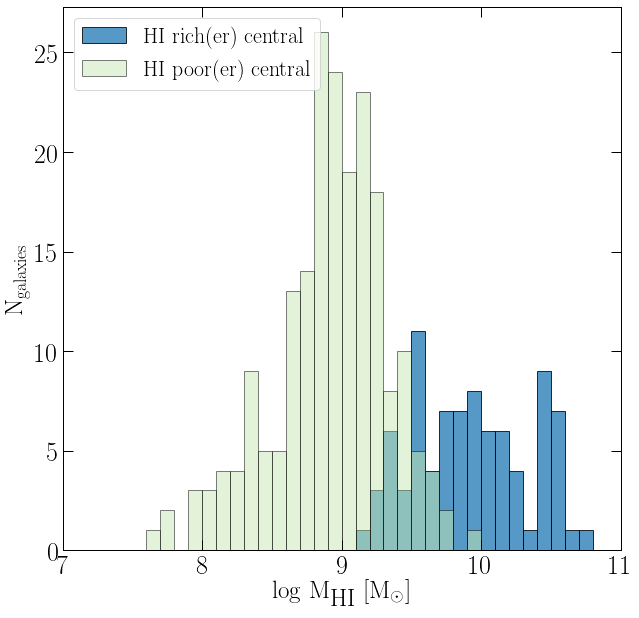

In [40]:
fig = plt.figure(figsize=(10,10))                                                               
ax = fig.add_subplot(1,1,1)

binwidth=0.1
bins = np.arange(7.5, 11 + binwidth, binwidth)
    
#axHistx.hist(x_data, bins=bins, color=color,alpha=0.8, edgecolor='k', linewidth=1)
#axHisty.hist(y_data, bins=bins, orientation='horizontal', color=color, alpha=0.8, edgecolor='k', linewidth=1) 

plt.hist(richer_central_hi_m, bins=bins, color='#2c7fb8', edgecolor='k', linewidth=1, alpha=0.8, label='HI rich(er) central')
plt.hist(poorer_central_hi_m, bins=bins, color='#c7e9b4', edgecolor='k', linewidth=1, alpha=0.5, label='HI poor(er) central')

ax.set_ylabel(r'N$_{\mathrm{galaxies}}$', fontsize=25)
ax.set_xlabel(r'log M$_{\textrm{HI}}$ [M$_{\odot}$]',fontsize=25)

plt.xlim(7,11)
plt.legend(loc=2)
plt.show()

In [44]:
def two_sided_histogram_rich(x_cen_rich, y_cen_rich, x_cen_poor, y_cen_poor):
    """
    Make a scatter plot with 2 datasets and then place histogram on both x and y axis for them. 
    Here I use logMhi vesus logMstar -- other data will need readjustment of the min/max.
    
    Parameters
    ==========
    x_cen_rich, y_cen_rich: x and y values of the first dataset. Floats. Can be list/array. 
                  In this case, I am using logMHI and logMstar of central galaxies.
    
    x_cen_poor, y_cen_poor: x and y values of the second dataset. Floats. Can be list/array. 
                  In this case, I am using logMHI and logMstar of satellite galaxies.                        
        
    color : Boolean. Chose color in case you want differen one. If not specified, will be the default one for satellites.
            Use different color in case there is only one dataset, for exaple:
            two_sided_histogram_groups(x, y, [], [], 'grey')
    
    
    Returns
    =======
    A scatter plot with histogram on x and y axis for both datasets. 
    
    Usage
    =====
    To use type: ``two_sided_histogram_groups(x_cen, y_cen, x_sat, y_sat)``
               I extracted satellite and central gal from dictionary using ``updated_dict`` and 
               group_size=2 for pairs -- can be any group_size number
               
               I extracted satellite and central gal from dictionary using ``updated_dict`` and 
               group_size=2 for pairs -- can be any group_size number
                
               Indices:
               central_idx = updated_dict[3]["Groups"][group_key]["Centrals"]
               satellite_inds = updated_dict[3]["Groups"][group_key]["Satellites"]
                
               To this, condition is added which check the mass of the central vs. satellites.
    """

    
    nullfmt = NullFormatter()         # no labels
    
    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02
    
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]
    
    # start with a rectangular Figure
    plt.figure(1, figsize=(12, 12))
    
    axScatter = plt.axes(rect_scatter)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)
    
    # no labels
    axHistx.xaxis.set_major_formatter(nullfmt)
    axHisty.yaxis.set_major_formatter(nullfmt)
    
    # the scatter plot:
    axScatter.scatter(x_cen_rich, y_cen_rich, color='#2c7fb8', label='HI rich(er) central')
    axScatter.scatter(x_cen_poor, y_cen_poor, color='#c7e9b4', label='HI poor(er) central', alpha=0.8)
    
    axScatter.set_xlabel(r'log M$_{\star}$ [M$_{\odot}$]', fontsize=25)
    axScatter.set_ylabel(r'log M$_{\textrm{HI}}$ [M$_{\odot}$]',fontsize=25)

    # now determine nice limits by hand:
    binwidth = 0.1
    xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(x))])
    lim = (int(xymax/binwidth) + 1) * binwidth
    
    axScatter.set_xlim((8.5, 11.7))
    axScatter.set_ylim((5.8, 11.7))
    
    bins = np.arange(5.8, lim + binwidth, binwidth)
    axHistx.hist(x_cen_rich, bins=bins, color='#2c7fb8', alpha=0.6, edgecolor='k', linewidth=1)
    axHisty.hist(y_cen_rich, bins=bins, orientation='horizontal', alpha=0.6, color='#2c7fb8', edgecolor='k', linewidth=1)
    
    axHistx.hist(x_cen_poor, bins=bins, color='#c7e9b4',alpha=0.4, edgecolor='k', linewidth=1)
    axHisty.hist(y_cen_poor, bins=bins, orientation='horizontal', color='#c7e9b4', alpha=0.4, edgecolor='k', linewidth=1) 

    axHistx.set_ylabel(r'N$_{\textrm{gal}}$', fontsize=22)
    axHisty.set_xlabel(r'N$_{\textrm{gal}}$', fontsize=22)
    
    axHistx.set_xlim(axScatter.get_xlim())
    axHisty.set_ylim(axScatter.get_ylim())

    axScatter.legend(loc=3)


    return plt.show()
    

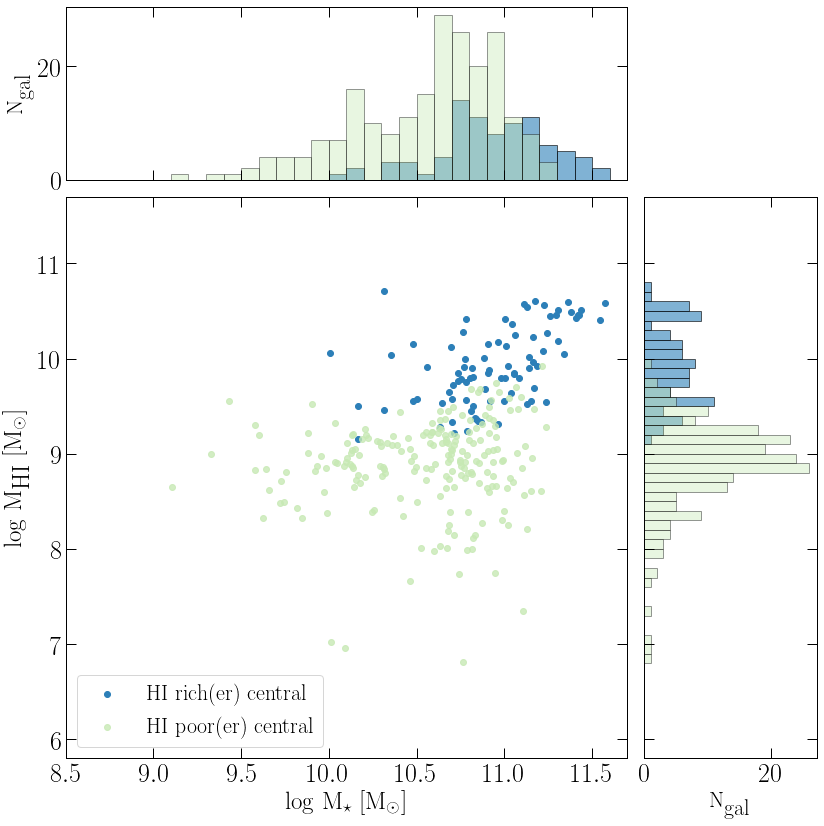

In [46]:
#Centrals more HI rich than the sum of their satellites
two_sided_histogram_rich(richer_central_s_m, richer_central_hi_m, poorer_central_s_m, poorer_central_hi_m) 

In [36]:
def two_sided_histogram_rich_groups(x_cen_rich, y_cen_rich, x_cen_poor, y_cen_poor,
                                   x_sat_rich, y_sat_rich, x_sat_poor, y_sat_poor):
    """
    Make a scatter plot with 8 datasets and then place histogram on both x and y axis for them as rich/poor central groups. 
    Here I use logMhi vesus logMstar -- other data will need readjustment of the min/max.
    
    Parameters
    ==========
    x_cen_rich, y_cen_rich: x and y values of the first dataset - here are centrals which are HI richer than their
                            satellites. Floats. Should be list/array; use .ravel() if needed
                            to reduce the dimensionality.  
                            In this case, I am using logMHI and logMstar of central galaxies.
    
    x_cen_poor, y_cen_poor: x and y values of the second dataset - here are centrals which are poorer than their
                            satellites. Should be list/array; use .ravel() if needed to reduce the dimensionality.
                            In this case, I am using logMHI and logMstar of satellite galaxies.                        
        
    x_sat_rich, y_sat_rich, x_sat_poor, y_sat_poor:
                            Same as above; just uses satellites around their respective central galaxy.
    
    Returns
    =======
    A scatter plot with histogram on x and y axis for both datasets. 
    
    Usage
    =====
    To use type: ``two_sided_histogram_rich_groups(richer_central_s_m.ravel(), richer_central_hi_m.ravel(), poorer_central_s_m.ravel(), poorer_central_hi_m.ravel(),
                                richer_sat_s_m.ravel(), richer_sat_hi_m.ravel(), poorer_sat_s_m.ravel(), poorer_sat_hi_m.ravel()) 
``
               I extracted satellite and central gal from dictionary using ``updated_dict`` and 
               group_size=2 for pairs -- can be any group_size number
                Indices:
                central_idx = updated_dict[3]["Groups"][group_key]["Centrals"]
                satellite_inds = updated_dict[3]["Groups"][group_key]["Satellites"]
                
                To this, condition is added which check the mass of the central vs. satellites.
                
                
    """

    
    nullfmt = NullFormatter()         # no labels
    
    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02
    
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]
    
    # start with a rectangular Figure
    plt.figure(1, figsize=(12, 12))
    
    axScatter = plt.axes(rect_scatter)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)
    
    # no labels
    axHistx.xaxis.set_major_formatter(nullfmt)
    axHisty.yaxis.set_major_formatter(nullfmt)
    
    # the scatter plot:
    axScatter.scatter(x_cen_rich, y_cen_rich, color='white', edgecolor='#2c7fb8', s=80, linewidth=2, label='HI rich(er) central')
    axScatter.scatter(x_sat_rich, y_sat_rich, color='#2c7fb8', edgecolor='#2c7fb8', s=80, linewidth=2, label='HI rich(er) central\'s satellite')

    axScatter.scatter(x_cen_poor, y_cen_poor, color='white', edgecolor='lightgrey', s=80, linewidth=2, label='HI poor(er) central', alpha=0.8)
    axScatter.scatter(x_sat_poor, y_sat_poor, color='lightgrey', edgecolor='lightgrey', s=80, linewidth=2, label='HI poor(er) central\'s satellite', alpha=0.8)
    
    
    axScatter.set_xlabel(r'log M$_{\star}$ [M$_{\odot}$]', fontsize=25)
    axScatter.set_ylabel(r'log M$_{\textrm{HI}}$ [M$_{\odot}$]',fontsize=25)

    # now determine nice limits by hand:
    binwidth = 0.1
    xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(x))])
    lim = (int(xymax/binwidth) + 1) * binwidth
    
    axScatter.set_xlim((8.5, 11.7))
    axScatter.set_ylim((5.8, 11.7))
    
    bins = np.arange(5.8, lim + binwidth, binwidth)
    
    
    x_rich = sorted(list(set(x_cen_rich)) + list(set(x_sat_rich)))
    y_rich = sorted(list(set(y_cen_rich)) + list(set(y_sat_rich)))
    
    x_poor = sorted(list(set(x_cen_poor)) + list(set(x_sat_poor)))
    y_poor = sorted(list(set(y_cen_poor)) + list(set(y_sat_poor)))
    
    axHistx.hist(x_rich, bins=bins, color='#2c7fb8', alpha=0.6, edgecolor='k', linewidth=1)
    axHisty.hist(y_rich, bins=bins, orientation='horizontal', alpha=0.6, color='#2c7fb8', edgecolor='k', linewidth=1)
    
    axHistx.hist(x_poor, bins=bins, color='lightgrey',alpha=0.4, edgecolor='k', linewidth=1)
    axHisty.hist(y_poor, bins=bins, orientation='horizontal', color='lightgrey', alpha=0.4, edgecolor='k', linewidth=1) 

    axHistx.set_ylabel(r'N$_{\textrm{gal}}$', fontsize=22)
    axHisty.set_xlabel(r'N$_{\textrm{gal}}$', fontsize=22)
    
    axHistx.set_xlim(axScatter.get_xlim())
    axHisty.set_ylim(axScatter.get_ylim())

    axScatter.legend(loc=3, fontsize=13)


    return plt.show()
    

In [37]:
def two_sided_histogram_difference(x_cen_rich, y_cen_rich, x_cen_poor, y_cen_poor,
                                   x_sat_rich, y_sat_rich, x_sat_poor, y_sat_poor):
    """
    Make a scatter plot with 8 datasets and then place histogram on both x and y axis for them
    Here plot groups with small difference in stellar mass but large in HI mass between cen/sat. 
    Here I use logMhi vesus logMstar -- other data will need readjustment of the min/max.
    
    Parameters
    ==========
    x_cen_rich, y_cen_rich: x and y values of the first dataset - here are centrals with small Mstar diff and large
                            Mhi difference. Floats. Should be list/array; use .ravel() if needed
                            to reduce the dimensionality.  
                            In this case, I am using logMHI and logMstar of central galaxies.
    
    x_cen_poor, y_cen_poor: x and y values of the second dataset - other/normal groups. 
                            Should be list/array; use .ravel() if needed to reduce the dimensionality.
                            In this case, I am using logMHI and logMstar of satellite galaxies.                        
        
    x_sat_rich, y_sat_rich, x_sat_poor, y_sat_poor:
                            Same as above; just uses satellites around their respective central galaxy.
    
    Returns
    =======
    A scatter plot with histogram on x and y axis for both datasets. 
    
    Usage
    =====
    To use type: ``two_sided_histogram_rich_groups(richer_central_s_m.ravel(), richer_central_hi_m.ravel(), poorer_central_s_m.ravel(), poorer_central_hi_m.ravel(),
                                richer_sat_s_m.ravel(), richer_sat_hi_m.ravel(), poorer_sat_s_m.ravel(), poorer_sat_hi_m.ravel()) 
``
               I extracted satellite and central gal from dictionary using ``updated_dict`` and 
               group_size=2 for pairs -- can be any group_size number
                Indices:
                central_idx = updated_dict[3]["Groups"][group_key]["Centrals"]
                satellite_inds = updated_dict[3]["Groups"][group_key]["Satellites"]
                
                To this, condition is added which check the mass of the central vs. satellites.
                
                
    """

    
    nullfmt = NullFormatter()         # no labels
    
    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02
    
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]
    
    # start with a rectangular Figure
    plt.figure(1, figsize=(12, 12))
    
    axScatter = plt.axes(rect_scatter)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)
    
    # no labels
    axHistx.xaxis.set_major_formatter(nullfmt)
    axHisty.yaxis.set_major_formatter(nullfmt)
    
    # the scatter plot:

    axScatter.scatter(x_cen_poor, y_cen_poor, color='white', edgecolor='lightgrey', s=80, linewidth=2, label='Other central', alpha=0.8)
    axScatter.scatter(x_sat_poor, y_sat_poor, color='lightgrey', edgecolor='lightgrey', s=80, linewidth=2, label='Other central\'s satellite', alpha=0.8)

    axScatter.scatter(x_cen_rich, y_cen_rich, color='white', edgecolor='#2c7fb8', s=80, linewidth=2, label='Large diff central')
    axScatter.scatter(x_sat_rich, y_sat_rich, color='#2c7fb8', edgecolor='#2c7fb8', s=80, linewidth=2, label='Large diff central\'s satellite')

    
    axScatter.set_xlabel(r'log M$_{\star}$ [M$_{\odot}$]', fontsize=25)
    axScatter.set_ylabel(r'log M$_{\textrm{HI}}$ [M$_{\odot}$]',fontsize=25)

    # now determine nice limits by hand:
    binwidth = 0.1
    xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(x))])
    lim = (int(xymax/binwidth) + 1) * binwidth
    
    axScatter.set_xlim((8.5, 11.7))
    axScatter.set_ylim((5.8, 11.7))
    
    bins = np.arange(5.8, lim + binwidth, binwidth)
    
    
    x_rich = sorted(list(set(x_cen_rich)) + list(set(x_sat_rich)))
    y_rich = sorted(list(set(y_cen_rich)) + list(set(y_sat_rich)))
    
    x_poor = sorted(list(set(x_cen_poor)) + list(set(x_sat_poor)))
    y_poor = sorted(list(set(y_cen_poor)) + list(set(y_sat_poor)))
    
    axHistx.hist(x_rich, bins=bins, color='#2c7fb8', alpha=0.6, edgecolor='k', linewidth=1)
    axHisty.hist(y_rich, bins=bins, orientation='horizontal', alpha=0.6, color='#2c7fb8', edgecolor='k', linewidth=1)
    
    axHistx.hist(x_poor, bins=bins, color='lightgrey',alpha=0.4, edgecolor='k', linewidth=1)
    axHisty.hist(y_poor, bins=bins, orientation='horizontal', color='lightgrey', alpha=0.4, edgecolor='k', linewidth=1) 

    axHistx.set_ylabel(r'N$_{\textrm{gal}}$', fontsize=22)
    axHisty.set_xlabel(r'N$_{\textrm{gal}}$', fontsize=22)
    
    axHistx.set_xlim(axScatter.get_xlim())
    axHisty.set_ylim(axScatter.get_ylim())

    axScatter.legend(loc=3, fontsize=13)


    return plt.show()
    

In [38]:
def two_sided_histogram_difference_groups(x_cen_rich, y_cen_rich, x_cen_poor, y_cen_poor,
                                   x_sat_rich, y_sat_rich, x_sat_poor, y_sat_poor,
                                  x_group, y_group):
    """
    Make a scatter plot with 8 datasets and then place histogram on both x and y axis for them
    Here plot groups with small difference in stellar mass but large in HI mass between cen/sat. 
    Here I use logMhi vesus logMstar -- other data will need readjustment of the min/max.
    
    Parameters
    ==========
    x_cen_rich, y_cen_rich: x and y values of the first dataset - here are centrals with small Mstar diff and large
                            Mhi difference. Floats. Should be list/array; use .ravel() if needed
                            to reduce the dimensionality.  
                            In this case, I am using logMHI and logMstar of central galaxies.
    
    x_cen_poor, y_cen_poor: x and y values of the second dataset - other/normal groups. 
                            Should be list/array; use .ravel() if needed to reduce the dimensionality.
                            In this case, I am using logMHI and logMstar of satellite galaxies.                        
        
    x_sat_rich, y_sat_rich, x_sat_poor, y_sat_poor:
                            Same as above; just uses satellites around their respective central galaxy.
    
    Returns
    =======
    A scatter plot with histogram on x and y axis for both datasets. 
    
    Usage
    =====
    To use type: ``two_sided_histogram_rich_groups(richer_central_s_m.ravel(), richer_central_hi_m.ravel(), poorer_central_s_m.ravel(), poorer_central_hi_m.ravel(),
                                richer_sat_s_m.ravel(), richer_sat_hi_m.ravel(), poorer_sat_s_m.ravel(), poorer_sat_hi_m.ravel()) 
``
               I extracted satellite and central gal from dictionary using ``updated_dict`` and 
               group_size=2 for pairs -- can be any group_size number
                Indices:
                central_idx = updated_dict[3]["Groups"][group_key]["Centrals"]
                satellite_inds = updated_dict[3]["Groups"][group_key]["Satellites"]
                
                To this, condition is added which check the mass of the central vs. satellites.
                
                
    """

    
    nullfmt = NullFormatter()         # no labels
    
    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02
    
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]
    
    # start with a rectangular Figure
    plt.figure(1, figsize=(12, 12))
    
    axScatter = plt.axes(rect_scatter)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)
    
    # no labels
    axHistx.xaxis.set_major_formatter(nullfmt)
    axHisty.yaxis.set_major_formatter(nullfmt)
    
    # the scatter plot:
        
    axScatter.scatter(x_cen_poor, y_cen_poor, color='white', edgecolor='lightgrey', s=80, linewidth=2, label='Other central', alpha=0.6)
    axScatter.scatter(x_sat_poor, y_sat_poor, color='lightgrey', edgecolor='lightgrey', s=80, linewidth=2, label='Other central\'s satellite', alpha=0.6)
   
    
    axScatter.scatter(x_cen_rich, y_cen_rich, color='white', edgecolor='#2c7fb8', s=80, linewidth=2, label='Large diff central')
    axScatter.scatter(x_sat_rich, y_sat_rich, color='#2c7fb8', edgecolor='#2c7fb8', s=80, linewidth=2, label='Large diff central\'s satellite')

    #MARK THE RICH ONES
    markers = itertools.cycle(('o', 'o', 'o', 's', 's', 's','D', 'D', 'D','p', 'p', 'p', 'd', 'd', 'd',
                             'P', 'P', 'P', '*', '*', '*','<', '<', '<','v', 'v', 'v', '^', '^', '^',
                              'x', 'x', 'x')) 
 
    #col = matplotlib.cm.viridis(np.linspace(0, 1, len(x_group)))
    #colors = itertools.cycle(col)
    
    for i in range(0,len(x_group),1):
        axScatter.scatter(x_group[i],y_group[i], marker = next(markers), color = '',edgecolor='k', s=400)
        
    #marker = itertools.cycle(('o', 's', 'p', 'P', '*', 'h', 'D', 'd'))
    #axScatter.scatter(x_group, y_group, color='#fa9fb5', marker=next(marker), s=250, label='Groups', alpha=0.8)
    #print(len(x_group)) == 15 
    #print(len(x_group[1]))
    
    axScatter.set_xlabel(r'log M$_{\star}$ [M$_{\odot}$]', fontsize=25)
    axScatter.set_ylabel(r'log M$_{\textrm{HI}}$ [M$_{\odot}$]',fontsize=25)

    # now determine nice limits by hand:
    binwidth = 0.1
    xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(x))])
    lim = (int(xymax/binwidth) + 1) * binwidth
    
    axScatter.set_xlim((8.5, 11.7))
    axScatter.set_ylim((5.8, 11.7))
    
    bins = np.arange(5.8, lim + binwidth, binwidth)
    
    
    x_rich = sorted(list(set(x_cen_rich)) + list(set(x_sat_rich)))
    y_rich = sorted(list(set(y_cen_rich)) + list(set(y_sat_rich)))
    
    x_poor = sorted(list(set(x_cen_poor)) + list(set(x_sat_poor)))
    y_poor = sorted(list(set(y_cen_poor)) + list(set(y_sat_poor)))
    
    axHistx.hist(x_rich, bins=bins, color='#2c7fb8', alpha=0.6, edgecolor='k', linewidth=1)
    axHisty.hist(y_rich, bins=bins, orientation='horizontal', alpha=0.6, color='#2c7fb8', edgecolor='k', linewidth=1)
    
    axHistx.hist(x_poor, bins=bins, color='lightgrey',alpha=0.4, edgecolor='k', linewidth=1)
    axHisty.hist(y_poor, bins=bins, orientation='horizontal', color='lightgrey', alpha=0.4, edgecolor='k', linewidth=1) 

    axHistx.set_ylabel(r'N$_{\textrm{gal}}$', fontsize=22)
    axHisty.set_xlabel(r'N$_{\textrm{gal}}$', fontsize=22)
    
    axHistx.set_xlim(axScatter.get_xlim())
    axHisty.set_ylim(axScatter.get_ylim())

    axScatter.legend(loc=3, fontsize=13)


    return plt.show()
    

## Groups Length-3

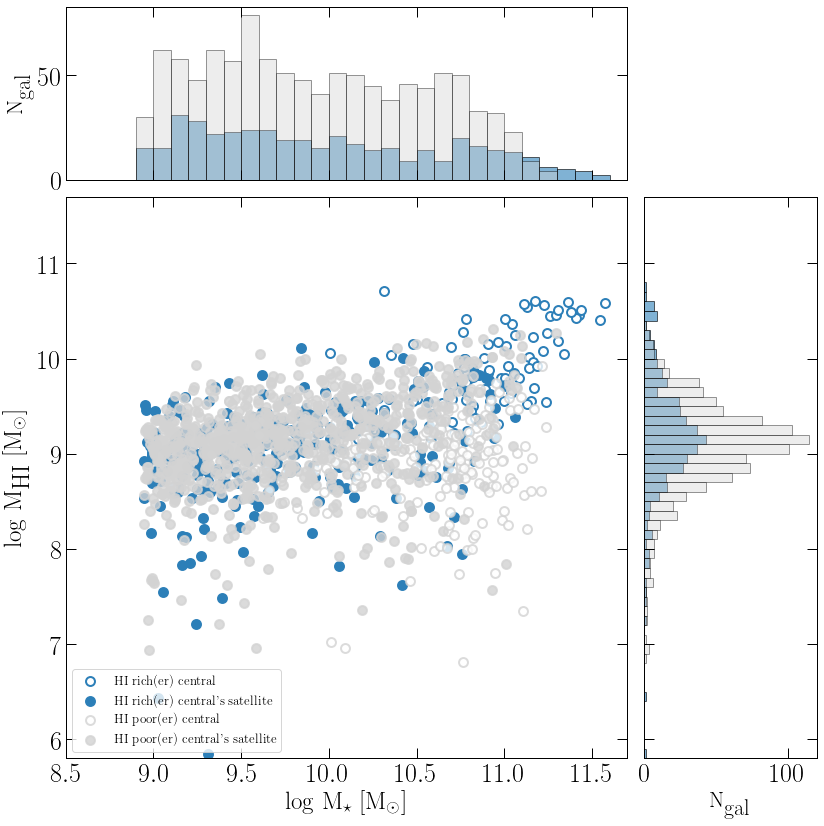

In [50]:
# Central gals which are more HI rich than the sum of their satellites --- also marks position of their satellites
# And vice versa
two_sided_histogram_rich_groups(richer_central_s_m.ravel(), richer_central_hi_m.ravel(), poorer_central_s_m.ravel(), poorer_central_hi_m.ravel(),
                                richer_sat_s_m.ravel(), richer_sat_hi_m.ravel(), poorer_sat_s_m.ravel(), poorer_sat_hi_m.ravel()) 


# Extract rich(er) and poor(er) from all size-d groups

In [48]:
#Use dictionary and for each galaxy in "Groups" of 3 show central/satellite index

all_richer_central_ind = []
all_poorer_central_ind = []

all_richer_sat_ind = [] #satellites that belong to richer central
all_poorer_sat_ind = [] #satellites that belong to poorer central

for i in trange(3,10,1): #starting grom galaxy pairs
    for group_key in updated_dict[i]["Groups"].keys():
        central_idx = updated_dict[i]["Groups"][group_key]["Centrals"] #give indices
        central_mass = np.sum(G['DiscHI'],axis=1)[central_idx] #give masses of these galaxies
    
        satellite_inds = updated_dict[i]["Groups"][group_key]["Satellites"]
        sat_mass = np.sum(G['DiscHI'],axis=1)[satellite_inds]
    
        if (central_mass > sat_mass).all(): #check conditions
            print("Central is the most HI massive")
            all_richer_central_ind.append(central_idx) 
            all_richer_sat_ind.extend(satellite_inds) #it complains and complicates when i want to do .append
        else:
            print("Satellite is more HI massive thatn central")
            all_poorer_central_ind.append(central_idx)
            all_poorer_sat_ind.extend(satellite_inds)
        #print(sat_mass > central_mass)
    
        print("Central mass is {0} and sat masses are {1}".format(central_mass, sat_mass))
        print("")


  0%|          | 0/7 [00:00<?, ?it/s]

Central is the most HI massive
Central mass is [1.7153461] and sat masses are [0.06906993 0.09697242]

Satellite is more HI massive thatn central
Central mass is [0.15540755] and sat masses are [0.12781921 0.17335452]

Satellite is more HI massive thatn central
Central mass is [0.16649424] and sat masses are [0.18389466 0.05094769]

Satellite is more HI massive thatn central
Central mass is [0.01658152] and sat masses are [0.07774934 0.11448571]

Satellite is more HI massive thatn central
Central mass is [0.05982171] and sat masses are [0.07125283 0.2850502 ]

Satellite is more HI massive thatn central
Central mass is [0.06139318] and sat masses are [0.0499579  0.11261014]

Satellite is more HI massive thatn central
Central mass is [0.12575132] and sat masses are [0.29197252 0.14685738]

Central is the most HI massive
Central mass is [0.5539247] and sat masses are [0.06811111 0.        ]

Satellite is more HI massive thatn central
Central mass is [0.] and sat masses are [0.        0.02

KeyboardInterrupt: 

In [75]:
#HI Masses, obtained from the indices: 
all_richer_central_hi_m = np.log10( (np.sum(G['DiscHI'],axis=1)[all_richer_central_ind] *1e10/h )+1)
all_poorer_central_hi_m = np.log10( (np.sum(G['DiscHI'],axis=1)[all_poorer_central_ind] *1e10/h )+1)
all_richer_central_s_m = np.log10( G['StellarMass'][all_richer_central_ind] *1e10/h +1)
all_poorer_central_s_m = np.log10( G['StellarMass'][all_poorer_central_ind] *1e10/h +1)

#have to store satellites like this; otherwise it complains
all_richer_sat_hi_m = []
all_richer_sat_s_m = []

for item in all_richer_sat_ind:
    a_richer_sat_hi_m = np.log10( (np.sum(G['DiscHI'],axis=1)[item] *1e10/h )+1)
    a_richer_sat_s_m = np.log10( G['StellarMass'][item] *1e10/h +1)
    all_richer_sat_hi_m.append(a_richer_sat_hi_m)
    all_richer_sat_s_m.append(a_richer_sat_s_m)

all_poorer_sat_hi_m = []
all_poorer_sat_s_m = []
for item in all_poorer_sat_ind:    
    a_poorer_sat_hi_m = np.log10( (np.sum(G['DiscHI'],axis=1)[item] *1e10/h )+1)
    a_poorer_sat_s_m = np.log10( G['StellarMass'][item] *1e10/h +1)
    all_poorer_sat_hi_m.append(a_poorer_sat_hi_m)
    all_poorer_sat_s_m.append(a_poorer_sat_s_m)


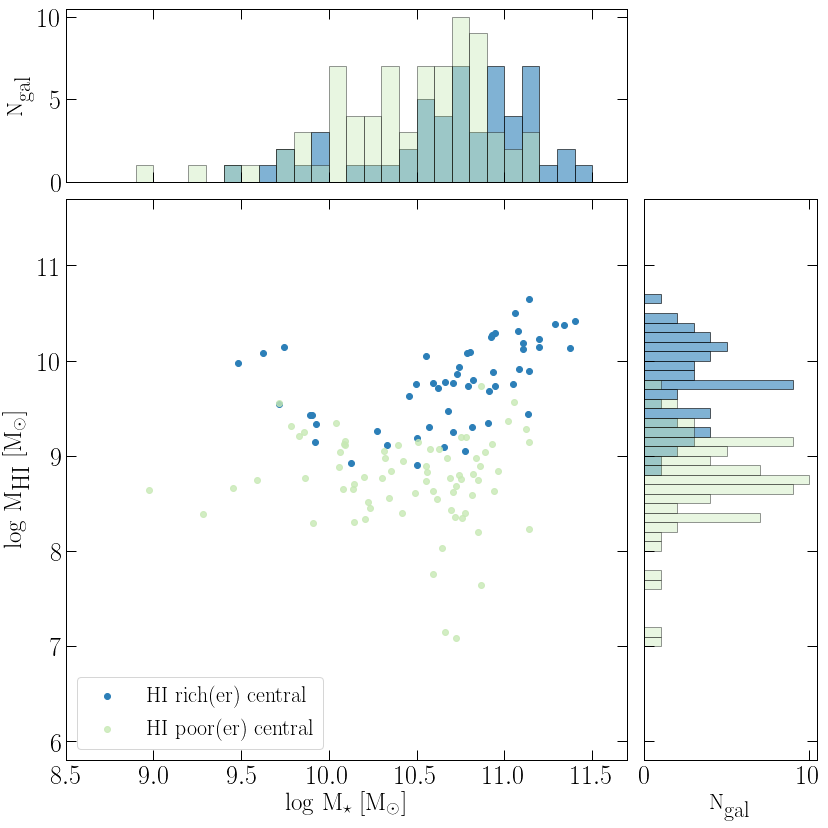

In [76]:
two_sided_histogram_rich(all_richer_central_s_m, all_richer_central_hi_m, 
                         all_poorer_central_s_m, all_poorer_central_hi_m) 

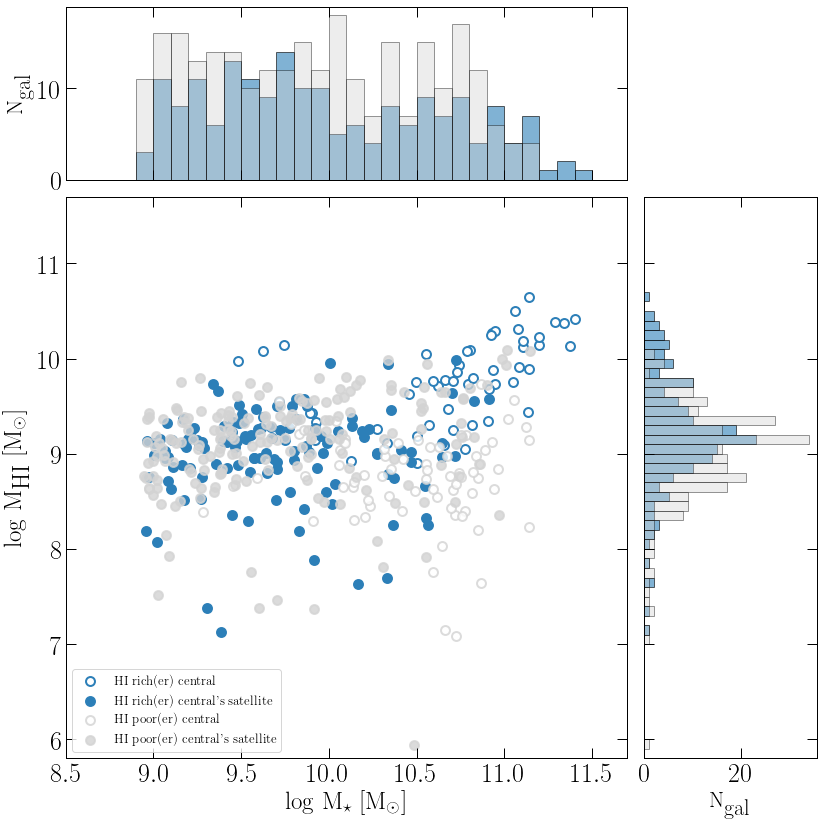

In [77]:
two_sided_histogram_rich_groups(all_richer_central_s_m.ravel(), all_richer_central_hi_m.ravel(), 
                                all_poorer_central_s_m.ravel(), all_poorer_central_hi_m.ravel(),
                                all_richer_sat_s_m, all_richer_sat_hi_m, 
                                all_poorer_sat_s_m, all_poorer_sat_hi_m) 


# See the distribution of groups where central galaxy is X% HI richer than the sum of the satellites around that central
### Percent = M_HI_central/ (Sum[ M_HI_satellites ])

In [278]:
per_cent_with_pairs =[]

In [279]:
#Use dictionary and for each galaxy in "Groups" of 3 show central/satellite index

perc_richer_central_ind = [] #storring where central/satellite is above/below some percentage
perc_poorer_central_ind = []

perc_richer_sat_ind = [] #satellites that belong to richer central
perc_poorer_sat_ind = [] #satellites that belong to poorer central

per_cent = [] # How much of HI mass is in central galaxy (in %)

central_hi_mass_per_cent = []
central_st_mass_per_cent = []
group_size_per_cent = []

BTT_central = []
BTT_satellite = []

group_HI_mass = []
group_St_mass = []

In [280]:
#BTT_central[0]

In [281]:
# STORE INDICES

c_ind = []
s_ind = []
g_ind = []

for i in trange(3,21,1): #starting grom galaxy pairs
    for group_key in updated_dict[i]["Groups"].keys():
        central_idx = updated_dict[i]["Groups"][group_key]["Centrals"] #give indices
        c_ind.append(central_idx)
               
        all_idx = updated_dict[i]["Groups"][group_key]["Centrals"]+updated_dict[i]["Groups"][group_key]["Satellites"]
        g_ind.append(all_idx)
        
        satellite_inds = updated_dict[i]["Groups"][group_key]["Satellites"]
        s_ind.append(satellite_inds)

100%|██████████| 18/18 [00:00<00:00, 2001.15it/s]


In [282]:
# Compute central galaxies
central_mass = np.sum(G['DiscHI'],axis=1)[c_ind]*1e10/h
central_st_mass = G['StellarMass'][c_ind]*1e10/h

In [283]:
# Compute group properties 
g_m = []
g_st = []
for i in tqdm(g_ind):
    g_mass = np.sum(G['DiscHI'],axis=1)[i]*1e10/h
    g_st_mass = G['StellarMass'][i]*1e10/h
    g_m.append(np.sum(g_mass))
    g_st.append(np.sum(g_st_mass))
    

100%|██████████| 6988/6988 [31:23<00:00,  3.71it/s]


In [284]:
# Compute percentage
percentage = (central_mass.ravel()/g_m)*100

#check output
#print(central_mass[0:5].ravel())
#print(g_m[0:5])
#print(percentage)

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


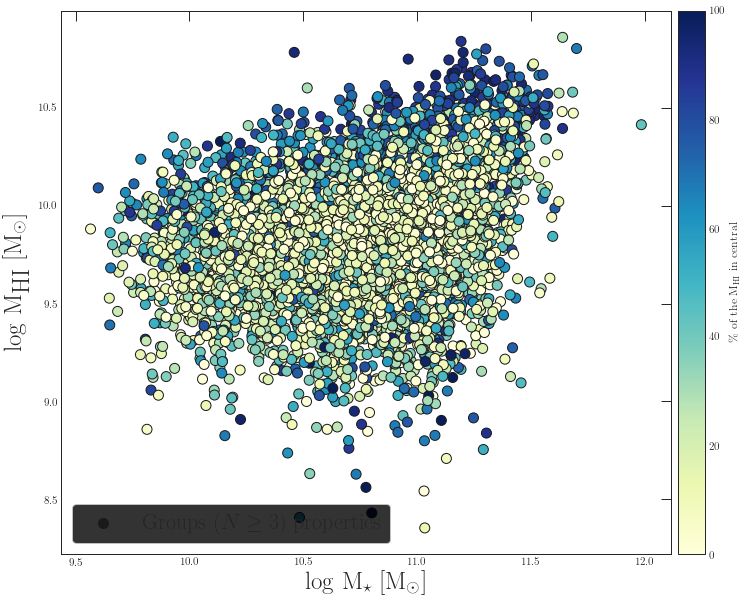

In [285]:

fig = plt.figure(figsize=(13,10))                                                               
ax = fig.add_subplot(1,1,1)

cm = plt.cm.get_cmap('YlGnBu')


im = plt.scatter(np.log10(g_st), np.log10(g_m), s=100,
                        c=percentage, edgecolor='k', cmap=cm, label=r'Groups ($N\geq3$) properties')

fig.colorbar(im, ax=ax, orientation='vertical', label=r'\% of the M$_{\mathrm{HI}}$ in central',
            pad=0.01)

ax.set_xlabel(r'log M$_{\star}$ [M$_{\odot}$]', fontsize=25)
ax.set_ylabel(r'log M$_{\textrm{HI}}$ [M$_{\odot}$]',fontsize=25)
ax.legend(loc=3)
leg = ax.get_legend()
leg.legendHandles[0].set_color('k')


#plt.savefig('Groups_HIinCentral.png')

In [286]:
        #Bulge-to-total ratio
#BTT_sat = (G['InstabilityBulgeMass'][s_ind] + G['MergerBulgeMass'][s_ind]) / ( G['StellarMass'][s_ind] )
BTT_cen = (G['InstabilityBulgeMass'][c_ind] + G['MergerBulgeMass'][c_ind]) / ( G['StellarMass'][c_ind] )
Lenght_cen = G['Len'][c_ind]
Mvir_cen = np.log10( (G['Mvir'][c_ind])*1e10/h)
Rvir_cen = G['Rvir'][c_ind]


## Distribution below is for groups N=+3

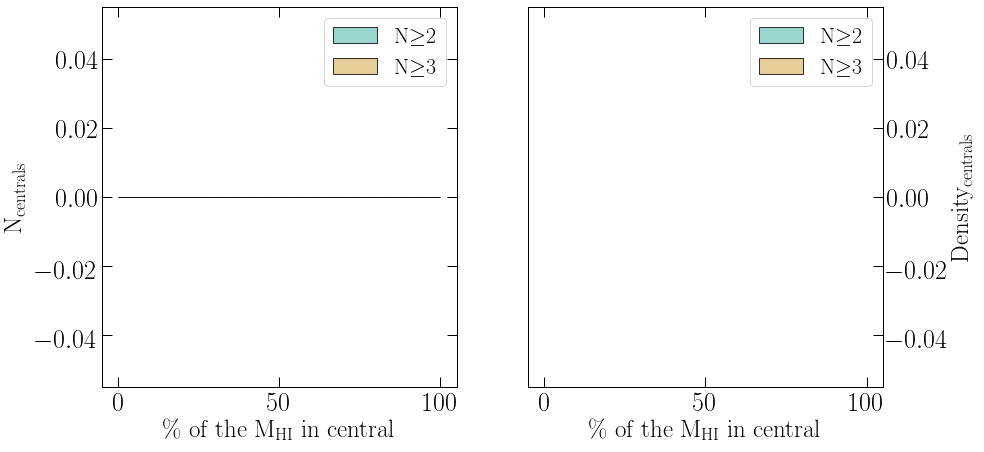

In [59]:
fig = plt.figure(figsize=(14,7))                                                               
ax = fig.add_subplot(1,2,1)

binwidth=5
bins = np.arange(0, 100 + binwidth, binwidth)
    

per_cent = np.nan_to_num(per_cent)
per_cent_with_pairs = np.nan_to_num(per_cent_with_pairs)

plt.hist(per_cent_with_pairs, bins=bins, color='#80cdc1', edgecolor='k', linewidth=1, alpha=0.8, label='N$\geq$2')
plt.hist(per_cent, bins=bins, color='#dfc27d', edgecolor='k', linewidth=1, alpha=0.8, label='N$\geq$3')

ax.set_ylabel(r'N$_{\mathrm{centrals}}$', fontsize=25)
ax.set_xlabel(r'\% of the M$_{\mathrm{HI}}$ in central',fontsize=25)

plt.xlim(-5,105)
plt.legend(loc=1)

ax2 = fig.add_subplot(1,2,2)

    
ax2.hist(per_cent_with_pairs, density=True, bins=bins, color='#80cdc1', edgecolor='k', linewidth=1, alpha=0.8, label='N$\geq$2')
ax2.hist(per_cent, density=True, bins=bins, color='#dfc27d', edgecolor='k', linewidth=1, alpha=0.8, label='N$\geq$3')

ax2.set_xlabel(r'\% of the M$_{\mathrm{HI}}$ in central',fontsize=25)
ax2.set_ylabel(r'Density$_{\mathrm{centrals}}$', fontsize=25)
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

plt.xlim(-5,105)
plt.legend(loc=1)

plt.show()

In [287]:
grp_length = []
for i in g_ind:
    size = len(i)
    grp_length.append(size)

In [288]:
df_percent = pd.DataFrame({'GroupStellarMass'   : g_st,
                           'GroupHIMass'        : g_m,
                           'Percent'            : percentage,
                           'GroupSize'          : grp_length,
                           'BTT_central'        : BTT_cen.ravel().tolist(),# })
                           'Len_cen'            : Lenght_cen.ravel(),
                           'Mvir_cen'           : Mvir_cen.ravel(),
                           'Rvir_cen'           : Rvir_cen.ravel() })
#print(df_percent)

In [289]:
print(df_percent['BTT_central'][0:4])

0    0.162099
1    1.000000
2    0.201571
3    0.380680
Name: BTT_central, dtype: float64


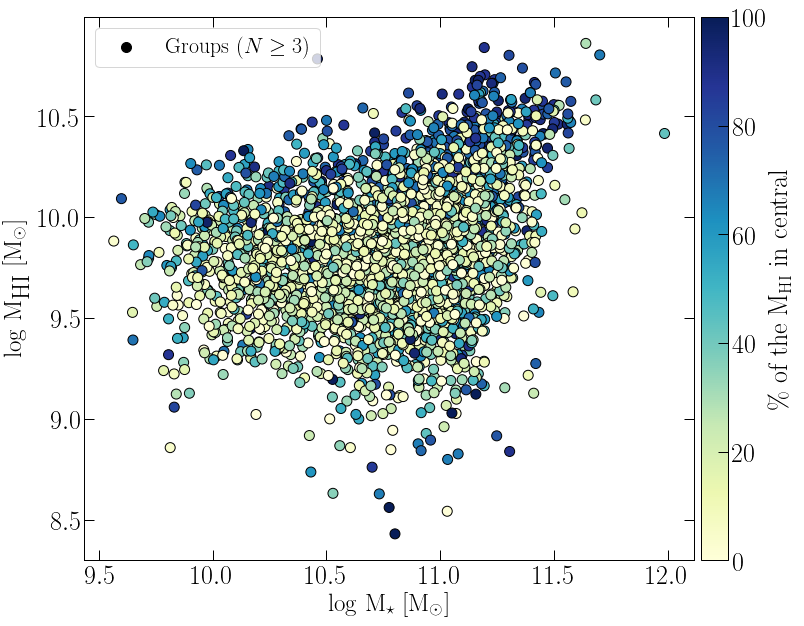

In [51]:

fig = plt.figure(figsize=(13,10))                                                               
ax = fig.add_subplot(1,1,1)

cm = plt.cm.get_cmap('YlGnBu')
#Numpy doesn't know what you might have stored in a object array, 
df_percent['GroupStellarMass'] = df_percent['GroupStellarMass'].astype(np.float64) 
df_percent['GroupHIMass'] = df_percent['GroupHIMass'].astype(np.float64)

#BE CAREFUL HERE! Constructed sizes are OK for current groups; will need change
#s = 80*df_percent['Group_size']

sizes = [100,300,500,700,900]
im = plt.scatter(np.log10(df_percent['GroupStellarMass']), np.log10(df_percent['GroupHIMass']), s=100,
                        c=df_percent['Percent'], edgecolor='k', cmap=cm, label=r'Groups ($N\geq3$)')

fig.colorbar(im, ax=ax, orientation='vertical', label=r'\% of the M$_{\mathrm{HI}}$ in central',
            pad=0.01)

ax.set_xlabel(r'log M$_{\star}$ [M$_{\odot}$]', fontsize=25)
ax.set_ylabel(r'log M$_{\textrm{HI}}$ [M$_{\odot}$]',fontsize=25)
ax.legend(loc=2)
leg = ax.get_legend()
leg.legendHandles[0].set_color('k')

#l1 = plt.scatter([],[], s=100, color='white',edgecolors='k')
#l2 = plt.scatter([],[], s=300, color='white',edgecolors='k')
#l3 = plt.scatter([],[], s=500, color='white',edgecolors='k')
#l4 = plt.scatter([],[], s=700, color='white',edgecolors='k')
#l5 = plt.scatter([],[], s=900, color='white',edgecolors='k')
#
#labels = ["3", "4", "5", "6", '7']
#
#leg = plt.legend([l1, l2, l3, l4, l5], labels, ncol=1, loc=3, framealpha=0.5)
#leg.set_title('Group size')                   
                   
#plt.ylim(6,11)
plt.savefig('Groups_HIinCentral.png')

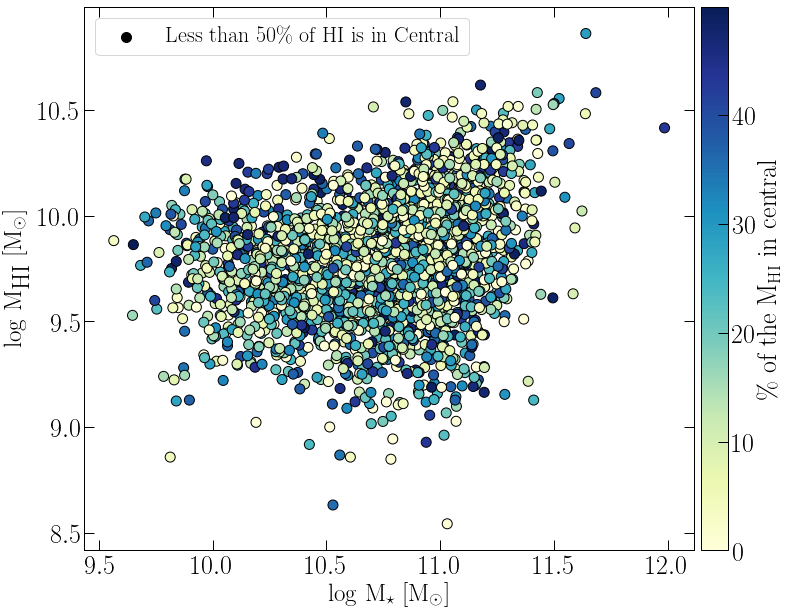

In [52]:
HI_per_cent = 50

fig = plt.figure(figsize=(13,10))                                                               
ax = fig.add_subplot(1,1,1)

cm = plt.cm.get_cmap('YlGnBu')
#Numpy doesn't know what you might have stored in a object array, 
df_percent['GroupStellarMass'] = df_percent['GroupStellarMass'].astype(np.float64) 
df_percent['GroupHIMass'] = df_percent['GroupHIMass'].astype(np.float64)

#BE CAREFUL HERE! Constructed sizes are OK for current groups; will need change
#s = 80*df_percent['Group_size']

sizes = [100,300,500,700,900]
im = plt.scatter(np.log10(df_percent['GroupStellarMass'][df_percent['Percent']<HI_per_cent]), np.log10(df_percent['GroupHIMass'][df_percent['Percent']<HI_per_cent]), s=100,
                        c=df_percent['Percent'][df_percent['Percent']<HI_per_cent], edgecolor='k', cmap=cm, label=r'Less than {0}\% of HI is in Central'.format(HI_per_cent))

fig.colorbar(im, ax=ax, orientation='vertical', label=r'\% of the M$_{\mathrm{HI}}$ in central',
            pad=0.01)

ax.set_xlabel(r'log M$_{\star}$ [M$_{\odot}$]', fontsize=25)
ax.set_ylabel(r'log M$_{\textrm{HI}}$ [M$_{\odot}$]',fontsize=25)
ax.legend(loc=2)
leg = ax.get_legend()
leg.legendHandles[0].set_color('k')

#l1 = plt.scatter([],[], s=100, color='white',edgecolors='k')
#l2 = plt.scatter([],[], s=300, color='white',edgecolors='k')
#l3 = plt.scatter([],[], s=500, color='white',edgecolors='k')
#l4 = plt.scatter([],[], s=700, color='white',edgecolors='k')
#l5 = plt.scatter([],[], s=900, color='white',edgecolors='k')
#
#labels = ["3", "4", "5", "6", '7']
#
#leg = plt.legend([l1, l2, l3, l4, l5], labels, ncol=1, loc=3, framealpha=0.5)
#leg.set_title('Group size')                   
                   
#plt.ylim(6,11)
plt.savefig('Groups_HIinCentral.png')

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


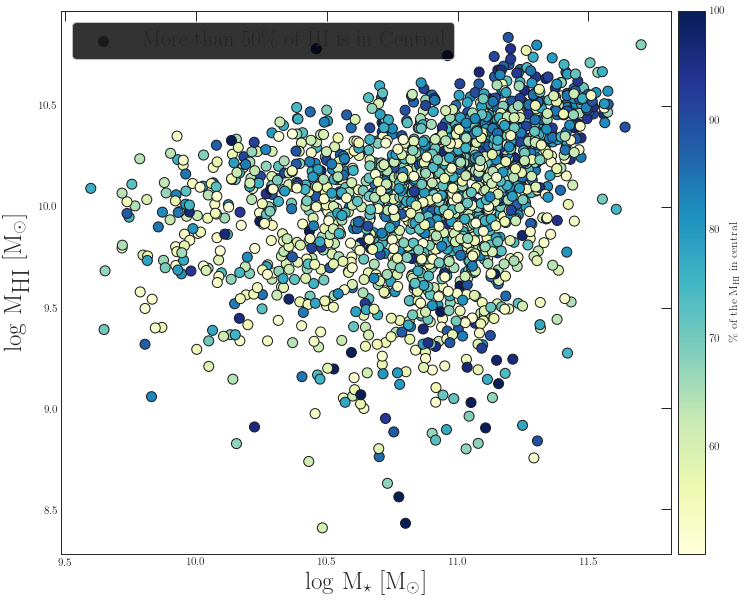

In [290]:

fig = plt.figure(figsize=(13,10))                                                               
ax = fig.add_subplot(1,1,1)

cm = plt.cm.get_cmap('YlGnBu')
#Numpy doesn't know what you might have stored in a object array, 
df_percent['GroupStellarMass'] = df_percent['GroupStellarMass'].astype(np.float64) 
df_percent['GroupHIMass'] = df_percent['GroupHIMass'].astype(np.float64)

#BE CAREFUL HERE! Constructed sizes are OK for current groups; will need change
#s = 80*df_percent['Group_size']

sizes = [100,300,500,700,900]
im = plt.scatter(np.log10(df_percent['GroupStellarMass'][df_percent['Percent']>HI_per_cent]), np.log10(df_percent['GroupHIMass'][df_percent['Percent']>HI_per_cent]), s=100,
                        c=df_percent['Percent'][df_percent['Percent']>HI_per_cent], edgecolor='k', cmap=cm, label=r'More than {0}\% of HI is in Central'.format(HI_per_cent))

fig.colorbar(im, ax=ax, orientation='vertical', label=r'\% of the M$_{\mathrm{HI}}$ in central',
            pad=0.01)

ax.set_xlabel(r'log M$_{\star}$ [M$_{\odot}$]', fontsize=25)
ax.set_ylabel(r'log M$_{\textrm{HI}}$ [M$_{\odot}$]',fontsize=25)
ax.legend(loc=2)
leg = ax.get_legend()
leg.legendHandles[0].set_color('k')

#l1 = plt.scatter([],[], s=100, color='white',edgecolors='k')
#l2 = plt.scatter([],[], s=300, color='white',edgecolors='k')
#l3 = plt.scatter([],[], s=500, color='white',edgecolors='k')
#l4 = plt.scatter([],[], s=700, color='white',edgecolors='k')
#l5 = plt.scatter([],[], s=900, color='white',edgecolors='k')
#
#labels = ["3", "4", "5", "6", '7']
#
#leg = plt.legend([l1, l2, l3, l4, l5], labels, ncol=1, loc=3, framealpha=0.5)
#leg.set_title('Group size')                   
                   
#plt.ylim(6,11)
plt.savefig('Groups_HIinCentral.png')

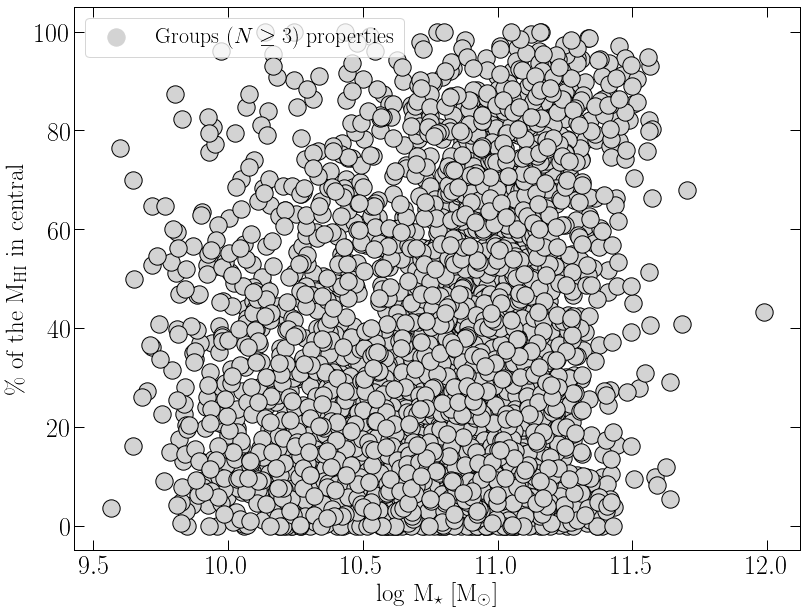

In [54]:

fig = plt.figure(figsize=(13,10))                                                               
ax = fig.add_subplot(1,1,1)

cm = plt.cm.get_cmap('YlGnBu')
#Numpy doesn't know what you might have stored in a object array, 
df_percent['GroupStellarMass'] = df_percent['GroupStellarMass'].astype(np.float64) 
df_percent['GroupHIMass'] = df_percent['GroupHIMass'].astype(np.float64)

#BE CAREFUL HERE! Constructed sizes are OK for current groups; will need change
#s = 80*df_percent['Group_size']

sizes = [100,300,500,700,900]
im = plt.scatter(np.log10(df_percent['GroupStellarMass']), df_percent['Percent'], s=300,
                        color='lightgrey', edgecolor='k', label=r'Groups ($N\geq3$) properties')

#fig.colorbar(im, ax=ax, orientation='vertical', label=r'\% of the M$_{\mathrm{HI}}$ in central',
#            pad=0.01)

ax.set_xlabel(r'log M$_{\star}$ [M$_{\odot}$]', fontsize=25)
ax.set_ylabel(r'\% of the M$_{\mathrm{HI}}$ in central',fontsize=25)
ax.legend(loc=2)
leg = ax.get_legend()
leg.legendHandles[0].set_color('lightgrey')

#l1 = plt.scatter([],[], s=100, color='white',edgecolors='k')
#l2 = plt.scatter([],[], s=300, color='white',edgecolors='k')
#l3 = plt.scatter([],[], s=500, color='white',edgecolors='k')
#l4 = plt.scatter([],[], s=700, color='white',edgecolors='k')
#l5 = plt.scatter([],[], s=900, color='white',edgecolors='k')
#
#labels = ["3", "4", "5", "6", '7']
#
#leg = plt.legend([l1, l2, l3, l4, l5], labels, ncol=1, loc=3, framealpha=0.5)
#leg.set_title('Group size')                   
                   
#plt.ylim(6,11)
#plt.savefig('Groups_HIinCentral.png')

# Fixed N-sized groups

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


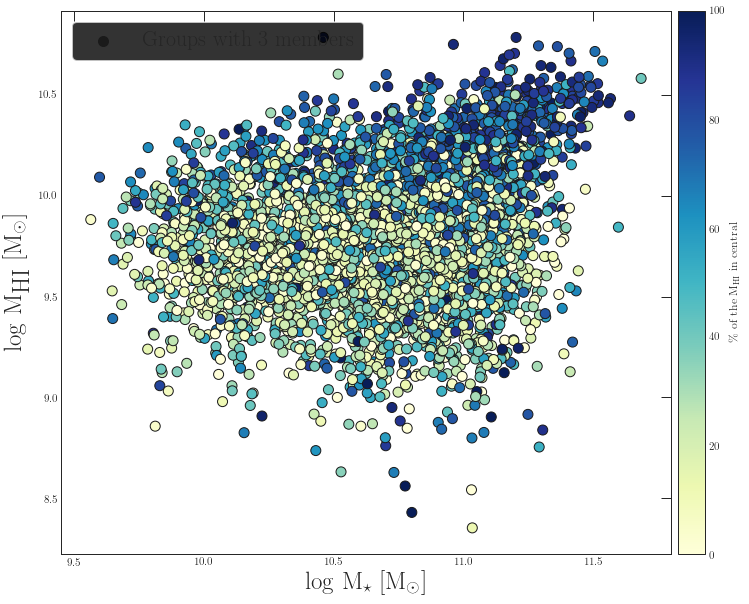

In [291]:
Nsize_group = 3

fig = plt.figure(figsize=(13,10))                                                               
ax = fig.add_subplot(1,1,1)

cm = plt.cm.get_cmap('YlGnBu')
#Numpy doesn't know what you might have stored in a object array, 
#df_percent['GroupStellarMass'] = df_percent['GroupStellarMass'].astype(np.float64) 
#df_percent['GroupHIMass'] = df_percent['GroupHIMass'].astype(np.float64)

#BE CAREFUL HERE! Constructed sizes are OK for current groups; will need change
#s = 80*df_percent['Group_size']

sizes = [100,300,500,700,900]
im = plt.scatter(np.log10(df_percent['GroupStellarMass'][df_percent['GroupSize']==Nsize_group]), np.log10(df_percent['GroupHIMass'][df_percent['GroupSize']==Nsize_group]), s=100,
                        c=df_percent['Percent'][df_percent['GroupSize']==Nsize_group], edgecolor='k', cmap=cm, label=r'Groups with {0} members'.format(Nsize_group))

fig.colorbar(im, ax=ax, orientation='vertical', label=r'\% of the M$_{\mathrm{HI}}$ in central',
            pad=0.01)

ax.set_xlabel(r'log M$_{\star}$ [M$_{\odot}$]', fontsize=25)
ax.set_ylabel(r'log M$_{\textrm{HI}}$ [M$_{\odot}$]',fontsize=25)
ax.legend(loc=2)
leg = ax.get_legend()
leg.legendHandles[0].set_color('k')

#l1 = plt.scatter([],[], s=100, color='white',edgecolors='k')
#l2 = plt.scatter([],[], s=300, color='white',edgecolors='k')
#l3 = plt.scatter([],[], s=500, color='white',edgecolors='k')
#l4 = plt.scatter([],[], s=700, color='white',edgecolors='k')
#l5 = plt.scatter([],[], s=900, color='white',edgecolors='k')
#
#labels = ["3", "4", "5", "6", '7']
#
#leg = plt.legend([l1, l2, l3, l4, l5], labels, ncol=1, loc=3, framealpha=0.5)
#leg.set_title('Group size')                   
                   
#plt.ylim(6,11)
plt.savefig('Groups_HIinCentral.png')

In [292]:
import seaborn as sns

In [57]:

#import matplotlib.font_manager
#matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

#matplotlib.rcParams.update({'font.size': fsize, 'xtick.major.size': 10, 'ytick.major.size': 10, 'xtick.major.width': 1, 'ytick.major.width': 1, 'ytick.minor.size': 5, 'xtick.minor.size': 5, 'xtick.direction': 'in', 'ytick.direction': 'in', 'axes.linewidth': 1, 'text.usetex': True, 'font.family': 'serif', 'font.serif': 'Times New Roman', 'legend.numpoints': 1, 'legend.columnspacing': 1, 'legend.fontsize': fsize-4, 'xtick.top': True, 'ytick.right': True})


INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


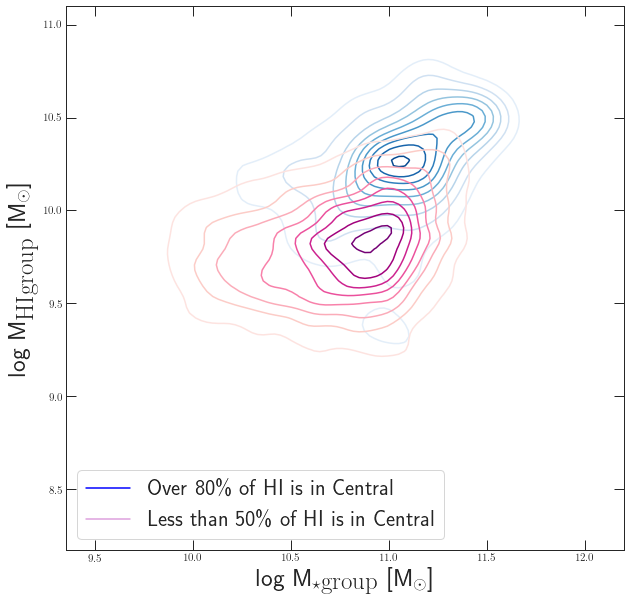

In [293]:
High_percentage = 80
Low_percentage = 50



fig = plt.figure(figsize=(10,10))                                                               
ax = fig.add_subplot(1,1,1)

#sns.set_style("white")
#sns.set(font_scale=2)
sns.set_style("ticks", {"xtick.major.size":10, "ytick.major.size":10,
						"xtick.minor.size":6,"ytick.minor.size":6})
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
#matplotlib.rcParams.update({'font.size': fsize, 'xtick.major.size': 10, 'ytick.major.size': 10, 'xtick.major.width': 1, 'ytick.major.width': 1, 'ytick.minor.size': 5, 'xtick.minor.size': 5, 'xtick.direction': 'in', 'ytick.direction': 'in', 'axes.linewidth': 1, 'text.usetex': True, 'font.family': 'serif', 'font.serif': 'Times New Roman', 'legend.numpoints': 1, 'legend.columnspacing': 1, 'legend.fontsize': fsize-4, 'xtick.top': True, 'ytick.right': True})


#sns.set_style("white")
sns.kdeplot(np.log10(df_percent['GroupStellarMass'][df_percent['Percent'] >= High_percentage]), 
            np.log10(df_percent['GroupHIMass'][df_percent['Percent'] >= High_percentage]), cmap='Blues', label= 'Over {0}\% of HI is in Central'.format(High_percentage)) #shade=True, shade_lowest=False, 


#sns.kdeplot(np.log10(df_percent['GroupStellarMass'][(df_percent['Percent'] >= 50) & ((df_percent['Percent'] < 80)) ]), 
#            np.log10(df_percent['GroupHIMass'][(df_percent['Percent'] >= 50) & ((df_percent['Percent'] < 80))]), cmap='Greens', label='Rich')

sns.kdeplot(np.log10(df_percent['GroupStellarMass'][df_percent['Percent'] < Low_percentage]), 
            np.log10(df_percent['GroupHIMass'][df_percent['Percent'] < Low_percentage]), cmap='RdPu', label= 'Less than {0}\% of HI is in Central'.format(Low_percentage))


#sns.kdeplot(np.log10(df_percent['StellarM'][df_percent['GroupSize']==Nsize_group]), 
#            np.log10(df_percent['HImass'][df_percent['GroupSize']==Nsize_group]), 
#            cmap="Blues", shade=True, shade_lowest=True, )

ax.set_xlabel(r'log M$_{\star\textrm{group}}$ [M$_{\odot}$]', fontsize=25)
ax.set_ylabel(r'log M$_{\textrm{HI}\textrm{group}}$ [M$_{\odot}$]',fontsize=25)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

plt.legend(loc=3)
leg = ax.get_legend()
leg.legendHandles[0].set_color('blue')
leg.legendHandles[1].set_color('plum')
#leg.legendHandles[2].set_color('plum')
#plt.ylim(9.1,11)
plt.show()


INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


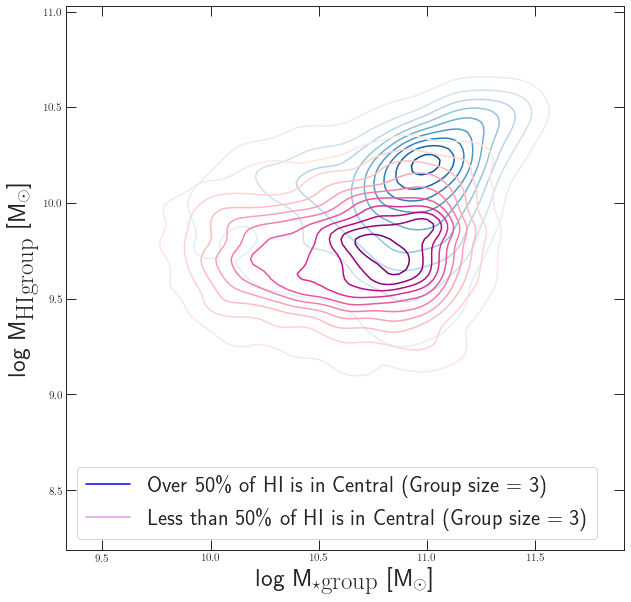

In [294]:
High_percentage = 50
Low_percentage = 50
Nsize_group = 3


fig = plt.figure(figsize=(10,10))                                                               
ax = fig.add_subplot(1,1,1)

#sns.set_style("white")
#sns.set(font_scale=2)
sns.set_style("ticks", {"xtick.major.size":10, "ytick.major.size":10,
						"xtick.minor.size":6,"ytick.minor.size":6})
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
#matplotlib.rcParams.update({'font.size': fsize, 'xtick.major.size': 10, 'ytick.major.size': 10, 'xtick.major.width': 1, 'ytick.major.width': 1, 'ytick.minor.size': 5, 'xtick.minor.size': 5, 'xtick.direction': 'in', 'ytick.direction': 'in', 'axes.linewidth': 1, 'text.usetex': True, 'font.family': 'serif', 'font.serif': 'Times New Roman', 'legend.numpoints': 1, 'legend.columnspacing': 1, 'legend.fontsize': fsize-4, 'xtick.top': True, 'ytick.right': True})


#sns.set_style("white")
#sns.kdeplot(np.log10(df_percent['GroupStellarMass'][ (df_percent['Percent'] >= High_percentage) & (df_percent['GroupSize']==5) ]), 
#            np.log10(df_percent['GroupHIMass'][ (df_percent['Percent'] >= High_percentage) & (df_percent['GroupSize']==5) ]), cmap='Purples', 
#            label= 'Over {0}\% of HI is in Central (Group size = {1})'.format(High_percentage, Nsize_group)) #shade=True, shade_lowest=False, 

#sns.kdeplot(np.log10(df_percent['GroupStellarMass'][ (df_percent['Percent'] >= High_percentage) & (df_percent['GroupSize']==3) ]), 
#            np.log10(df_percent['GroupHIMass'][ (df_percent['Percent'] >= High_percentage) & (df_percent['GroupSize']==3) ]), cmap='Blues', 
#            label= 'Over {0}\% of HI is in Central (Group size = {1})'.format(High_percentage, Nsize_group)) #shade=True, shade_lowest=False, 

sns.kdeplot(np.log10(df_percent['GroupStellarMass'][ (df_percent['Percent'] >= High_percentage) & (df_percent['GroupSize']==Nsize_group) ]), 
            np.log10(df_percent['GroupHIMass'][ (df_percent['Percent'] >= High_percentage) & (df_percent['GroupSize']==Nsize_group) ]), cmap='Blues', 
            label= 'Over {0}\% of HI is in Central (Group size = {1})'.format(High_percentage, Nsize_group)) #shade=True, shade_lowest=False, 


sns.kdeplot(np.log10(df_percent['GroupStellarMass'][ (df_percent['Percent'] < Low_percentage) & (df_percent['GroupSize']==Nsize_group) ]), 
            np.log10(df_percent['GroupHIMass'][ (df_percent['Percent'] < Low_percentage) & (df_percent['GroupSize']==Nsize_group) ]), cmap='RdPu', 
            label= 'Less than {0}\% of HI is in Central (Group size = {1})'.format(Low_percentage, Nsize_group))



ax.set_xlabel(r'log M$_{\star\textrm{group}}$ [M$_{\odot}$]', fontsize=25)
ax.set_ylabel(r'log M$_{\textrm{HI}\textrm{group}}$ [M$_{\odot}$]',fontsize=25)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

plt.legend(loc=3)
leg = ax.get_legend()
leg.legendHandles[0].set_color('blue')
leg.legendHandles[1].set_color('plum')
#leg.legendHandles[2].set_color('plum')
#plt.ylim(9.1,11)
plt.show()


In [60]:
matplotlib.__version__ #has to be 3.0.3; For sure is not working with 2.2.2
#import numpy as np
import pylab
from scipy.stats import skewnorm
from numpy.random import normal, multivariate_normal
from chainconsumer import ChainConsumer

#%matplotlib inline

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


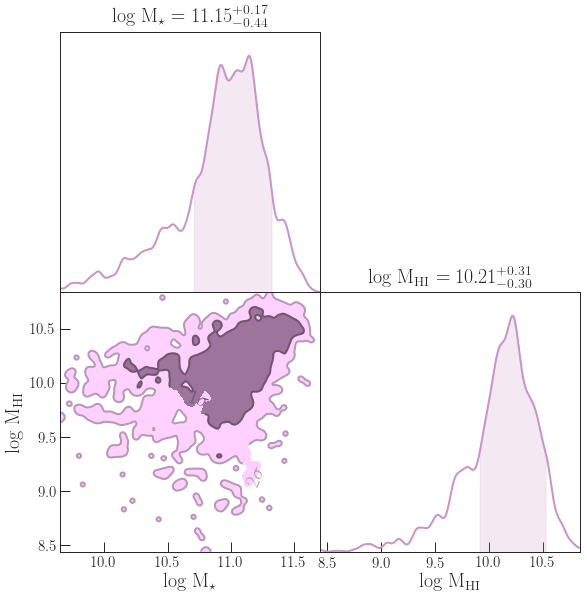

In [295]:
High_percentage = 60
Low_percentage = 50
Nsize_group = 3

x, y = np.log10(df_percent['GroupStellarMass'][df_percent['Percent'] >= High_percentage]), np.log10(df_percent['GroupHIMass'][df_percent['Percent'] >= High_percentage])

parameters = ["$\mathrm{log}$ $\mathrm{M}_{\star}$", "$\mathrm{log}$ $\mathrm{M}_{\mathrm{HI}}$"]
c = ChainConsumer().add_chain([x, y], parameters=parameters, name='Over {0}\% of HI is in Central'.format(High_percentage))

#properties at: https://samreay.github.io/ChainConsumer/chain_api.html
# The default case, so you don't need to specify: sigma2d gives  levels for 1D Gaussians - ie confidence levels of 68% and 95%.
#if sigma2d True : onfidence levels for 2D Gaussians, where 1 and 2 σ represents 39% and 86% confidence levels respectively

c.configure(statistics='max', flip=False, sigma2d=False, diagonal_tick_labels=False,  linewidths=2, linestyles=['-'],
            label_font_size=20, tick_font_size=15, contour_labels='sigma', contour_label_font_size=20, shade_alpha=1, colors='#c994c7', spacing=0)   # max_ticks=4 ; smooth=0

fig = c.plotter.plot()
fig.set_size_inches(5.5 + fig.get_size_inches())  # Resize fig for doco. You don't need this.
plt.show()

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


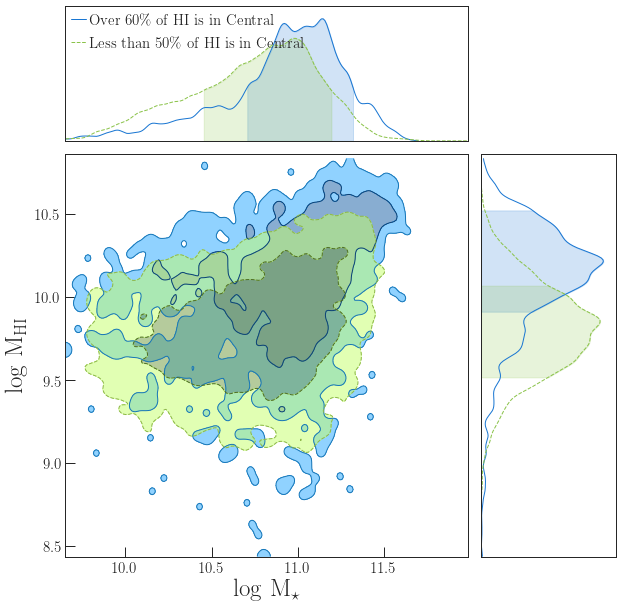

In [296]:
High_percentage = 60
Low_percentage = 50
Nsize_group = 3

x1, y1 = np.log10(df_percent['GroupStellarMass'][df_percent['Percent'] >= High_percentage]), np.log10(df_percent['GroupHIMass'][df_percent['Percent'] >= High_percentage])
x2, y2 = np.log10(df_percent['GroupStellarMass'][df_percent['Percent'] < Low_percentage]), np.log10(df_percent['GroupHIMass'][df_percent['Percent'] < Low_percentage])

parameters = ["$\mathrm{log}$ $\mathrm{M}_{\star}$", "$\mathrm{log}$ $\mathrm{M}_{\mathrm{HI}}$"]

c = ChainConsumer()
c.add_chain([x1, y1], parameters=parameters, name='Over {0}\% of HI is in Central'.format(High_percentage))
c.add_chain([x2, y2], parameters=parameters, name='Less than {0}\% of HI is in Central'.format(Low_percentage))


#Change sigmas to only 1 and it will show only 95%
c.configure(statistics='max', linestyles=["-", "--"], linewidths=[1.0, 1.0],  sigma2d=False, sigmas=[1,2], diagonal_tick_labels=False,
            legend_kwargs={"loc": "upper left", "fontsize": 15},
            legend_color_text=False, legend_location=(0, 0),
           label_font_size=25, tick_font_size=15, contour_label_font_size=20) #colors=['#2b8cbe', '#f4a582'],

fig = c.plotter.plot(figsize=1.5)
fig.set_size_inches(4.5 + fig.get_size_inches())  # Resize fig for doco. You don't need this.

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
/home/rdzudzar/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/rdzudzar/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


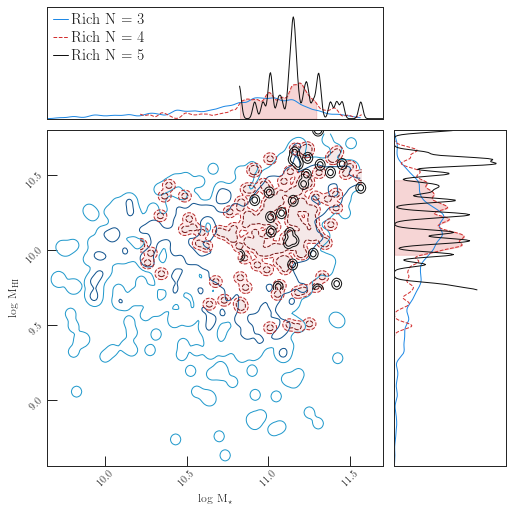

In [63]:
High_percentage = 50
Low_percentage = 50
Nsize_group = 4

x1, y1 = np.log10(df_percent['GroupStellarMass'][ (df_percent['Percent'] >= High_percentage) & (df_percent['GroupSize']==3) ]), np.log10(df_percent['GroupHIMass'][ (df_percent['Percent'] >= High_percentage) & (df_percent['GroupSize']==3) ])
    
x2, y2 = np.log10(df_percent['GroupStellarMass'][ (df_percent['Percent'] >= High_percentage) & (df_percent['GroupSize']==4) ]), np.log10(df_percent['GroupHIMass'][ (df_percent['Percent'] >= High_percentage) & (df_percent['GroupSize']==4) ])

x3, y3 = np.log10(df_percent['GroupStellarMass'][ (df_percent['Percent'] >= High_percentage) & (df_percent['GroupSize']==5) ]), np.log10(df_percent['GroupHIMass'][ (df_percent['Percent'] >= High_percentage) & (df_percent['GroupSize']==5) ])

parameters = ["$\mathrm{log}$ $\mathrm{M}_{\star}$", "$\mathrm{log}$ $\mathrm{M}_{\mathrm{HI}}$"]

c = ChainConsumer()
c.add_chain([x1, y1], parameters=parameters, name="Rich N = 3")
c.add_chain([x2, y2], parameters=parameters, name="Rich N = 4")
c.add_chain([x3, y3], parameters=parameters, name="Rich N = 5")

c.configure(linestyles=["-", "--", "-"], linewidths=[1.0, 1.0, 1.0],
            legend_kwargs={"loc": "upper left", "fontsize": 15},
            legend_color_text=False, legend_location=(0, 0),
            colors=["#1E88E5", "#D32F2F", "#111111"],
            shade=[False, True, True],
            shade_alpha=[0.2, 0.1, 0.0], bar_shade=[False, True, True])
fig = c.plotter.plot()

fig.set_size_inches(4.5 + fig.get_size_inches())  # Resize fig for doco. You don't need this.


# Pair plot

In [383]:
df_pair = pd.DataFrame({'GroupStellarMass'      : np.log10(g_st),
                           'GroupHIMass'        : np.log10(g_m),
                           'Percent'            : percentage,
                           'GroupSize'          : grp_length,
                           'BTTcentral'         : BTT_cen.ravel() ,
                            'Mvircen'           : Mvir_cen.ravel(),
                           'Rvircen'            : Rvir_cen.ravel(),# })
                           'RoundedPercent'     : rounded_per})

In [382]:
import math

def roundup(x):
    return int(math.ceil(x / 5.0)) * 5

rounded_per = []
for i in df_pair['Percent']:
    A = roundup(i)#_test = (central_mass.ravel()/g_m)*100
    rounded_per.append(A)
print(rounded_per[0:10])

[95, 35, 45, 10, 15, 30, 25, 90, 0, 5]


INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


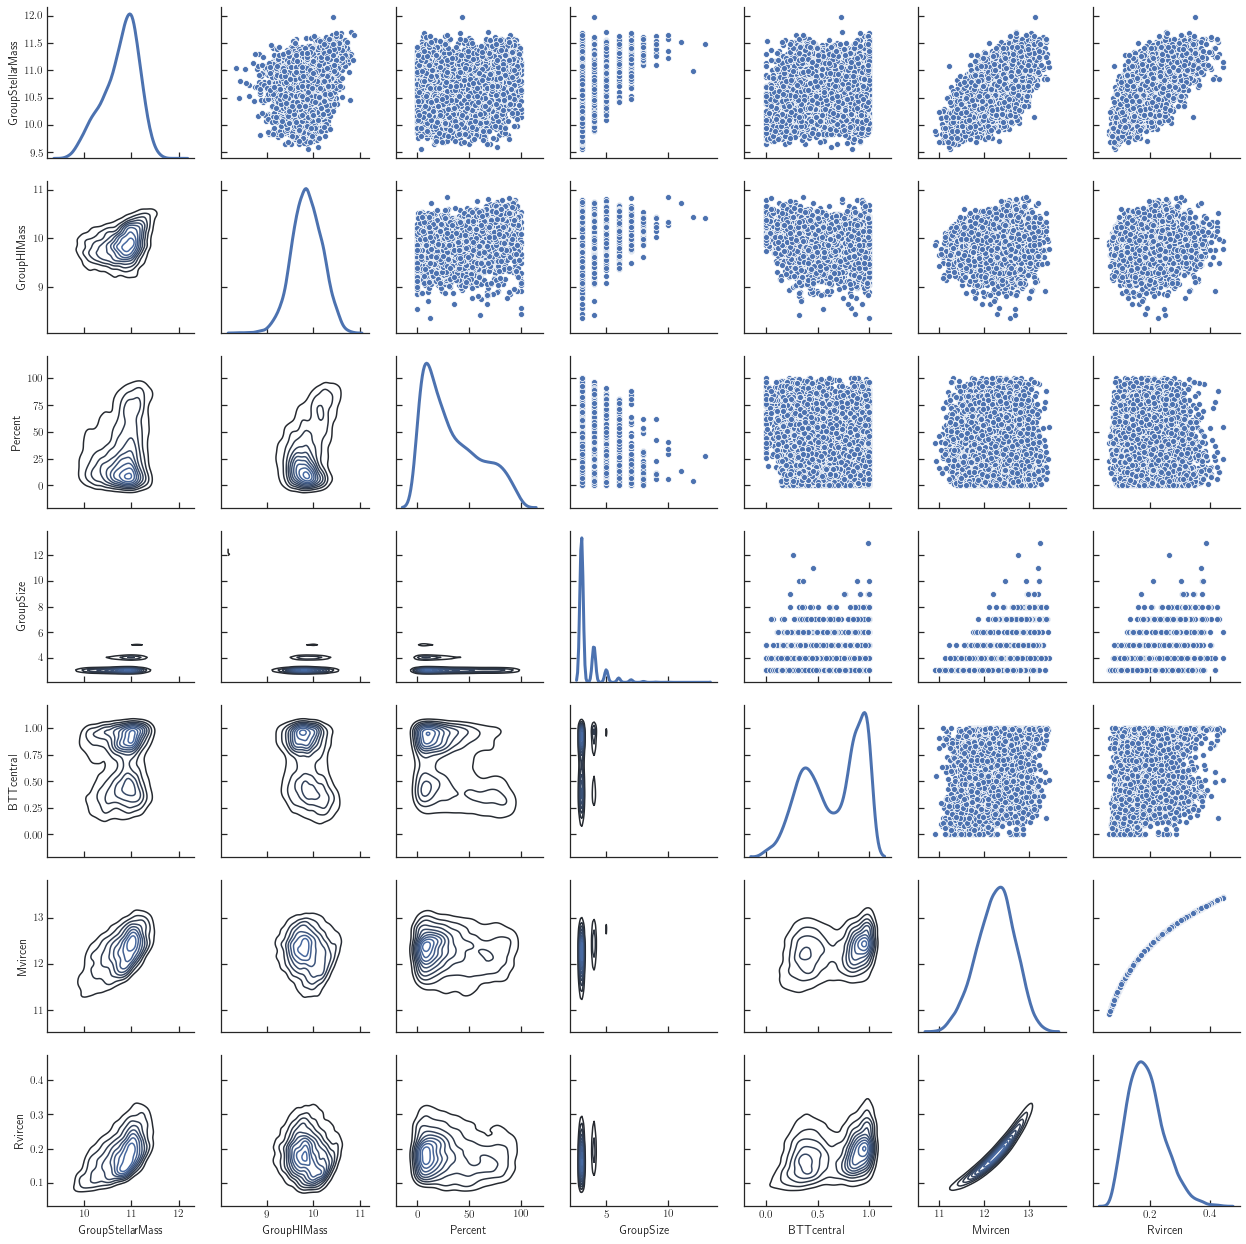

In [298]:

sns.set(font_scale=1)
sns.set_style("ticks", {"xtick.major.size":10, "ytick.major.size":10,
						"xtick.minor.size":6,"ytick.minor.size":6})
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})


g = sns.PairGrid(df_pair, diag_sharey=False)
g.map_lower(sns.kdeplot)
g.map_upper(sns.scatterplot)
g.map_diag(sns.kdeplot, lw=3)

# To hide upper scatter plot axies: axis
#for i, j in zip(*np.triu_indices_from(g.axes, 1)):
#    g.axes[i, j].set_visible(False)


INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


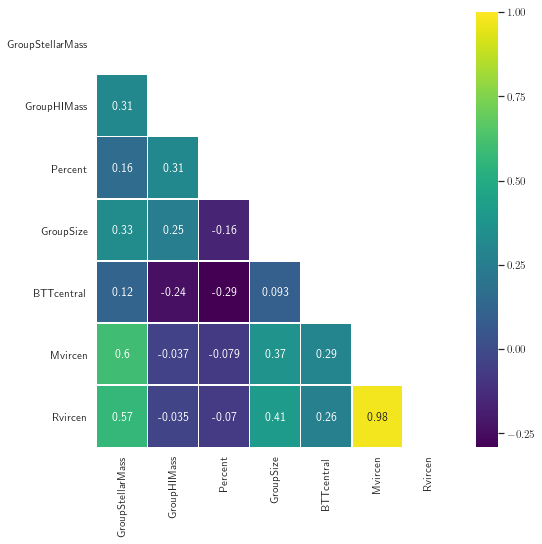

In [327]:
fig = plt.figure(figsize=(8,8))                                                               
ax = fig.add_subplot(1,1,1)

corr = df_pair.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, annot=True, cmap='viridis',  linewidths=.5, mask=mask, vmax=1,
        xticklabels=corr.columns,
        yticklabels=corr.columns)

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


<Figure size 1280x800 with 0 Axes>

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


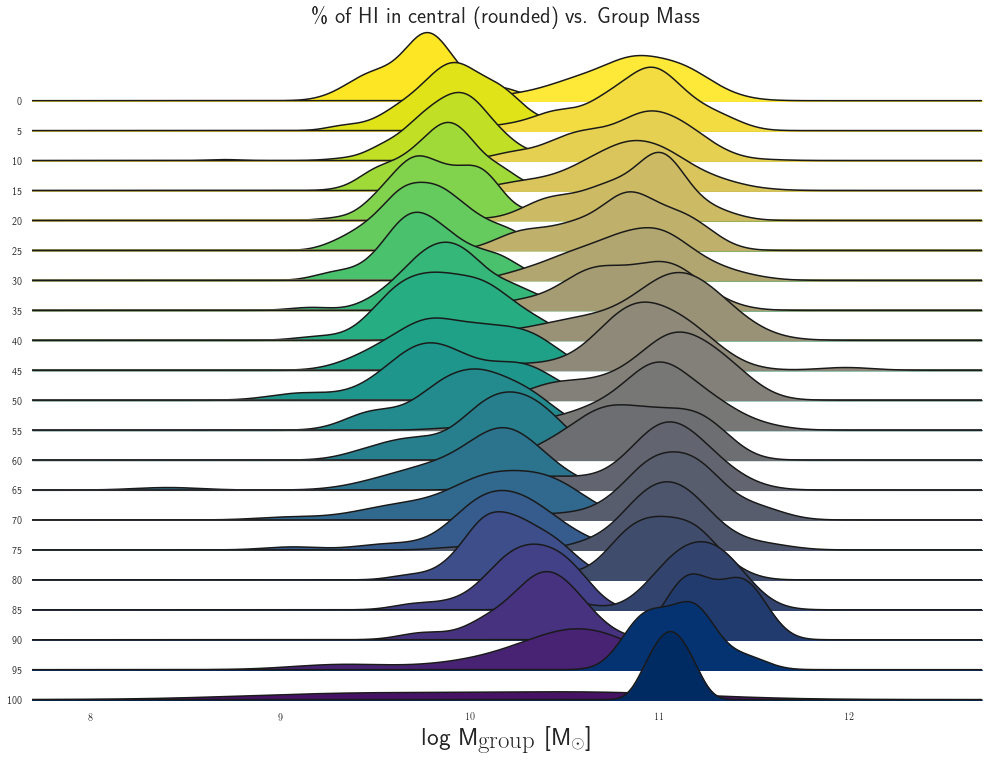

In [468]:
# Import Data
#mpg = pd.read_csv("https://github.com/selva86/datasets/raw/master/mpg_ggplot2.csv")

# Draw Plot
plt.figure(figsize=(16,10), dpi= 80)
fig, axes = joypy.joyplot(df_pair[df_pair['GroupSize']==4], column=['GroupHIMass', 'GroupStellarMass'], by="RoundedPercent", ylim='own', figsize=(14,10),hist=False, bins=50, overlap=1, colormap=[cm.viridis_r, cm.cividis_r])
#axes = joypy.joyplot(df_pair[df_pair['GroupSize']==3], column=['GroupHIMass'], by="RoundedPercent", ylim='own', figsize=(14,10),hist=False, bins=50, overlap=2, colormap=[cm.cividis_r])

# Decoration
plt.title(r'\% of HI in central (rounded) vs. Group Mass', fontsize=22)

axes[-1].set_xlabel(r' log M$_{\textrm{group}}$ [M$_{\odot}$]', fontsize=25)

#plt.xaxis('A')
plt.show()

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


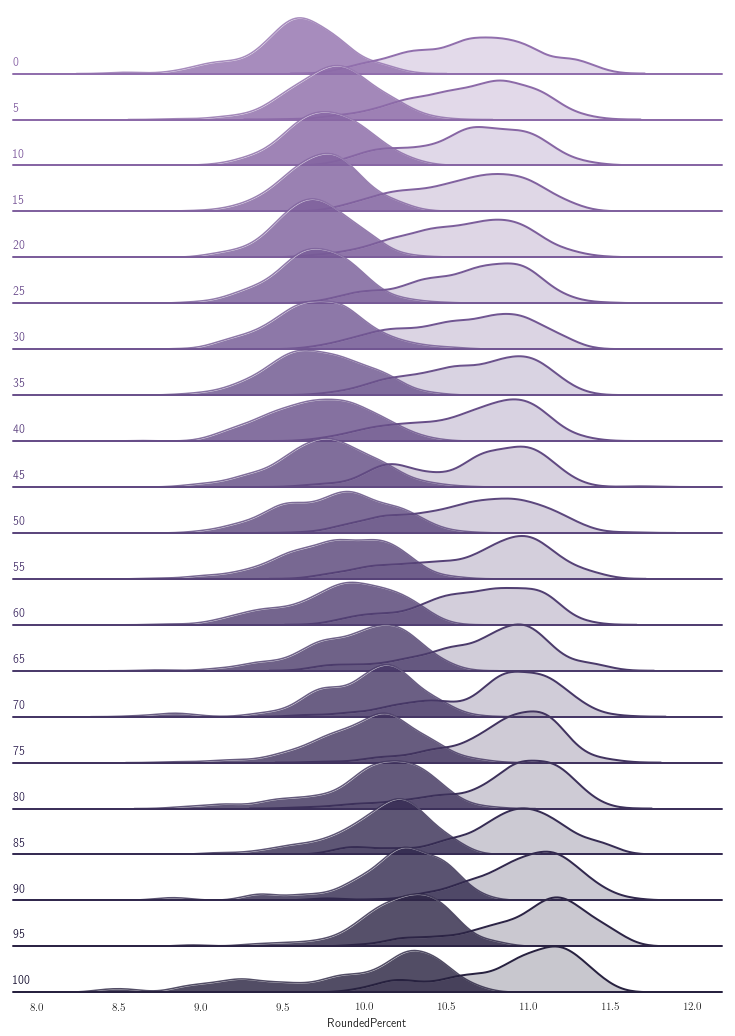

In [456]:

sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

pal = sns.cubehelix_palette(21, rot=.15, light=.5)
g = sns.FacetGrid(df_pair[df_pair['GroupSize']==3], row="RoundedPercent", hue='RoundedPercent', aspect=15, height=.7, palette=pal, legend_out=True) #hue='GroupSize'
#g = sns.FacetGrid(df_pair[df_pair['GroupSize']==4], row="RoundedPercent", hue='RoundedPercent', aspect=15, height=.7, palette=pal, legend_out=True) #hue='GroupSize'

# Draw the densities in a few steps
g.map(sns.kdeplot, "GroupHIMass", clip_on=True, shade=True, alpha=0.8, lw=1.5, bw=.1)
g.map(sns.kdeplot, "GroupStellarMass", clip_on=True, shade=True, lw=2, bw=.1)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

#Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, 'RoundedPercent')

g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)


# Pair plot for specific parameters

In [462]:
#sns.set(font_scale=1)
#sns.set_style("ticks", {"xtick.major.size":10, "ytick.major.size":10,
#						"xtick.minor.size":6,"ytick.minor.size":6})
#sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
#
#
## Adding size, hue, palette and specify variables in vars
#variables = ["Percent", "GroupHIMass", "Rvircen"]
#g = sns.pairplot(df_pair, height=5, hue="GroupSize", palette="Purples", vars=variables,
#                plot_kws = {'s': 80, 'edgecolor': 'k'})
##g.map_diag(plt.hist, density=True)
#g._legend.get_title().set_fontsize(20) 
#
#
## Axis Labels
#replacements = {"GroupStellarMass": r'log M$_{\star\textrm{group}}$ [M$_{\odot}$]', 
#                "GroupHIMass"     : r'log M$_{\textrm{HI}\textrm{group}}$ [M$_{\odot}$]',
#                "Percent"         : r'\% of HI in Central',
#                "GroupSize"       : r'Group Size'}
#
#for i in range(len(variables)):
#    for j in range(len(variables)):
#        xlabel = g.axes[i][j].get_xlabel()
#        ylabel = g.axes[i][j].get_ylabel()
#        if xlabel in replacements.keys():
#            g.axes[i][j].set_xlabel(replacements[xlabel], fontsize=17)
#        if ylabel in replacements.keys():
#            g.axes[i][j].set_ylabel(replacements[ylabel], fontsize=17)
#            
##Legend
#for i in range(len(g.fig.get_children()[-1].texts)):
#    label = g.fig.get_children()[-1].texts[i].get_text()
#    if label in replacements.keys():
#        g.fig.get_children()[-1].texts[i].set_text(replacements[label])
#g.fig.get_children()[-1].set_bbox_to_anchor((1.05, 0.5, 0, 0))
#
#


In [467]:
from __future__ import unicode_literals
import joypy
from matplotlib import cm


INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


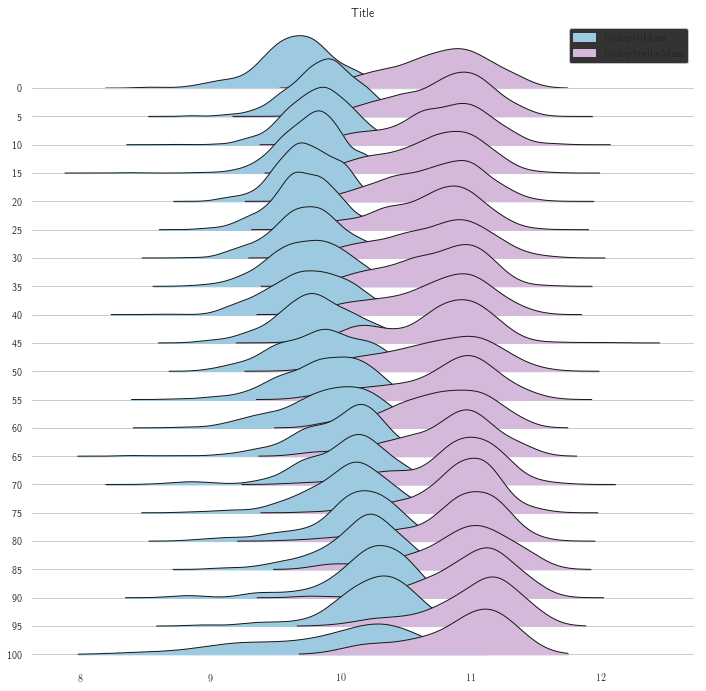

In [470]:
%matplotlib inline
try:
    #labels=[y if y%1==0 else None for y in list(df_pair.GroupHIMass.unique())]
    fig, axes = joypy.joyplot(df_pair, by="RoundedPercent", column=["GroupHIMass","GroupStellarMass"], range_style='own',
                          grid="y", linewidth=1, legend=True, loc="best", figsize=(10,10), overlap=1,
                          title="Title", color=['#9ecae1', '#d4b9da']
                          )        
except ValueError:
    pass  # do nothing!

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


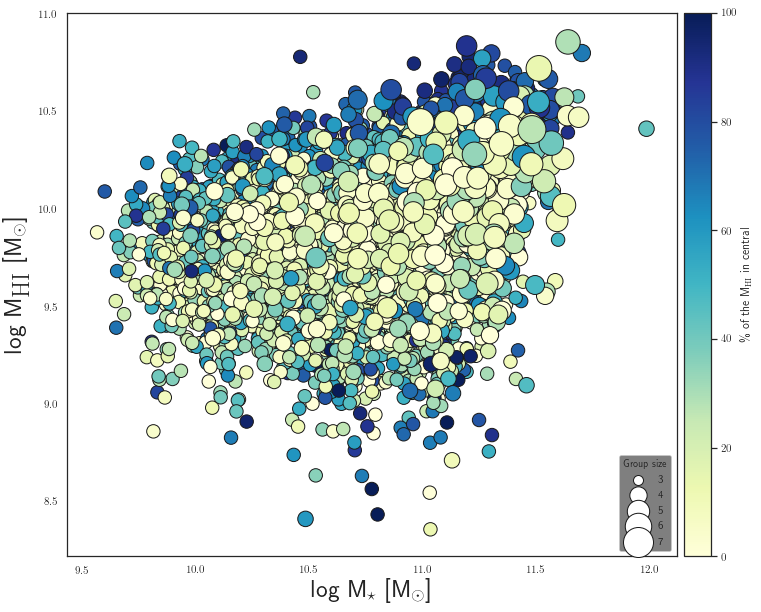

In [465]:

fig = plt.figure(figsize=(13,10))                                                               
ax = fig.add_subplot(1,1,1)

cm = plt.cm.get_cmap('YlGnBu')
#Numpy doesn't know what you might have stored in a object array, 
#df_percent['StellarM'] = df_percent['StellarM'].astype(np.float64) 
#df_percent['HImass'] = df_percent['HImass'].astype(np.float64)

#BE CAREFUL HERE! Constructed sizes are OK for current groups; will need change
#s = 80*df_percent['Group_size']

sizes = [100,300,500,700,900]
im = plt.scatter(np.log10(df_percent['GroupStellarMass']), np.log10(df_percent['GroupHIMass']), s=60*df_percent['GroupSize'],
                        c=df_percent['Percent'], edgecolor='k', cmap=cm, label=r'Groups ($N\geq3$) properties')

fig.colorbar(im, ax=ax, orientation='vertical', label=r'\% of the M$_{\mathrm{HI}}$ in central',
            pad=0.01)

ax.set_xlabel(r'log M$_{\star}$ [M$_{\odot}$]', fontsize=25)
ax.set_ylabel(r'log M$_{\textrm{HI}}$ [M$_{\odot}$]',fontsize=25)
ax.legend(loc=4)
leg = ax.get_legend()
leg.legendHandles[0].set_color('k')

l1 = plt.scatter([],[], s=100, color='white',edgecolors='k')
l2 = plt.scatter([],[], s=300, color='white',edgecolors='k')
l3 = plt.scatter([],[], s=500, color='white',edgecolors='k')
l4 = plt.scatter([],[], s=700, color='white',edgecolors='k')
l5 = plt.scatter([],[], s=900, color='white',edgecolors='k')

labels = ["3", "4", "5", "6", '7']

leg = plt.legend([l1, l2, l3, l4, l5], labels, ncol=1, loc=4, framealpha=0.5)
leg.set_title('Group size')                   
                   
#plt.ylim(6,11)

In [68]:
# Initiate figure and how large it will be
def HI_group_distribution(groups_dict):
    
    """
    Make 3x3 plot (HI mass vs Stellar mass) with galaxy groups based on the number of galaxies in a group and separate in each group central
    and satellite galaxy.
    
    Parameters
    ==========
    groups_dict: Dictionary. Keyed by the group size. Use: ``groups_dict[group_size]["Centrals"]``
                 Extracts groups with size N and the satellite & central galaxies
                 Created dictionary from (def create_cen_sat_from_groups_dict)
  
    Returns
    =======
    3x3 Figure with M_HI versus M_*
    
    Usage
    =====
    To use type: ``mhi_vs_ms_3x3(updated_dict) ``
                 Where updated_dict is the dictionary that is parsed to plotting function
                 ``updated_dict = create_cen_sat_from_groups_dict(groups, store_cen_indices)``
    
    """
    
    
    fig, ax = plt.subplots(nrows=4, ncols=4, sharex='col', sharey='row', figsize=(18, 15))
    
    #ax[0][0].plot(np.log10(Mstellar_single_gal), np.log10(Mcoldgas_single_gal), 'o', color='lightgrey',markersize=8, label='Single galaxies')
    sat_g = []
    # Put plot in row and columns:3by3 are 00, 01, 02, 10, 11, 12, 20, 21, 22 
    row_count = 0
    for size in trange(1, 16, 1): #I'm planning to have 1-9 sized groups. Made to form trange(1, 9, 1) as 3x3 pannels 
            
        if size % 4 == 0:
            row_count += 1
        this_ax = ax[row_count, size%4] #Axis. Created for plotting 3x3 plots
        
        group_size = size+1 # Select number of galaxies per group --- adding +1 because it is counting from 0.
    
        central_gals = groups_dict[group_size]["Centrals"]  #List of integers. Contains indices of central galaxies.  List is obtained through the dictionary. 
        sat_gals = groups_dict[group_size]["Satellites"] #List of integers. Contains indices of satellite galaxies. List is obtained through the dictionary.

        sat_mass = np.sum(G['DiscHI'],axis=1)[sat_gals]
        sat_g.append(sat_gals)
        
        sum_of_all_satellites = np.sum(sat_mass)
        print(sum_of_all_satellites)
        
        sum_satellite_stellar = np.sum(G['StellarMass'][sat_gals])
        
        percentage = (np.sum(G['DiscHI'],axis=1)[central_gals]/(np.sum(G['DiscHI'],axis=1)[central_gals]+sum_of_all_satellites))*100
        #per_cent.append(percentage[0])
        groupHI = (np.sum(G['DiscHI'],axis=1)[central_gals]*1e10/h+1) + sum_of_all_satellites*1e10/h
        groupSt = (G['StellarMass'][central_gals]*1e10/h+1) + sum_satellite_stellar*1e10/h
        
        # Do plotting of groups of N-length; it will be placed on each subplot + +.
        # Centrals

        im = this_ax.scatter(np.log10(groupSt), np.log10(groupHI), s=300,
                        c=percentage, edgecolor='k', cmap=cm)

        # Add label for each sub-plot to know the group size and what is central/satellite
        this_ax.plot([], [], 'o', color='white', label='Groups of %.f' %group_size)
        this_ax.plot([], [], 'o', color='lightgrey', label='Single galaxies')
        this_ax.plot([], [], 'o', color='#1f78b4', markersize=8, label='Satellite')
        this_ax.plot([], [], 'o', color='white', markeredgecolor='#1f78b4', markersize=8, markeredgewidth=2, label='Central')
        #Add legend    
        leg = this_ax.legend(loc=4,frameon=True,fancybox=True, framealpha=0.6, fontsize=16)
        
    # Add x and y axis labels only on the plot edges since there will be no space between panels
    for row in range(3):
        this_ax = ax[row,0]
        this_ax.set_ylabel(r'log M$_{\textrm{HI}}$ [M$_{\odot}$]',fontsize=25)
    for col in range(3):
        this_ax = ax[2,col]
        this_ax.set_xlabel(r'log M$_{\star}$ [M$_{\odot}$]', fontsize=25)
    # Tight layout and remove spacing between subplots
    plt.tight_layout()
    # My first plot is only single galaxies so I add legend separately
    ax[0][0].legend(loc=4,frameon=True,fancybox=True, framealpha=0.6, fontsize=16)

    plt.subplots_adjust(wspace = 0.0, hspace = 0.0)
    plt.show()
    print(sat_g)
    #return fig


# Bulge to total ratio (BTT)

In [78]:
#BTT_cen.ravel().tolist()

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


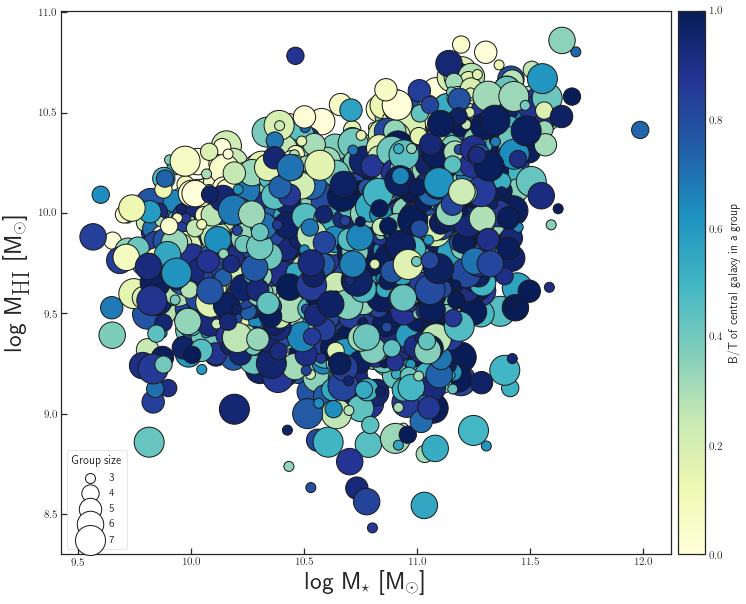

In [79]:

fig = plt.figure(figsize=(13,10))                                                               
ax = fig.add_subplot(1,1,1)

cm = plt.cm.get_cmap('YlGnBu')
#Numpy doesn't know what you might have stored in a object array, 
BTT_cen = BTT_cen.astype(np.float64) 
#df_percent['HImass'] = df_percent['HImass'].astype(np.float64)

#BE CAREFUL HERE! Constructed sizes are OK for current groups; will need change
#s = 80*df_percent['Group_size']
sizes = [100,300,500,700,900]
im = plt.scatter(np.log10(df_percent['GroupStellarMass']), np.log10(df_percent['GroupHIMass']), s=sizes,
                        c=BTT_cen.ravel().tolist(), edgecolor='k', cmap=cm, label=r'Groups ($N\geq3$) properties')

fig.colorbar(im, ax=ax, orientation='vertical', label=r'B/T of central galaxy in a group',
            pad=0.01)

ax.set_xlabel(r'log M$_{\star}$ [M$_{\odot}$]', fontsize=25)
ax.set_ylabel(r'log M$_{\textrm{HI}}$ [M$_{\odot}$]',fontsize=25)
ax.legend(loc=3)
leg = ax.get_legend()
leg.legendHandles[0].set_color('k')

l1 = plt.scatter([],[], s=100, color='white',edgecolors='k')
l2 = plt.scatter([],[], s=300, color='white',edgecolors='k')
l3 = plt.scatter([],[], s=500, color='white',edgecolors='k')
l4 = plt.scatter([],[], s=700, color='white',edgecolors='k')
l5 = plt.scatter([],[], s=900, color='white',edgecolors='k')

labels = ["3", "4", "5", "6", '7']

leg = plt.legend([l1, l2, l3, l4, l5], labels, ncol=1, loc=3, framealpha=0.5)
leg.set_title('Group size')                   
                   
#plt.ylim(6,11)

## N times N with B/T

In [140]:
# Initiate figure and how large it will be
def mhi_vs_ms_3x3_colorbar(groups_dict):
    
    """
    Make 3x3 plot (HI mass vs Stellar mass) with galaxy groups based on the number of galaxies in a group and separate in each group central
    and satellite galaxy.
    
    Parameters
    ==========
    groups_dict: Dictionary. Keyed by the group size. Use: ``groups_dict[group_size]["Centrals"]``
                 Extracts groups with size N and the satellite & central galaxies
                 Created dictionary from (def create_cen_sat_from_groups_dict)
  
    Returns
    =======
    3x3 Figure with M_HI versus M_*
    
    Usage
    =====
    To use type: ``mhi_vs_ms_3x3(updated_dict) ``
                 Where updated_dict is the dictionary that is parsed to plotting function
                 ``updated_dict = create_cen_sat_from_groups_dict(groups, store_cen_indices)``
    
    """
    
    
    fig, ax = plt.subplots(nrows=4, ncols=5, sharex='col', sharey='row', figsize=(18, 15))
    
    #ax[0][0].plot(np.log10(Mstellar_single_gal), np.log10(Mcoldgas_single_gal), 'o', color='lightgrey',markersize=8, label='Single galaxies')
    
    cm = plt.cm.get_cmap('YlGnBu')
    ax[0][0].scatter(np.log10(Mstellar_single_gal), 
                     np.log10(Mcoldgas_single_gal), 
                     c = BTT_single, s=80, edgecolor='k', cmap=cm)
    
    # Put plot in row and columns:3by3 are 00, 01, 02, 10, 11, 12, 20, 21, 22 
    row_count = 0
    for size in trange(1, 20, 1): #I'm planning to have 1-9 sized groups. Made to form trange(1, 9, 1) as 3x3 pannels 
            
        if size % 5 == 0:
            row_count += 1
        this_ax = ax[row_count, size%5] #Axis. Created for plotting 3x3 plots
        
        group_size = size+1 # Select number of galaxies per group --- adding +1 because it is counting from 0.
    
        central_gals = groups_dict[group_size]["Centrals"]  #List of integers. Contains indices of central galaxies.  List is obtained through the dictionary. 
        sat_gals = groups_dict[group_size]["Satellites"] #List of integers. Contains indices of satellite galaxies. List is obtained through the dictionary.
        
        BTT_central = groups_dict[group_size]["Centrals"]
        BTT_satellite = groups_dict[group_size]["Satellites"]
        
        # Plot single galaxies           
        #this_ax.plot(np.log10(Mstellar_single_gal), np.log10(Mcoldgas_single_gal), 'o', color='lightgrey',markersize=8)
        
            
        # Do plotting of groups of N-length; it will be placed on each subplot + +.
        # Centrals
        
        #im = plt.scatter(np.log10(df_percent['StellarM']+1), np.log10(df_percent['HImass']*1e10/h+1), s=80*df_percent['GroupSize'],
        #                c=df_percent['BTT_central'], edgecolor='k', cmap=cm, label=r'Groups ($N\geq3$) properties')
        
        cm = plt.cm.get_cmap('YlGnBu')
        this_ax.scatter(np.log10(G['StellarMass'][central_gals]*1e10/h), 
                         np.log10(np.sum(G['DiscHI'],axis=1)[central_gals]*1e10/h), 
                     c = BTT[BTT_central], s=80, edgecolor='k', cmap=cm)    
                     
        # Satellites
        im = this_ax.scatter(np.log10(G['StellarMass'][sat_gals]*1e10/h), 
                         np.log10(np.sum(G['DiscHI'],axis=1)[sat_gals]*1e10/h), 
                         c = BTT[BTT_satellite], s=80, cmap=cm)
    
        # Add label for each sub-plot to know the group size and what is central/satellite
        this_ax.plot([], [], 'o', color='white', label='Groups of %.f' %group_size)
        this_ax.plot([], [], 'o', color='lightgrey', label='Single galaxies')
        this_ax.plot([], [], 'o', color='#1f78b4', markersize=8, label='Satellite')
        this_ax.plot([], [], 'o', color='white', markeredgecolor='#1f78b4', markersize=8, markeredgewidth=2, label='Central')
        #Add legend    
        leg = this_ax.legend(loc=4,frameon=True,fancybox=True, framealpha=0.6, fontsize=16)
        
    # Add x and y axis labels only on the plot edges since there will be no space between panels
    for row in range(4):
        this_ax = ax[row,0]
        this_ax.set_ylabel(r'log M$_{\textrm{HI}}$ [M$_{\odot}$]',fontsize=25)
    for col in range(5):
        this_ax = ax[2,col]
        this_ax.set_xlabel(r'log M$_{\star}$ [M$_{\odot}$]', fontsize=25)
    # Tight layout and remove spacing between subplots
    plt.tight_layout()
    # My first plot is only single galaxies so I add legend separately
    
    # COLORBAR INSIDE SUBPLOT
    #from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    #cbaxes = inset_axes(ax[0][0], width="5%", height="50%", loc='center right') #loc=l, bbox_to_anchor=(0.6,0.5)
    #plt.colorbar(im, cax=cbaxes, ticks=[0.,0.5,1], orientation='vertical')
    #cbaxes.yaxis.set_ticks_position('left')
    
    ax[0][0].legend(loc=4,frameon=True,fancybox=True, framealpha=0.6, fontsize=20)

    plt.subplots_adjust(wspace = 0.0, hspace = 0.0)

    # COLORBAR for the entire plot
    plt.colorbar(im, ax=ax[:, 4], pad=0.01, label=r'B/T ratio')
    plt.show()
    #return fig



100%|██████████| 19/19 [00:07<00:00,  2.67it/s]
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


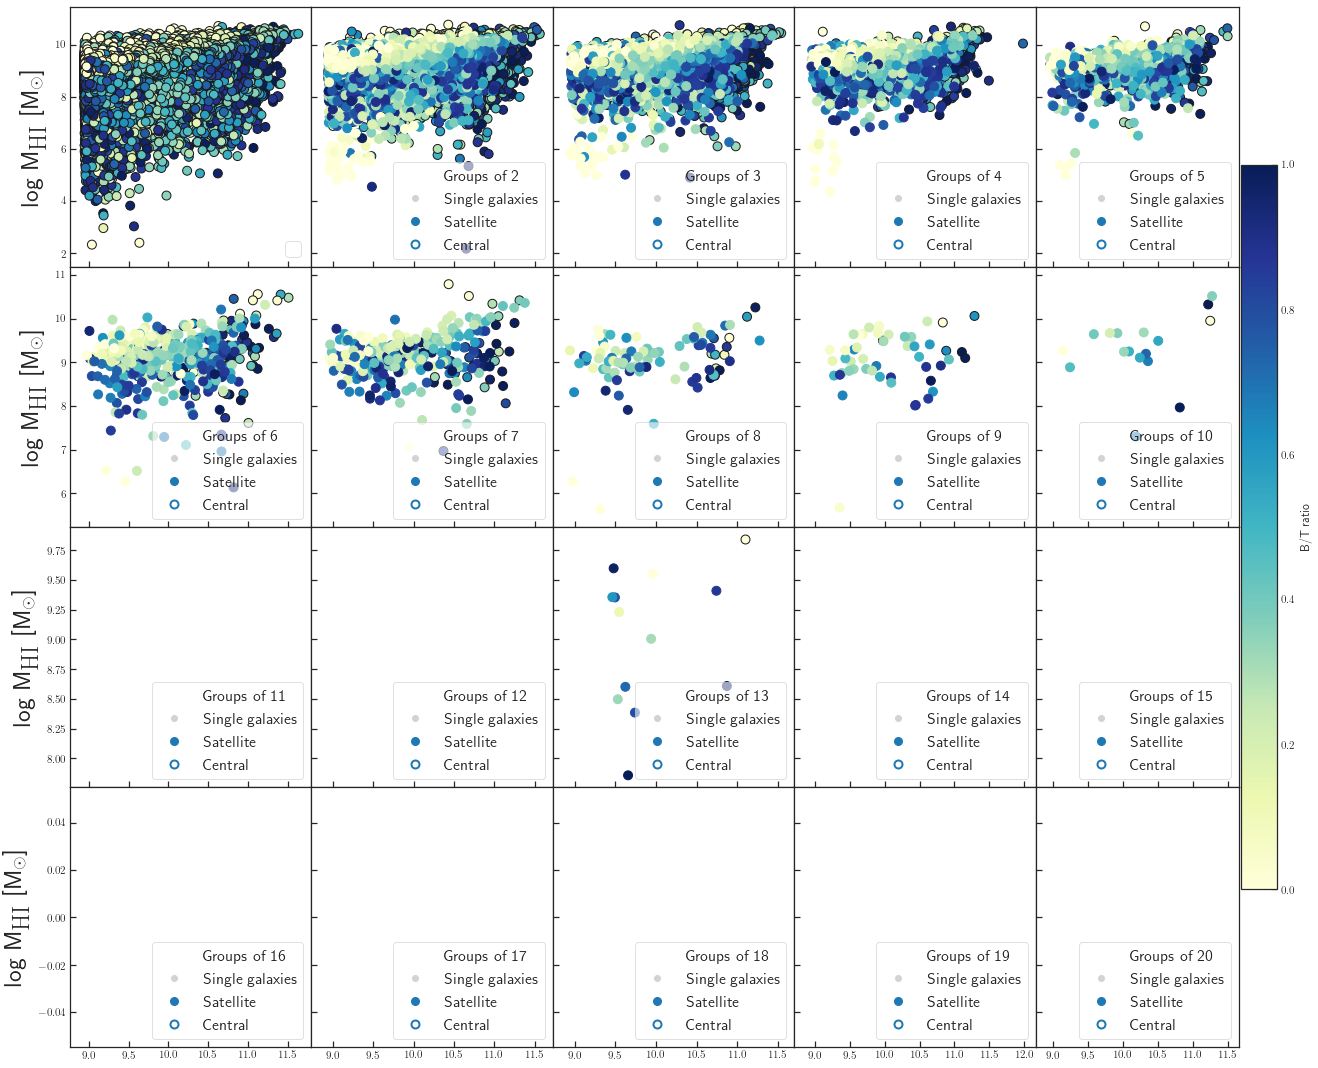

In [141]:
mhi_vs_ms_3x3_colorbar(updated_dict)

In [82]:
# Initiate figure and how large it will be
def BT_distribution(groups_dict):
    
    """
    Make 3x3 plot (HI mass vs Stellar mass) with galaxy groups based on the number of galaxies in a group and separate in each group central
    and satellite galaxy.
    
    Parameters
    ==========
    groups_dict: Dictionary. Keyed by the group size. Use: ``groups_dict[group_size]["Centrals"]``
                 Extracts groups with size N and the satellite & central galaxies
                 Created dictionary from (def create_cen_sat_from_groups_dict)
  
    Returns
    =======
    3x3 Figure with M_HI versus M_*
    
    Usage
    =====
    To use type: ``mhi_vs_ms_3x3(updated_dict) ``
                 Where updated_dict is the dictionary that is parsed to plotting function
                 ``updated_dict = create_cen_sat_from_groups_dict(groups, store_cen_indices)``
    
    """
    
    
    fig, ax = plt.subplots(figsize=(8,8))
    
    #ax[0][0].plot(np.log10(Mstellar_single_gal), np.log10(Mcoldgas_single_gal), 'o', color='lightgrey',markersize=8, label='Single galaxies')
    
    # Put plot in row and columns:3by3 are 00, 01, 02, 10, 11, 12, 20, 21, 22 
    
    BTT_c = []
    BTT_s = []
    
    for size in trange(1, 20, 1): #I'm planning to have 1-9 sized groups. Made to form trange(1, 9, 1) as 3x3 pannels 
    
        group_size = size+1 # Select number of galaxies per group --- adding +1 because it is counting from 0.
    
        central_gals = groups_dict[group_size]["Centrals"]  #List of integers. Contains indices of central galaxies.  List is obtained through the dictionary. 
        sat_gals = groups_dict[group_size]["Satellites"] #List of integers. Contains indices of satellite galaxies. List is obtained through the dictionary.
        
        BTT_central = groups_dict[group_size]["Centrals"]
        BTT_satellite = groups_dict[group_size]["Satellites"]
        
        BTT_c.extend(BTT[BTT_central])
        BTT_s.extend(BTT[BTT_satellite])
    
    binwidth=0.1
    bins = np.arange(0, 1.1, binwidth)
    plt.hist(BTT_s, bins=bins, color='#2c7fb8', edgecolor='k', linewidth=1, alpha=0.8, label='Satellite')
    plt.hist(BTT_c, bins=bins, color='white', edgecolor='#2c7fb8', linewidth=4, alpha=0.6, label='Central')

    
    leg = ax.legend(loc=1,frameon=True,fancybox=True, framealpha=0.6, fontsize=16)
    
    ax.set_xlabel(r'B/T ratio',fontsize=25)
    ax.set_ylabel(r'N$_{\textrm{galaxies}}$',fontsize=25)
    
    plt.tight_layout()

    plt.subplots_adjust(wspace = 0.0, hspace = 0.0)
    plt.xlim(-0.05,1.05)
    plt.show()
    #return fig



100%|██████████| 19/19 [00:00<00:00, 3215.84it/s]INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


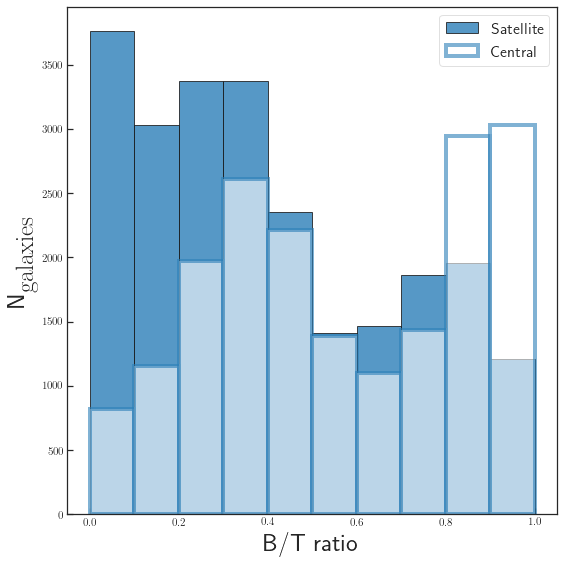

In [83]:
BT_distribution(updated_dict)

In [86]:
# Initiate figure and how large it will be
def mhi_vs_ms_colorbar(groups_dict):
    
    """
    Make 3x3 plot (HI mass vs Stellar mass) with galaxy groups based on the number of galaxies in a group and separate in each group central
    and satellite galaxy.
    
    Parameters
    ==========
    groups_dict: Dictionary. Keyed by the group size. Use: ``groups_dict[group_size]["Centrals"]``
                 Extracts groups with size N and the satellite & central galaxies
                 Created dictionary from (def create_cen_sat_from_groups_dict)
  
    Returns
    =======
    3x3 Figure with M_HI versus M_*
    
    Usage
    =====
    To use type: ``mhi_vs_ms_3x3(updated_dict) ``
                 Where updated_dict is the dictionary that is parsed to plotting function
                 ``updated_dict = create_cen_sat_from_groups_dict(groups, store_cen_indices)``
    
    """
    
    
    fig, ax = plt.subplots(figsize=(15, 12))
    
    #ax[0][0].plot(np.log10(Mstellar_single_gal), np.log10(Mcoldgas_single_gal), 'o', color='lightgrey',markersize=8, label='Single galaxies')
    
    # Put plot in row and columns:3by3 are 00, 01, 02, 10, 11, 12, 20, 21, 22 
    for size in trange(1, 9, 1): #I'm planning to have 1-9 sized groups. Made to form trange(1, 9, 1) as 3x3 pannels 
    
        group_size = size+1 # Select number of galaxies per group --- adding +1 because it is counting from 0.
    
        central_gals = groups_dict[group_size]["Centrals"]  #List of integers. Contains indices of central galaxies.  List is obtained through the dictionary. 
        sat_gals = groups_dict[group_size]["Satellites"] #List of integers. Contains indices of satellite galaxies. List is obtained through the dictionary.
        
        BTT_central = groups_dict[group_size]["Centrals"]
        BTT_satellite = groups_dict[group_size]["Satellites"]
        

        cm = plt.cm.get_cmap('YlGnBu')
        ax.scatter(np.log10(G['StellarMass'][central_gals]*1e10/h), 
                         np.log10(np.sum(G['DiscHI'],axis=1)[central_gals]*1e10/h), 
                     c = BTT[BTT_central], s=150, edgecolor='k', linewidth=1, cmap=cm)    
                     
        # Satellites
        ax.scatter(np.log10(G['StellarMass'][sat_gals]*1e10/h), 
                         np.log10(np.sum(G['DiscHI'],axis=1)[sat_gals]*1e10/h), 
                         c = BTT[BTT_satellite], s=150, cmap=cm)
    
        # Add label for each sub-plot to know the group size and what is central/satellite
        #ax.plot([], [], 'o', color='lightgrey', label='Single galaxies')
    ax.plot([], [], 'o', color='#1f78b4', markersize=10, label='Satellite')
    ax.plot([], [], 'o', color='white', markeredgecolor='k', markersize=10, markeredgewidth=3, label='Central')
        #Add legend  
        
    ax.set_xlabel(r'log M$_{\star}$ [M$_{\odot}$]', fontsize=25)
    ax.set_ylabel(r'log M$_{\textrm{HI}}$ [M$_{\odot}$]',fontsize=25)
    
    leg = ax.legend(loc=4,frameon=True,fancybox=True, framealpha=0.6, fontsize=16)

    plt.tight_layout()

    plt.subplots_adjust(wspace = 0.0, hspace = 0.0)
    
    # COLORBAR for the entire plot
    plt.colorbar(im, ax=ax, pad=0.01, label=r'B/T ratio')
    plt.show()
    #return fig


100%|██████████| 8/8 [00:02<00:00,  3.05it/s]
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


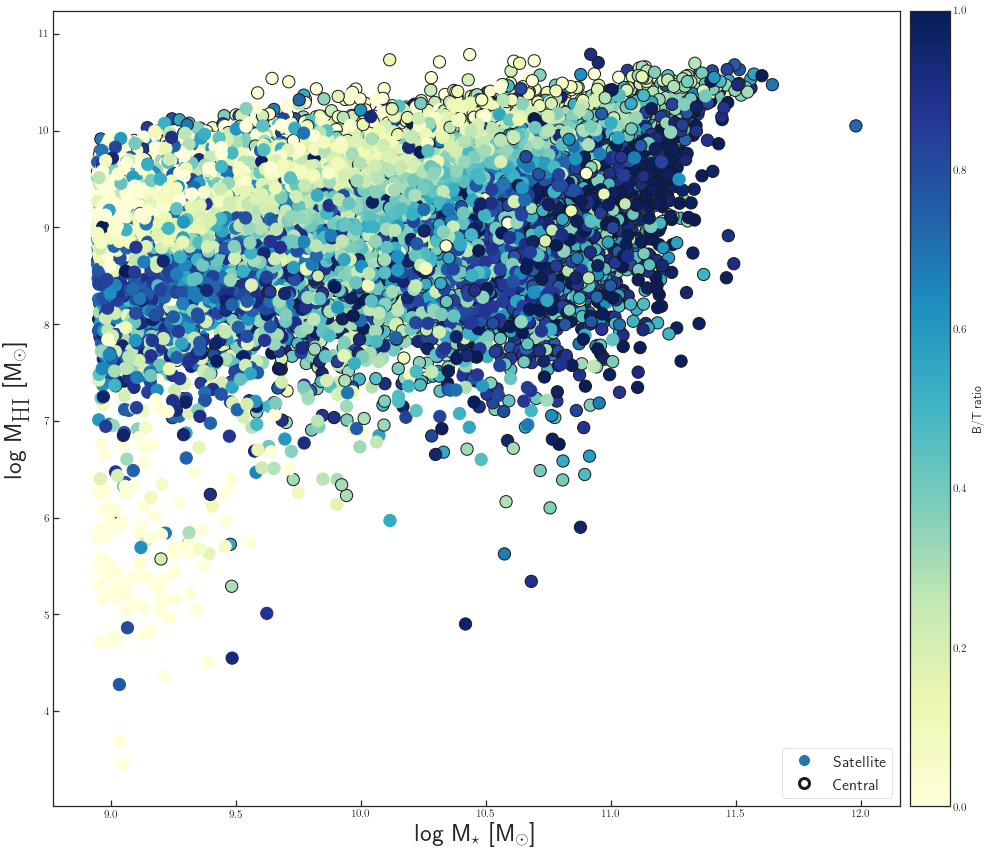

In [87]:
mhi_vs_ms_colorbar(updated_dict)

# How the group look like (Mvir/Rvir/Pos)
#### Make a function to extract parameters

In [84]:
for i in c_ind[0:5]:
    print(i, G['Rvir'][i][0:])


[1730] [0.27567366]
[2358] [0.18081096]
[2665] [0.08291441]
[3848] [0.14341983]
[4736] [0.15088257]


In [85]:
for i in g_ind[0:5]:
    print(G['Pos'][i][0:])

[[ 14.069526 497.66397   43.96974 ]
 [ 13.939832 497.74933   44.09529 ]
 [ 14.123639 497.45767   44.098263]]
[[  4.3075085  13.855656  499.77805  ]
 [  4.4794354  13.564551  499.93375  ]
 [  4.235369   13.813037  499.95203  ]]
[[ 54.3965    60.635124 499.44687 ]
 [ 54.26466   60.97239  499.54718 ]
 [ 54.440594  60.796658 499.41495 ]]
[[44.460167 51.243183 39.577137]
 [44.5661   51.073048 39.552715]
 [44.319397 51.269867 39.564552]]
[[10.448989   0.5113229 31.288296 ]
 [10.182515   0.4776493 31.35489  ]
 [10.251093   0.5877044 31.2744   ]]


INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


14.069526
13.939832
14.123639


INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


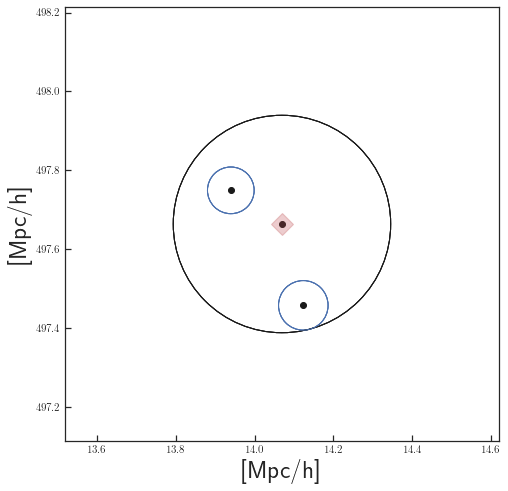

In [86]:
fig, ax = plt.subplots(figsize=(8,8))
for i in g_ind[0]:
    print(G['Pos'][i][0])
    
    
    plt.plot( (G['Pos'][i])[0], (G['Pos'][i])[1], 'ko')
    plt.plot( 14.069526, 497.66397, 'rD', markersize=15, alpha=0.1)
    
    circle1 = plt.Circle((14.069526, 497.66397), 0.27567366, color='k', fill=False, clip_on=False)
    
    circle2 = plt.Circle((13.939832, 497.74933), 0.05918148, color='b', fill=False, clip_on=False)
    circle3 = plt.Circle((14.123639, 497.45767), 0.06282725, color='b', fill=False, clip_on=False)
    
    ax.add_artist(circle1)
    ax.add_artist(circle2)
    ax.add_artist(circle3)
    
    #plt.tight_layout()
    ax.set_aspect('equal')
    plt.xlim(14.069526-2*0.27567366,14.069526+2*0.27567366)
    plt.ylim(497.66397-2*0.27567366, 497.66397+2*0.27567366)
    
    ax.set_xlabel(r'[Mpc/h]', fontsize=25)
    ax.set_ylabel(r'[Mpc/h]',fontsize=25)

In [91]:
#HI Masses, obtained from the indices: 
perc_richer_central_hi_m = np.log10( (np.sum(G['DiscHI'],axis=1)[perc_richer_central_ind] *1e10/h )+1)
perc_poorer_central_hi_m = np.log10( (np.sum(G['DiscHI'],axis=1)[perc_poorer_central_ind] *1e10/h )+1)
perc_richer_central_s_m = np.log10( G['StellarMass'][perc_richer_central_ind] *1e10/h +1)
perc_poorer_central_s_m = np.log10( G['StellarMass'][perc_poorer_central_ind] *1e10/h +1)

#have to store satellites like this; otherwise it complains
perc_richer_sat_hi_m = []
perc_richer_sat_s_m = []

for item in perc_richer_sat_ind:
    p_richer_sat_hi_m = np.log10( (np.sum(G['DiscHI'],axis=1)[item] *1e10/h )+1)
    p_richer_sat_s_m = np.log10( G['StellarMass'][item] *1e10/h +1)
    perc_richer_sat_hi_m.append(p_richer_sat_hi_m)
    perc_richer_sat_s_m.append(p_richer_sat_s_m)

perc_poorer_sat_hi_m = []
perc_poorer_sat_s_m = []
for item in perc_poorer_sat_ind:    
    p_poorer_sat_hi_m = np.log10( (np.sum(G['DiscHI'],axis=1)[item] *1e10/h )+1)
    p_poorer_sat_s_m = np.log10( G['StellarMass'][item] *1e10/h +1)
    perc_poorer_sat_hi_m.append(p_poorer_sat_hi_m)
    perc_poorer_sat_s_m.append(p_poorer_sat_s_m)


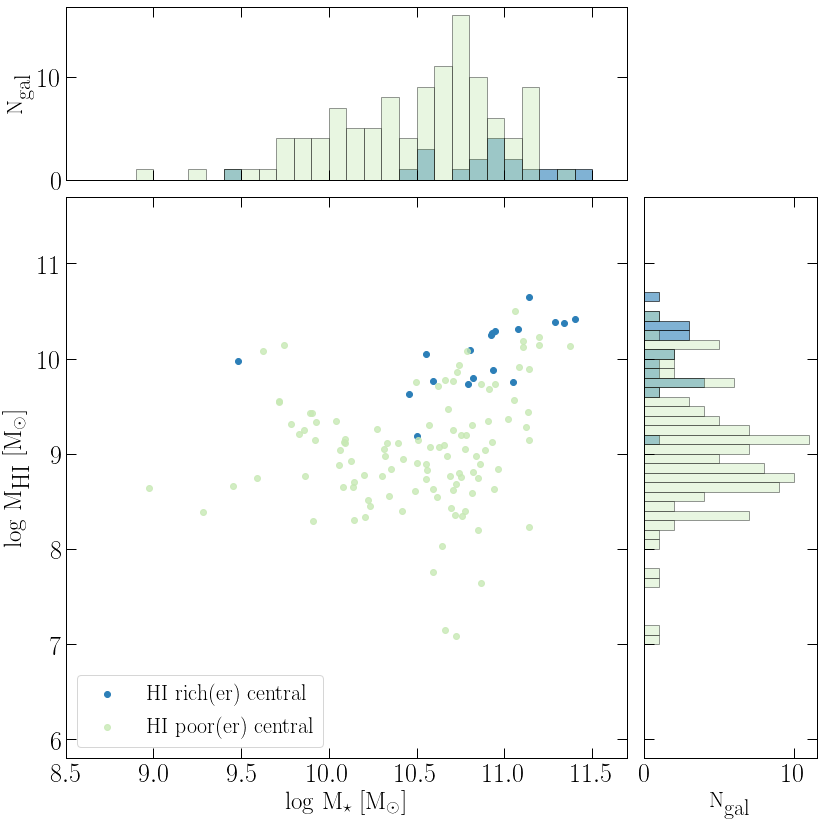

In [92]:
two_sided_histogram_rich(perc_richer_central_s_m, perc_richer_central_hi_m, 
                         perc_poorer_central_s_m, perc_poorer_central_hi_m) 

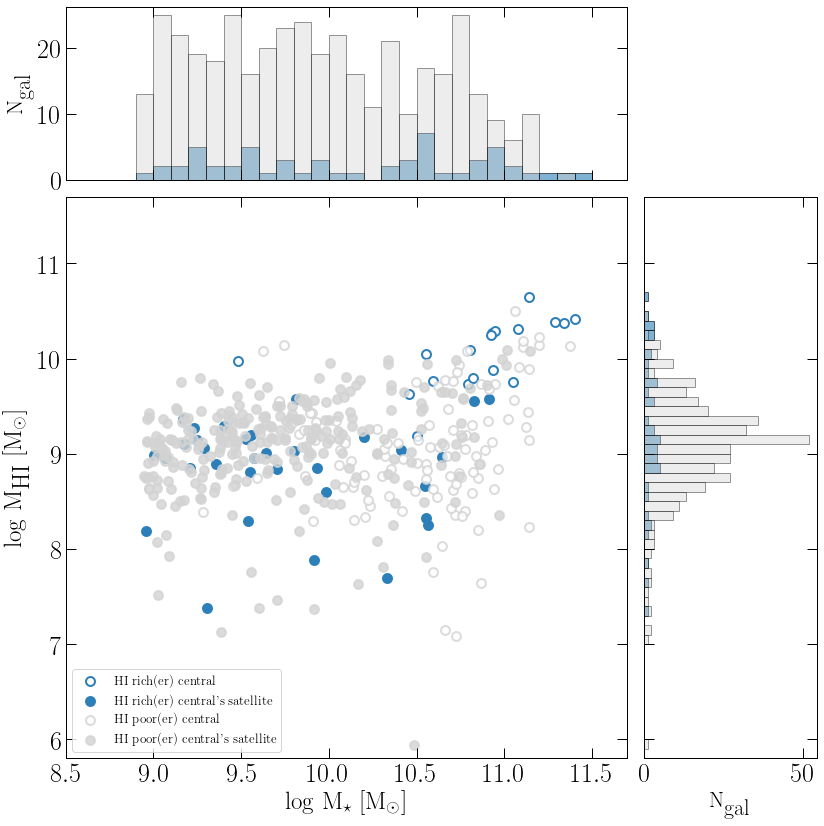

In [93]:
two_sided_histogram_rich_groups(perc_richer_central_s_m.ravel(), perc_richer_central_hi_m.ravel(), 
                                perc_poorer_central_s_m.ravel(), perc_poorer_central_hi_m.ravel(),
                                perc_richer_sat_s_m, perc_richer_sat_hi_m, 
                                perc_poorer_sat_s_m, perc_poorer_sat_hi_m) 


# Central and satellite (similar Mstar; large MHI difference)
##### Takes too long to run

In [84]:
#Use dictionary and for each galaxy in "Groups" of 3 show central/satellite index

diff_central_ind = [] #storring where central/satellite is above/below some percentage
norm_diff_central_ind = []

norm_diff_sat_ind = [] #satellites that belong to richer central
diff_sat_ind = [] #satellites that belong to poorer central

diff_groups = []
gr_key = []
#per_cent = [] # How much of HI mass is in central galaxy (in %)

for i in trange(3,10,1): #starting grom galaxy pairs
    for group_key in updated_dict[i]["Groups"].keys():
        #print(group_key) #group_1 etc
        central_idx = updated_dict[i]["Groups"][group_key]["Centrals"] #give indices
        central_mass = np.log10(np.sum(G['DiscHI'],axis=1)[central_idx]*1e10/h +1) #give masses of these galaxies
        central_star_mass = np.log10(G['StellarMass'][central_idx]*1e10/h +1)
        
        satellite_inds = updated_dict[i]["Groups"][group_key]["Satellites"]
        sat_mass = np.log10(np.sum(G['DiscHI'],axis=1)[satellite_inds]*1e10/h +1)
        sat_star_mass = np.log10(G['StellarMass'][satellite_inds]*1e10/h +1)
        
        sum_of_all_satellites = np.sum(sat_mass)
        percentage = (central_mass/(central_mass+sum_of_all_satellites))*100
        per_cent.append(percentage[0])
        
        diff_in_star_mass = abs(central_star_mass - sat_star_mass) #abs difference in stellar masses
        #print(central_star_mass)
        #print(sat_star_mass)
        #print('diff star', diff_in_star_mass)
        diff_in_hi_mass = abs(central_mass - sat_mass) #abs difference in HI mass
        #print('hi cent mass', central_mass)
        #print('hi sat mass', sat_mass)
        
        if ((diff_in_star_mass < 0.4).all() & (diff_in_hi_mass > 0.5 ).all()):
            print('diff_st', diff_in_star_mass)
            print('diff_hi', diff_in_hi_mass)
            
            #print('yes')#check conditions
#            print("Central has more HI than the sum of satellites")
            diff_central_ind.append(central_idx[0]) #[0] so its creates a list
            diff_sat_ind.extend(satellite_inds) #it complains and complicates when i want to do .append
            diff_groups.append(updated_dict[i]["Groups"][group_key]['Centrals'][0])
            diff_groups.extend(satellite_inds)
            gr_key.append(group_key)
        else:
#            print("Sum of the satellites are more massive than central")
            norm_diff_central_ind.append(central_idx[0])
            norm_diff_sat_ind.extend(satellite_inds)
#        #print(sat_mass > central_mass)
#    
#        print("Central mass is {0} and sat masses are {1}".format(central_mass, sat_mass))
#        print("")



  0%|          | 0/7 [00:00<?, ?it/s]

diff_st [0.09826946 0.36101055]
diff_hi [0.6885042 1.6023378]
diff_st [0.34529114 0.06172562]
diff_hi [1.3861694 0.980216 ]
diff_st [0.32968044 0.24324226]
diff_hi [0.5631428  0.88286114]
diff_st [0.35604858 0.39379597]
diff_hi [1.725626  1.0154037]
diff_st [0.16127777 0.22986507]
diff_hi [0.64190197 0.5603075 ]
diff_st [0.28347492 0.01746464]
diff_hi [9.1543    0.5831814]
diff_st [0.1982317  0.19189072]
diff_hi [0.5888891 2.0001822]
diff_st [0.25108242 0.29368782]
diff_hi [0.7677164 0.6449919]
diff_st [0.31555367 0.31858158]
diff_hi [1.2623177  0.89769363]
diff_st [0.297534  0.2145052]
diff_hi [9.381781 9.664302]
diff_st [0.2896881  0.26909924]
diff_hi [1.7990522 1.2221317]
diff_st [0.14000034 0.3312893 ]
diff_hi [1.1634445 0.9467926]
diff_st [0.14378357 0.23471165]
diff_hi [0.5497532 0.5055742]
diff_st [0.19493389 0.3158226 ]
diff_hi [0.5612154 1.1073942]
diff_st [0.17045403 0.10250187]
diff_hi [0.67097664 0.67658806]
diff_st [0.08139992 0.10401535]
diff_hi [1.1512203 0.8087168]
diff

KeyboardInterrupt: 

In [85]:
print(diff_groups)
print(gr_key)


[6510, 6511, 6512, 6583, 6584, 6585, 41751, 41752, 41753, 42110, 42111, 42112, 42484, 42485, 42486, 74669, 74670, 74671, 74762, 74764, 74763, 113044, 113045, 113046, 128515, 128516, 128517, 161999, 162000, 162001, 199126, 199127, 199128, 200108, 200109, 200110, 200170, 200171, 200172, 223493, 223494, 223495, 237254, 237255, 237256, 237288, 237289, 237290, 237758, 237759, 237760, 238228, 238229, 238230, 255479, 255480, 255481, 255505, 255506, 255507, 276673, 276674, 276675, 292543, 292544, 292545, 305792, 305793, 305794, 374066, 374067, 374068, 379371, 379372, 379373, 413076, 413077, 413078, 413849, 413850, 413851, 414632, 414634, 414633, 430675, 430677, 430676, 450700, 450702, 450701, 451070, 451071, 451072, 451364, 451365, 451366, 468191, 468192, 468193, 487211, 487213, 487212, 524730, 524731, 524732, 538105, 538106, 538107, 559053, 559054, 559055]
['Group_28', 'Group_30', 'Group_95', 'Group_99', 'Group_114', 'Group_156', 'Group_160', 'Group_256', 'Group_310', 'Group_366', 'Group_462'

In [86]:
#HI Masses, obtained from the indices: 
diff_central_hi_m = np.log10( (np.sum(G['DiscHI'],axis=1)[diff_central_ind] *1e10/h )+1)
diff_central_s_m = np.log10( G['StellarMass'][diff_central_ind] *1e10/h +1)

#have to store satellites like this; otherwise it complains
diff_sat_hi_m = np.log10( (np.sum(G['DiscHI'],axis=1)[diff_sat_ind] *1e10/h )+1)
diff_sat_s_m = np.log10( G['StellarMass'][diff_sat_ind] *1e10/h +1)

#HI Masses, obtained from the indices: 
norm_diff_central_hi_m = np.log10( (np.sum(G['DiscHI'],axis=1)[norm_diff_central_ind] *1e10/h )+1)
norm_diff_central_s_m = np.log10( G['StellarMass'][norm_diff_central_ind] *1e10/h +1)

#have to store satellites like this; otherwise it complains
norm_diff_sat_hi_m = np.log10( (np.sum(G['DiscHI'],axis=1)[norm_diff_sat_ind] *1e10/h )+1)
norm_diff_sat_s_m = np.log10( G['StellarMass'][norm_diff_sat_ind] *1e10/h +1)

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


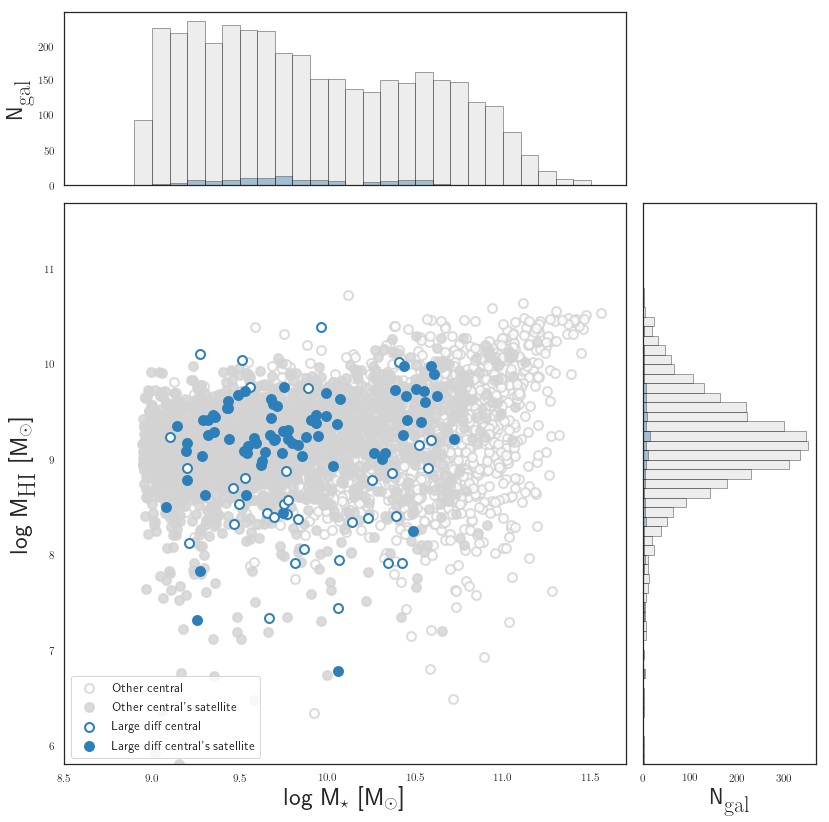

In [87]:
two_sided_histogram_difference(diff_central_s_m.ravel(), diff_central_hi_m.ravel(), 
                                norm_diff_central_s_m.ravel(), norm_diff_central_hi_m.ravel(),
                                diff_sat_s_m, diff_sat_hi_m, 
                                norm_diff_sat_s_m, norm_diff_sat_hi_m) 


In [88]:
item1 = 9
item2 = 12
diff_groups_sm = np.log10( G['StellarMass'][diff_groups] *1e10/h +1)
diff_groups_him = np.log10( (np.sum(G['DiscHI'],axis=1)[diff_groups] *1e10/h) +1)

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


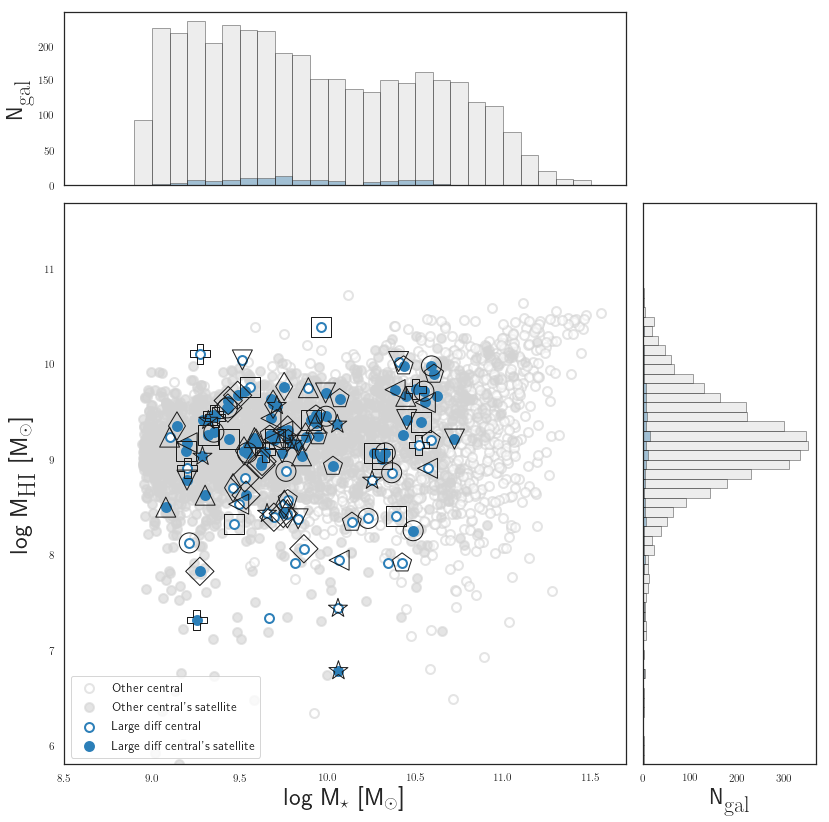

In [89]:

two_sided_histogram_difference_groups(diff_central_s_m.ravel(), diff_central_hi_m.ravel(), 
                                norm_diff_central_s_m.ravel(), norm_diff_central_hi_m.ravel(),
                                diff_sat_s_m, diff_sat_hi_m, 
                                norm_diff_sat_s_m, norm_diff_sat_hi_m,
                              diff_groups_sm, diff_groups_him) 

In [100]:
print(diff_groups)
print(diff_central_ind)
print(gr_key)

[426, 427, 428, 8443, 8444, 8445, 8485, 8486, 8487, 15042, 15043, 15044, 15087, 15088, 15089]
[426, 8443, 8485, 15042, 15087]
['Group_3', 'Group_20', 'Group_23', 'Group_52', 'Group_55']


In [101]:
for i in gr_key:
    print(updated_dict[3]["Groups"][i]) #shows indices of Nth group in groups of 3

{'Centrals': [426], 'Satellites': [427, 428]}
{'Centrals': [8443], 'Satellites': [8444, 8445]}
{'Centrals': [8485], 'Satellites': [8486, 8487]}
{'Centrals': [15042], 'Satellites': [15043, 15044]}
{'Centrals': [15087], 'Satellites': [15088, 15089]}


In [102]:
#Divide array into n-arrays
#f = lambda diff_groups, n=3: [diff_groups[i:i+n] for i in range(0, len(diff_groups), n)]
#New_groups = f(diff_groups)
#print(New_groups)

## Place colormap for centrals

In [103]:
import matplotlib.cm as cm
